# Hardware: Nabudoconodosor

In [1]:
!nvidia-smi

Mon Feb 13 09:48:37 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.85.02    Driver Version: 510.85.02    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A30          On   | 00000000:02:00.0 Off |                    0 |
| N/A   19C    P0    27W / 165W |  23933MiB / 24576MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A10          On   | 00000000:84:00.0 Off |                    0 |
|  0%   

In [53]:
!nvidia-smi

Mon Feb 13 17:19:05 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.85.02    Driver Version: 510.85.02    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A30          On   | 00000000:02:00.0 Off |                    0 |
| N/A   20C    P0    27W / 165W |  23933MiB / 24576MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A10          On   | 00000000:84:00.0 Off |                    0 |
|  0%   

# Carga de datos 
El dataset se cargó a la notebook por medio del terminal de ubuntu con el siguiente código:

ls: MUESTRA LAS CARPETAS DISPONIBLES

cd: PARA UBICARSE EN UNA CARPETA

scp -r </home/ines/pps/DatasetPI> isadir@nabucodonosor.ccad.unc.edu.ar:~/ : CARGA LA CARPETA DatasetPI

cd~: PARA SALIR DE LAS CARPETAS

Se genera una función que recibe la tres carpetas, en este caso en la carpeta DatasetPI se tiene la carpeta Estructuras con las imágenes de las estructuras demarcadas (que son las x) y la carpeta Dosis con las dosis (que son las y) correspondientes. Además se verifica que existan la misma cantidad de volúmenes y dosis.

In [1]:
import os 
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def cargar_carpetas(carpeta, carpeta_estruc, carpeta_dosis ):
    direc = Path(carpeta +"/")
    estruc = [direc/carpeta_estruc/i for i in os.listdir(direc/carpeta_estruc)]
    dosis = [direc/carpeta_dosis/i for i in os.listdir(direc/carpeta_dosis)]
    estruc = sorted(estruc)
    dosis = sorted(dosis)
    print("Carpetas cargadas")
    if len(estruc) != len(dosis):
        print("La cantidad de volúmenes no es equivalente a la cantidad de máscaras")
    print('La carpeta {} tiene {} volúmenes y la carpeta {} tiene {} máscaras'.format(carpeta_estruc, len(estruc),carpeta_dosis, len(dosis)))
    
    return estruc, dosis

# * Visualización de los datos
A continuación, se muestra un ejemplo de superposición de unas estructuras con su correspondiente distribución de dosis planificada y se examina el tipo de dato.

In [4]:
estruc, dosis = cargar_carpetas('DatasetPI', 'Estructuras', 'Dosis')

Carpetas cargadas
La carpeta Estructuras tiene 120 volúmenes y la carpeta Dosis tiene 120 máscaras


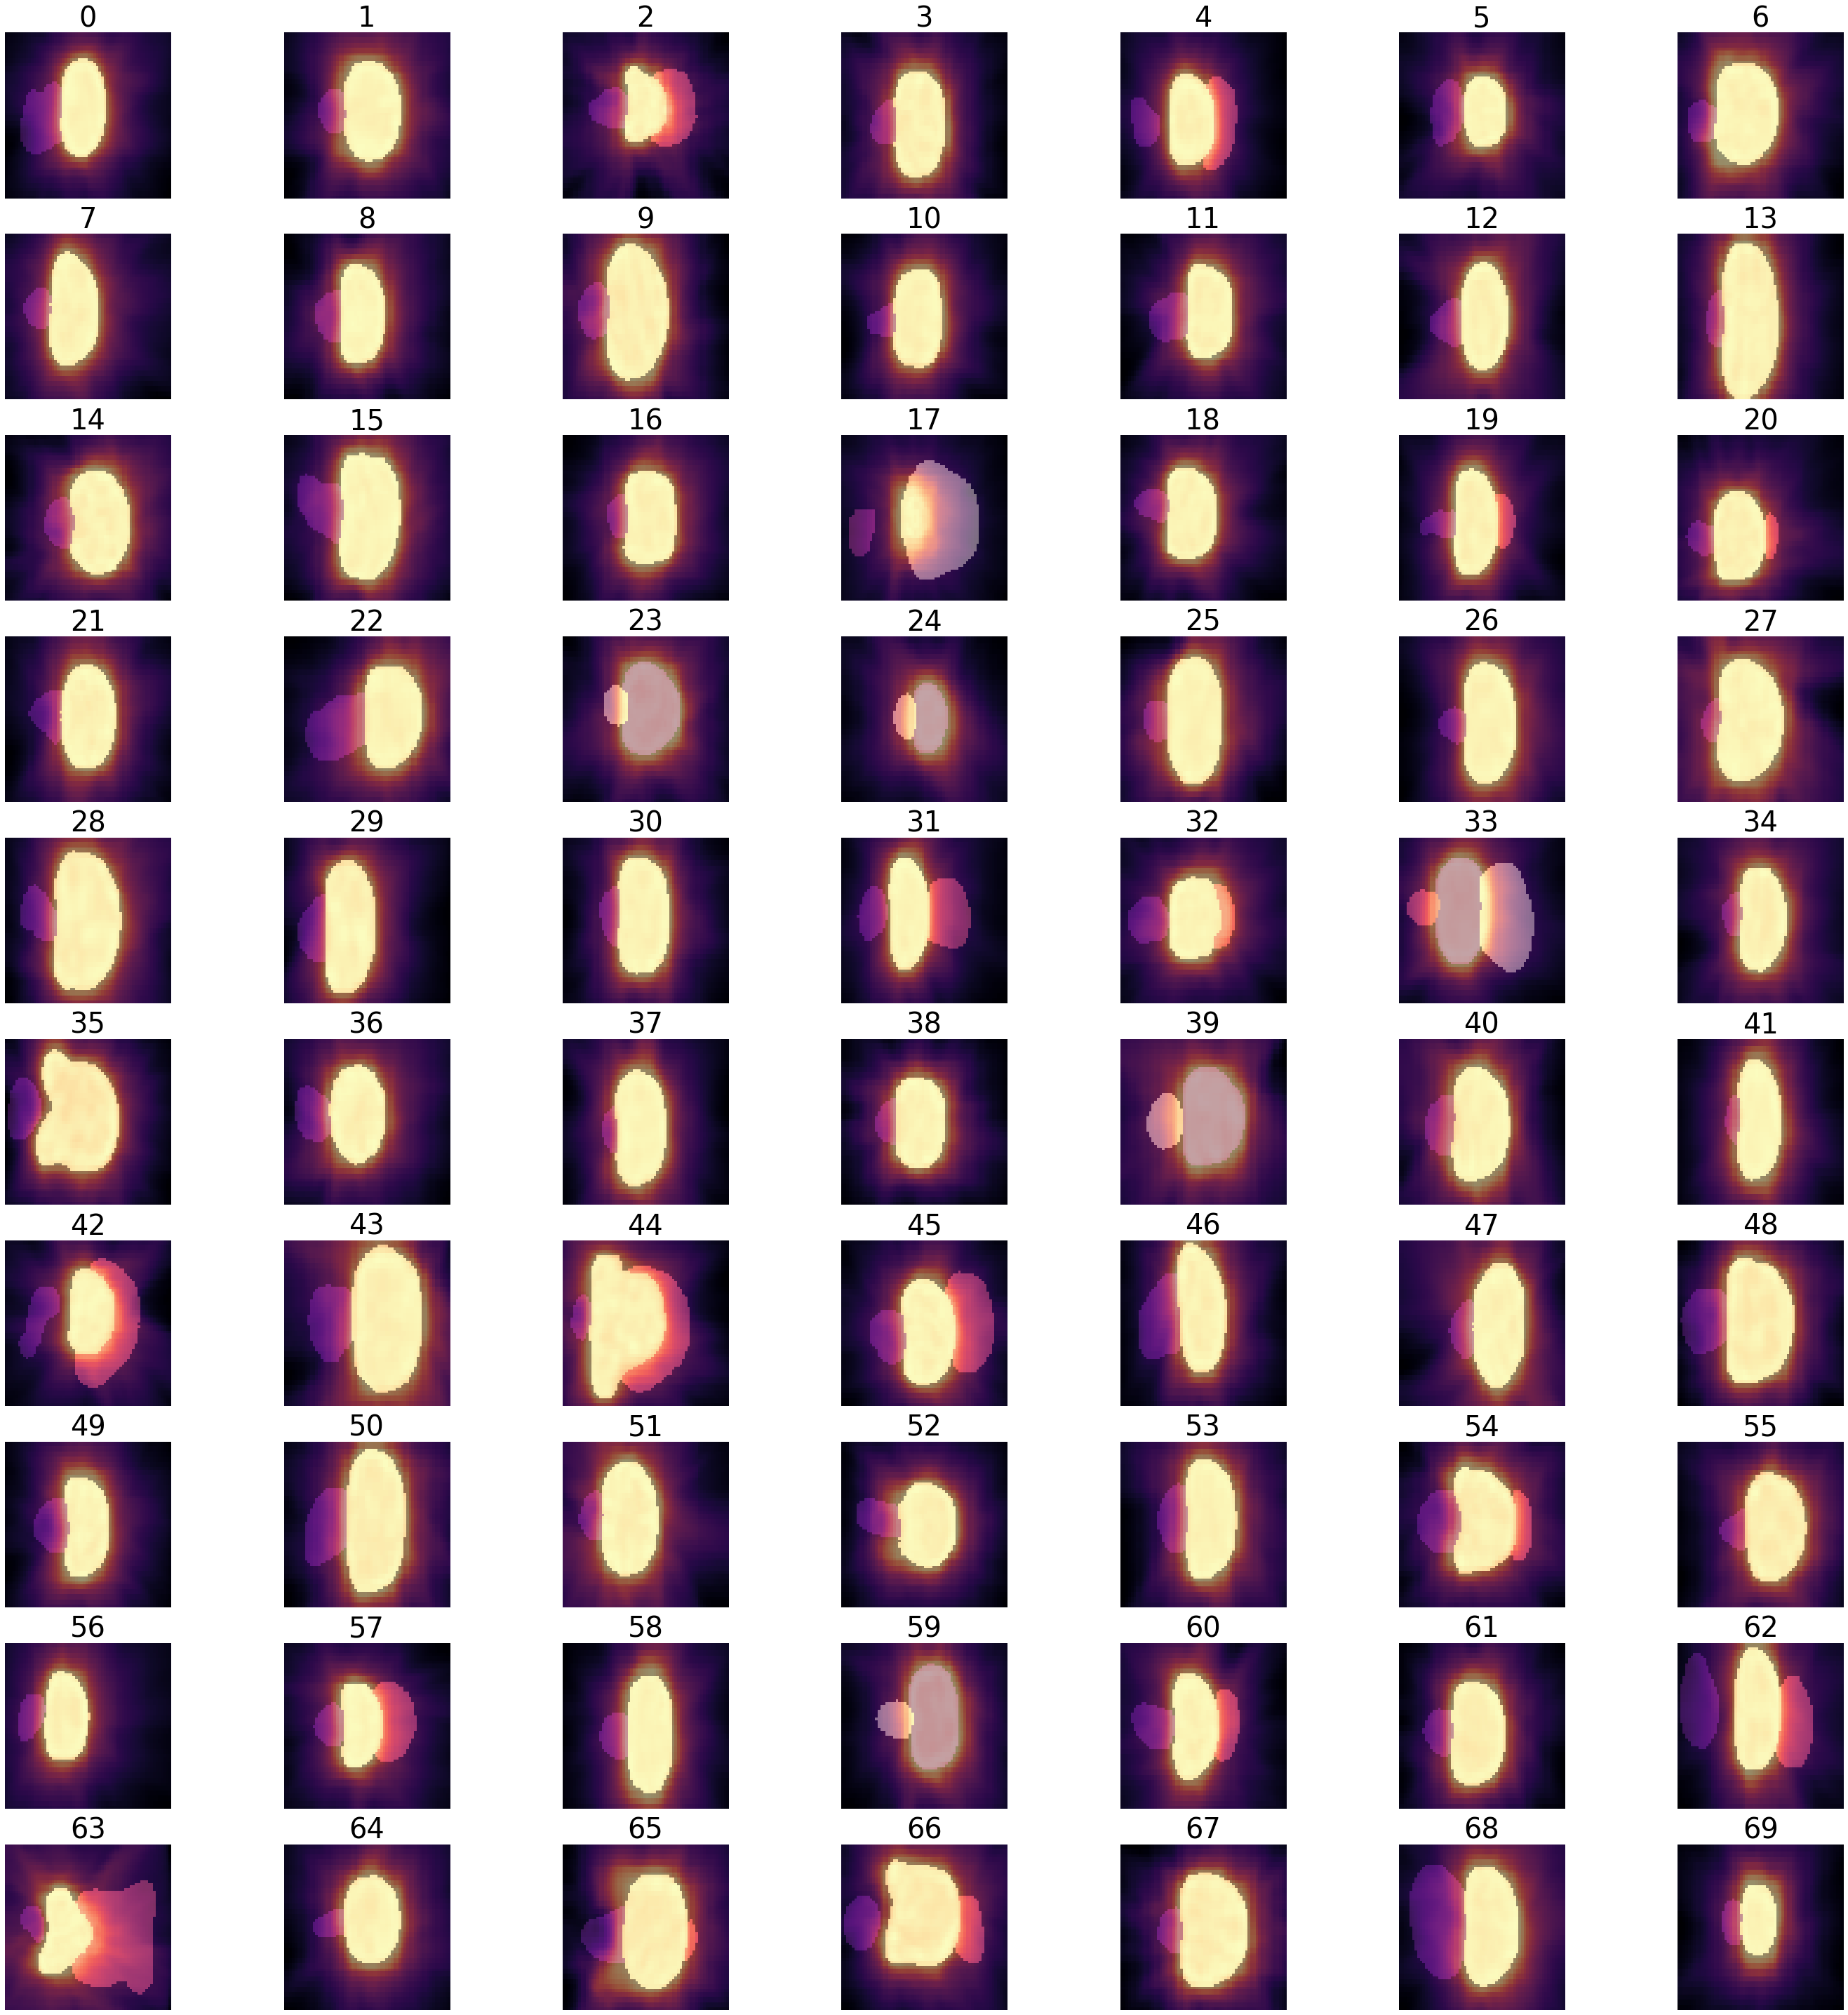

In [5]:
plt.figure(figsize=(40,40))
for i in range(70):
    plt.subplot(10, 7, i+1)
    img = np.load(dosis[i])
    mask = np.load(estruc[i])
    plt.title(i, size=40)
    plt.imshow(img[:,:,23],cmap="magma")
    plt.imshow(mask[:,:,23], alpha=0.4,cmap="magma")
    plt.axis('Off')    
plt.tight_layout()
plt.show() 

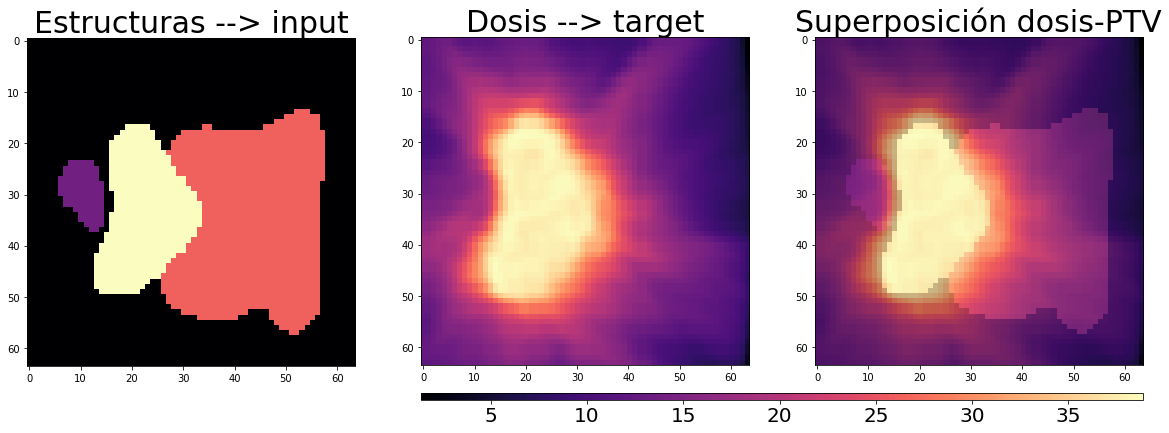

In [59]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
est = np.load(estruc[63]) 
dos = np.load(dosis[63])
ax1.imshow(est[:,:,23],cmap="magma")
ax1.set_title("Estructuras --> input",size=30 )
ax2.imshow(dos[:,:,23],cmap="magma")
ax2.set_title("Dosis --> target",size=30 )
im=ax2.imshow(dos[:,:,23],cmap="magma")
ax3.imshow(est[:,:,23],cmap="magma")
ax3.imshow(dos[:,:,23], alpha=0.8,cmap="magma")
ax3.set_title("Superposición dosis-PTV",size=30 )
cbar = plt.colorbar(im, orientation="horizontal", ax = [ax2, ax3], pad=0.05, aspect=100)
cbar.ax.tick_params(labelsize=20)
plt.show()

El tipo de dato de ambos volúmenes es float64 aunque técnicamente los volúmenes de estructuras son enteros ya que se representa con valor 0, 1, 2 y 3 a los pixeles del fondo, recto próstata (PTV) y vejiga . Por el lado de las dosis el valor de prescripción es de 36,25 Gy en el PTV pero por cuestiones geométricas y de tecnología hay puntos donde la dosis puede llegar a valores alrededor de 40.

In [7]:
type(est), est.shape, est.dtype, est.min(), est.max()

(numpy.ndarray, (64, 64, 64), dtype('float64'), 0.0, 3.0)

In [8]:
type(dos), dos.shape, dos.dtype, dos.min(), dos.max()

(numpy.ndarray, (64, 64, 64), dtype('float64'), 0.0, 39.180076599121094)

# * Preparación de los datos
A las imágenes de las estructuras se pasan a formato One Hot Encoding que genera para cada pixel un vector con la cantidad de posiciones según la cantidad de estructuras que se tenga y le asigna el valor 1 a la posición que corresponda a la estructura que representa dicho pixel y 0 a todas las demás. A las máscaras de las dosis se las escalar en valores aproximadamente entre 1 y 0 considerando que el valor máximo es 36,25.

In [9]:
est_oh = (np.arange(4) == est[...,None]).astype(np.float64) 
type(est_oh), est_oh.shape, est_oh.dtype, est_oh.max(), est_oh.min()


(numpy.ndarray, (64, 64, 64, 4), dtype('float64'), 1.0, 0.0)

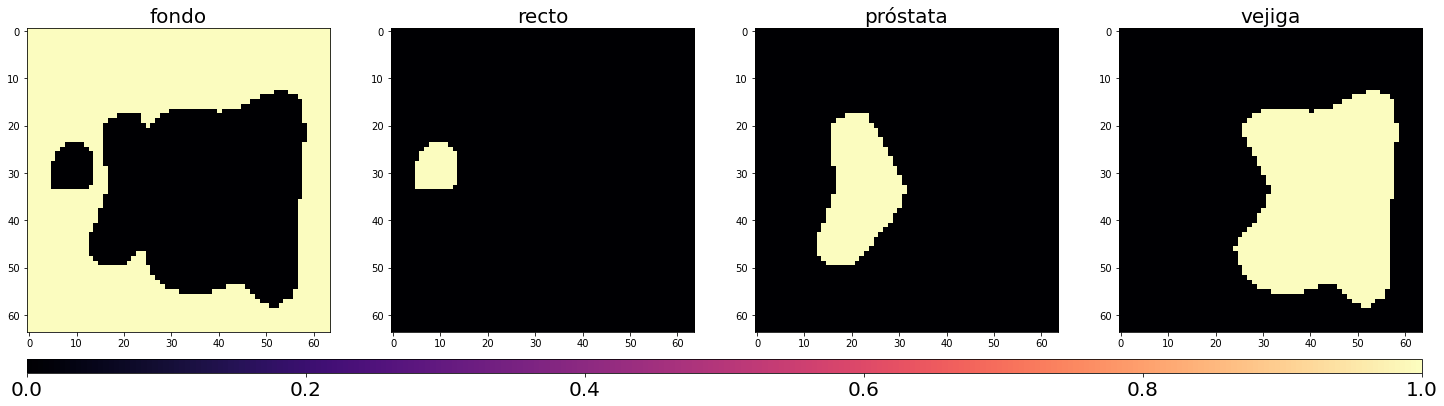

In [60]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(25,10))
ax1.imshow(est_oh[:,:,24,0],cmap="magma")
ax1.set_title("fondo",size=20 )
ax2.imshow(est_oh[:,:,24,1],cmap="magma")
ax2.set_title("recto",size=20 )
ax3.imshow(est_oh[:,:,24,3],cmap="magma")
ax3.set_title("próstata",size=20 )
ax4.imshow(est_oh[:,:,24,2],cmap="magma")
im = ax4.imshow(est_oh[:,:,24,2],cmap="magma")
ax4.set_title("vejiga",size=20 )
cbar = plt.colorbar(im, orientation="horizontal", ax = [ax1, ax2, ax3, ax4], pad=0.05, aspect=100)
cbar.ax.tick_params(labelsize=20)
plt.show()

In [18]:
dos_e = dos/36.25
type(dos_e), dos_e.shape, dos_e.dtype, dos_e.max(), dos_e.min()

(numpy.ndarray, (64, 64, 64), dtype('float64'), 1.080829699286099, 0.0)

## Generalizando
Con el modulo torch.utils.data de PyTorh se cargan los datos. La clase Dataset permiten instanciar objetos con el conjunto de datos que se van a cargar. Luego se aplica el preprocesamiento necesario, es decir el One Hot Encoding para las estructuras y el escalamiento para las dosis. 


In [3]:
import torch.utils.data

In [4]:
class Dataset (torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
       
    def __len__(self):
        assert len(self.x) == len(self.y), "La cantidad de volúmenes no es equivalente a la cantidad de máscaras"
        return len(self.x)
    
    
    def __getitem__(self,ix):
        img = np.load(self.x[ix])
        mask = np.load(self.y[ix])
        img_oh = (np.arange(4) == img[...,None]).astype(np.float64)
        img_tensor= torch.tensor(img_oh).permute(3, 0, 1, 2)
        mask_e = mask/36.25
        mask_tensor = torch.tensor(mask_e).unsqueeze(0)
        
        return img_tensor, mask_tensor

# U-Net

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [6]:
def conv3x3_bn(ci, co):
    return torch.nn.Sequential(
        torch.nn.Conv3d(ci, co, 3, padding=1),
        torch.nn.BatchNorm3d(co),
        torch.nn.ReLU(inplace=True)
    )

def encoder_conv(ci, co):
    return torch.nn.Sequential(
        torch.nn.MaxPool3d((2, 2, 2)),
        conv3x3_bn(ci, co),
        conv3x3_bn(co, co),
    )

class deconv(torch.nn.Module):
    def __init__(self, ci, co):
        super(deconv, self).__init__()
        self.upsample = torch.nn.ConvTranspose3d(ci, co, 2, stride=2, padding=0)
        self.conv1 = conv3x3_bn(ci, co)
        self.conv2 = conv3x3_bn(co, co)
    
    # recibe la salida de la capa anetrior y la salida de la etapa
    # correspondiente del encoder
    def forward(self, x1, x2):
        x1 = self.upsample(x1)
#         diffX = x2.size()[2] - x1.size()[2] # si no se usa zero padding en las convoluciónes se deben cortar antes de cat
#         diffY = x2.size()[3] - x1.size()[3]
#         x1 = F.pad(x1, (diffX, 0, diffY, 0))
        # concatenamos los tensores
        x = torch.cat([x2, x1], axis=1)
        x = self.conv1(x)
        x = self.conv2(x)
        return x

class UNet(torch.nn.Module):
    def __init__(self, n_classes=4, in_ch=4):
        super().__init__()

        # lista de capas en encoder-decoder con número de filtros
        c = [64, 128, 256, 512]

        # primera capa conv que recibe la imagen
        self.conv1 = torch.nn.Sequential(
          conv3x3_bn(in_ch, c[0]),
          conv3x3_bn(c[0], c[0]),
        )
        # capas del encoder
        self.conv2 = encoder_conv(c[0], c[1])
        self.conv3 = encoder_conv(c[1], c[2])
        self.conv4 = encoder_conv(c[2], c[3])

        # capas del decoder
        self.deconv1 = deconv(c[3],c[2])
        self.deconv2 = deconv(c[2],c[1])
        self.deconv3 = deconv(c[1],c[0])

        # útlima capa conv que nos da la máscara
        self.out = torch.nn.Conv3d(c[0],  1, kernel_size=1, padding=0)

    def forward(self, x):
        # encoder
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        x3 = self.conv3(x2)
        x = self.conv4(x3)
        # decoder
        x = self.deconv1(x, x3)
        x = self.deconv2(x, x2)
        x = self.deconv3(x, x1)
        x = self.out(x)
        return x

## * Comprobar funcionamiento 
Se le ingresa a la arquitectura un tensor random con las dimensiones de los volúmenes de entrada y se verifica que la salida sea con las dimensiones de las dosis

In [23]:
model = UNet()
output = model(torch.randn((1, 4, 64, 64, 64)))
output.shape

torch.Size([1, 1, 64, 64, 64])

In [24]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [25]:
dos_tensor = torch.tensor(dos_e).unsqueeze(0).unsqueeze(0)
est_tensor= torch.tensor(est_oh).permute(3, 0, 1, 2).unsqueeze(0)

# Métricas 

In [29]:
import math
from sklearn.metrics import f1_score, jaccard_score

## IoU
Intersection over Union se usa para evaluar, es la relación entre las predicciones correctas y el área total combinada de predicción y verdad del terreno. Como los targets y las predicciones no son imágenes estrictamente binarias se adaptó de tal forma que se contabilicen los pixeles que tengan el mismo valor (redondeado) y no únicamente los que se encuentren por arriba de un umbral. 

In [30]:
def iou(true, pred, smooth=0.0000001):
    intersect = torch.sum((torch.round(true) == torch.round(pred)).int())
    union = math.prod(true.shape) + math.prod(pred.shape)-intersect
    return   torch.mean(intersect /(union+smooth))

## Dice
Es una métrica que mide la similitud con la relación entre la intersección por dos y la suma del área total de las dos figuras. 

In [31]:
def dice(true, pred, smooth=0.0000001):
    intersect = torch.sum((torch.round(true) == torch.round(pred)).int())
    union = math.prod(true.shape) + math.prod(pred.shape)
    return   torch.mean((2 * intersect) /(union+smooth))

## i

In [32]:
def i(true, pred, smooth=0.00000001):
    i=torch.sum(-(true-pred)**2+1)
    u = math.prod(true.shape)
    return torch.mean(i /(u+smooth))

## F1 y Jaccard
Métricas del paquete de sklearn, F1 es matemáticamente equivalente a Dice y F1 a IoU.

In [33]:
def pre (y):
    y = y.cpu().numpy()
    y = y.astype(np.uint8)
    y = y.reshape(-1)
    return y

def f1 (true, pred):
    y_true = pre(true)
    y_pred = pre(pred)
    return f1_score(y_true, y_pred, average='macro')

def jac (true, pred):
    y_true = pre(true)
    y_pred = pre(pred)
    return jaccard_score(y_pred,  y_true, average='macro') 

# BCEDiceLoss

In [34]:
class BCEDiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super().__init__()

    def forward(self, true, pred):
        true = true.view(-1)
        pred = pred.view(-1)
        # BCE loss
        bce_loss = nn.BCEWithLogitsLoss()(true, pred).double()
        # Dice Loss
        dice_coef = ((-(true-pred)**2+1).double().sum()) / (math.prod(true.shape))
        return bce_loss + (1 - dice_coef)

# * Entrenamiento de un solo volumen
Para verificar que no hay errores de código primero se corre un entrenamiento para un solo ejemplo.

In [35]:
def fit(model, X, y, epochs=1, lr=1e-4):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.MSELoss()
    model.to(device)
    X = X.to(device=device, dtype=torch.float)
    y = y.to(device=device, dtype=torch.float)
    model.train()
    for epoch in range(1, epochs+1):
        optimizer.zero_grad()
        y_hat = model(X)
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()
        ious = iou(y_hat, y)
        dices = dice(y_hat, y)
        iss = i(y_hat, y)
        print(f"Epoch {epoch}/{epochs} loss {loss.item():.5f} iou {ious:.3f} dice {dices:.3f} i {iss:.5f}")

In [33]:
fit(model, est_tensor, dos_tensor, epochs=500)

Epoch 1/500 loss 0.24806 iou 0.726 dice 0.842 i 0.75194
Epoch 2/500 loss 0.22232 iou 0.770 dice 0.870 i 0.77768
Epoch 3/500 loss 0.12329 iou 0.804 dice 0.891 i 0.87671
Epoch 4/500 loss 0.08784 iou 0.821 dice 0.901 i 0.91216
Epoch 5/500 loss 0.07984 iou 0.809 dice 0.895 i 0.92016
Epoch 6/500 loss 0.06296 iou 0.823 dice 0.903 i 0.93704
Epoch 7/500 loss 0.04709 iou 0.848 dice 0.918 i 0.95291
Epoch 8/500 loss 0.03997 iou 0.862 dice 0.926 i 0.96003
Epoch 9/500 loss 0.03698 iou 0.865 dice 0.928 i 0.96302
Epoch 10/500 loss 0.03172 iou 0.872 dice 0.932 i 0.96828
Epoch 11/500 loss 0.02554 iou 0.885 dice 0.939 i 0.97446
Epoch 12/500 loss 0.02066 iou 0.892 dice 0.943 i 0.97934
Epoch 13/500 loss 0.01850 iou 0.890 dice 0.942 i 0.98150
Epoch 14/500 loss 0.01732 iou 0.887 dice 0.940 i 0.98268
Epoch 15/500 loss 0.01504 iou 0.895 dice 0.945 i 0.98496
Epoch 16/500 loss 0.01310 iou 0.908 dice 0.952 i 0.98690
Epoch 17/500 loss 0.01135 iou 0.920 dice 0.958 i 0.98865
Epoch 18/500 loss 0.01016 iou 0.931 dice

In [35]:
model.eval()
with torch.no_grad():
    output = model(est_tensor.to(device=device, dtype=torch.float))[0]

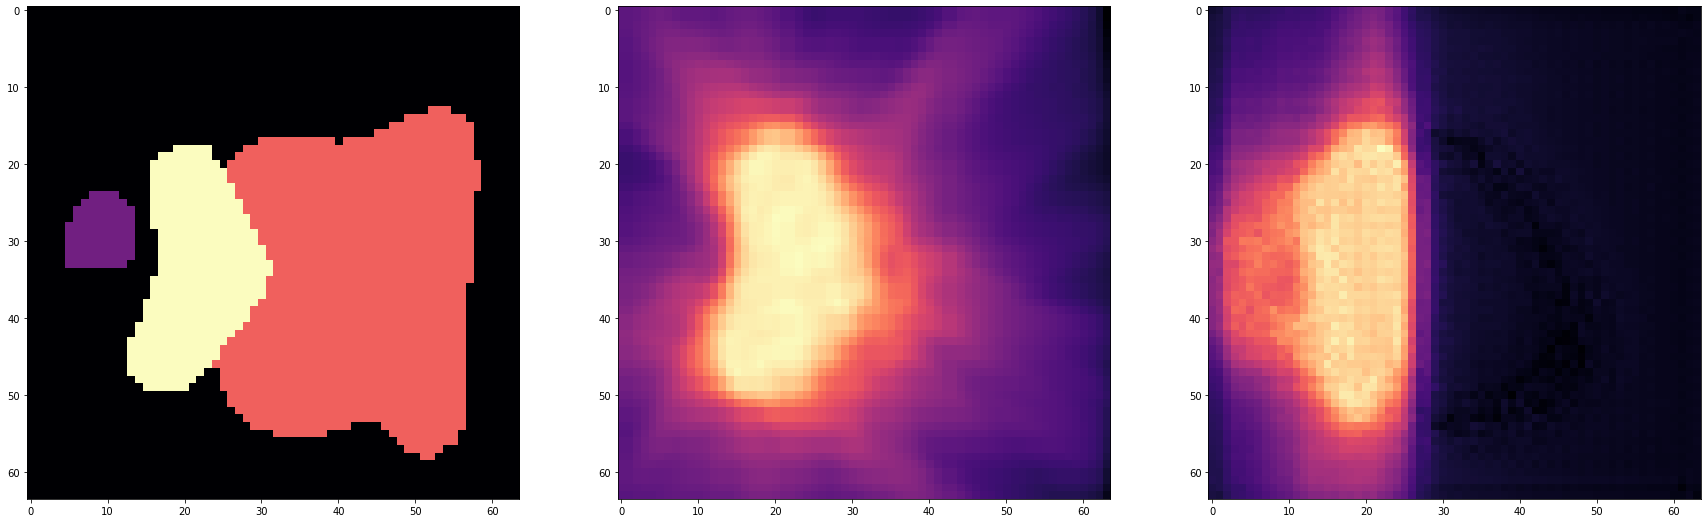

In [36]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
ax1.imshow(est[:,:,24],cmap="magma")
ax2.imshow(dos[:,:,24],cmap="magma")
ax3.imshow(output[:,:,24].squeeze().cpu().numpy(),cmap="magma")
plt.show()

# * Summary 
Descripción detallada de las capas del modelo y los parámetros.

In [34]:
from torchsummary import summary
summary(model, (4, 64, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1       [-1, 64, 64, 64, 64]           6,976
       BatchNorm3d-2       [-1, 64, 64, 64, 64]             128
              ReLU-3       [-1, 64, 64, 64, 64]               0
            Conv3d-4       [-1, 64, 64, 64, 64]         110,656
       BatchNorm3d-5       [-1, 64, 64, 64, 64]             128
              ReLU-6       [-1, 64, 64, 64, 64]               0
         MaxPool3d-7       [-1, 64, 32, 32, 32]               0
            Conv3d-8      [-1, 128, 32, 32, 32]         221,312
       BatchNorm3d-9      [-1, 128, 32, 32, 32]             256
             ReLU-10      [-1, 128, 32, 32, 32]               0
           Conv3d-11      [-1, 128, 32, 32, 32]         442,496
      BatchNorm3d-12      [-1, 128, 32, 32, 32]             256
             ReLU-13      [-1, 128, 32, 32, 32]               0
        MaxPool3d-14      [-1, 128, 16,

# Entrenamiento
Primero se dividen los datos para entrenamiento, los 100 primeros y testeo, los 23 restantes. Luego se carga y preprocesan los datos.

In [36]:
from tqdm import tqdm
import pandas as pd
import random

In [37]:
estruc, dosis = cargar_carpetas('DatasetPI/EntrenamientoPI', 'Estructuras', 'Dosis')

Carpetas cargadas
La carpeta Estructuras tiene 240 volúmenes y la carpeta Dosis tiene 240 máscaras


In [38]:
dataset = {
    "train" : Dataset(estruc[:180], dosis[:180]),
    "test" : Dataset(estruc[180:], dosis[180:])}

len(dataset["train"]), len(dataset["test"])

(180, 60)

In [39]:
dataloader = {
    "train" : torch.utils.data.DataLoader(dataset["train"], batch_size=2, shuffle=True, pin_memory=True),
    "test" : torch.utils.data.DataLoader(dataset["test"], batch_size=2, pin_memory=True) }

imges, maskes = next(iter(dataloader["train"]))
imges.shape, maskes.shape

(torch.Size([2, 4, 64, 64, 64]), torch.Size([2, 1, 64, 64, 64]))

In [40]:
def fit(model, dataloader, epochs=10, lr=1e-4):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = MSELoss()
    model.to(device)
    hist = {'loss': [], 'test_loss': [], 'iou': [], 'dice': [], 'iou_test': [], 'dice_test': []}
    for epoch in range(1, epochs+1):
        print(f"\nEpoch {epoch}/{epochs}")
        bar = tqdm(dataloader['train'])
        train_loss= []
        model.train()
        for imges, maskes in bar:
            imges, maskes = imges.to(device, dtype=torch.float), maskes.to(device, dtype=torch.float)
            optimizer.zero_grad()
            y_hat = model(imges)
            loss = criterion(y_hat, maskes)
            loss.backward()
            optimizer.step()
            ious = iou(y_hat, maskes)
            dices = dice(y_hat, maskes)
            iss = i(y_hat, maskes)
            train_loss.append(loss.item())
            bar.set_description(f"loss {np.mean(train_loss):.5f} iou {ious:.3f} dice {dices:.3f} i {iss:.5f}")
        hist['loss'].append(np.mean(train_loss))
        hist['dice'].append(dices.cpu().numpy()*1)
        hist['iou'].append(ious.cpu().numpy()*1)
        bar = tqdm(dataloader['test'])
        test_loss = []
        model.eval()
        with torch.no_grad():
            for imges, maskes in bar:
                imges, maskes = imges.to(device,dtype=torch.float), maskes.to(device, dtype=torch.float)
                y_hat = model(imges)
                loss = criterion(y_hat, maskes)
                test_loss.append(loss.item())
                ious = iou(y_hat, maskes)
                dices = dice(y_hat, maskes)
                iss = i(y_hat, maskes)
                bar.set_description(f"test_loss {np.mean(test_loss):.5f} iou {ious:.3f} dice {dices:.3f} i {iss:.5f}")
        hist['test_loss'].append(np.mean(test_loss))
        hist['dice_test'].append(dices.cpu().numpy()*1)
        hist['iou_test'].append(ious.cpu().numpy()*1)
        
    return hist

## * Entrenamiento de 10 épocas con torch.nn.MSELoss

In [27]:
device = torch.device('cuda')
model = UNet()
hist = fit(model, dataloader)


Epoch 1/10


test_loss 0.01884 iou 0.875 dice 0.933 i 0.98962: 100%|█████████████████████████████████| 15/15 [00:03<00:00,  4.29it/s]



Epoch 2/10


test_loss 0.01734 iou 0.826 dice 0.905 i 0.98462: 100%|█████████████████████████████████| 15/15 [00:03<00:00,  4.86it/s]



Epoch 3/10


test_loss 0.01008 iou 0.871 dice 0.931 i 0.99204: 100%|█████████████████████████████████| 15/15 [00:03<00:00,  4.79it/s]



Epoch 4/10


test_loss 0.00631 iou 0.903 dice 0.949 i 0.99559: 100%|█████████████████████████████████| 15/15 [00:03<00:00,  4.63it/s]



Epoch 5/10


test_loss 0.01336 iou 0.873 dice 0.932 i 0.99213: 100%|█████████████████████████████████| 15/15 [00:03<00:00,  4.57it/s]



Epoch 6/10


test_loss 0.00457 iou 0.913 dice 0.954 i 0.99645: 100%|█████████████████████████████████| 15/15 [00:03<00:00,  4.60it/s]



Epoch 7/10


test_loss 0.00549 iou 0.873 dice 0.932 i 0.99507: 100%|█████████████████████████████████| 15/15 [00:03<00:00,  4.61it/s]



Epoch 8/10


test_loss 0.00417 iou 0.908 dice 0.952 i 0.99592: 100%|█████████████████████████████████| 15/15 [00:03<00:00,  4.48it/s]



Epoch 9/10


test_loss 0.00400 iou 0.902 dice 0.948 i 0.99659: 100%|█████████████████████████████████| 15/15 [00:03<00:00,  4.49it/s]



Epoch 10/10


test_loss 0.00294 iou 0.925 dice 0.961 i 0.99744: 100%|█████████████████████████████████| 15/15 [00:03<00:00,  4.50it/s]


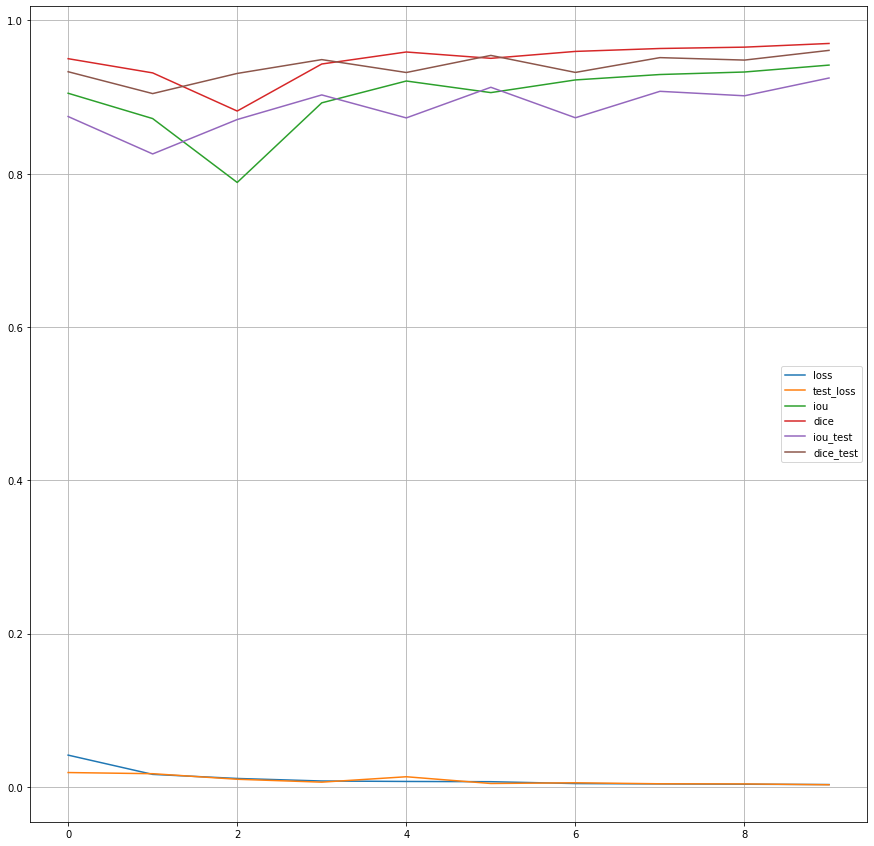

In [30]:
#10 epocas
df = pd.DataFrame(hist)
df.plot(grid=True, figsize=(15,15))
plt.show()


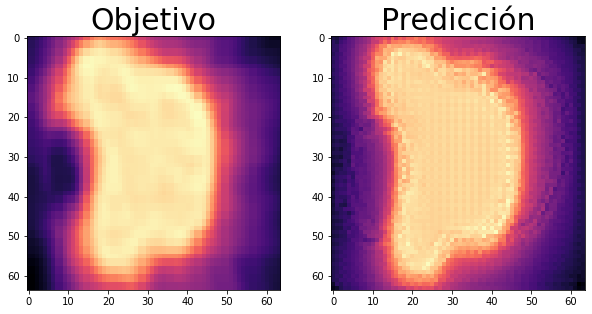

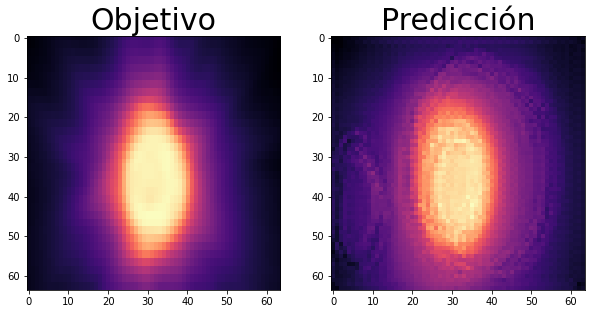

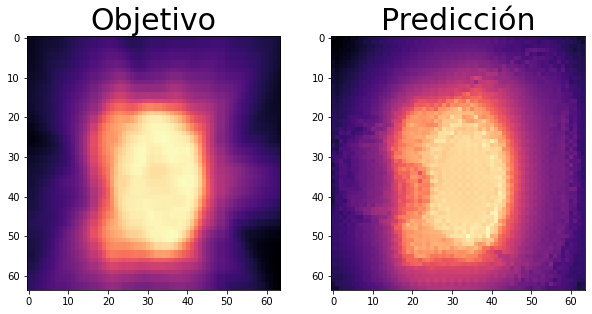

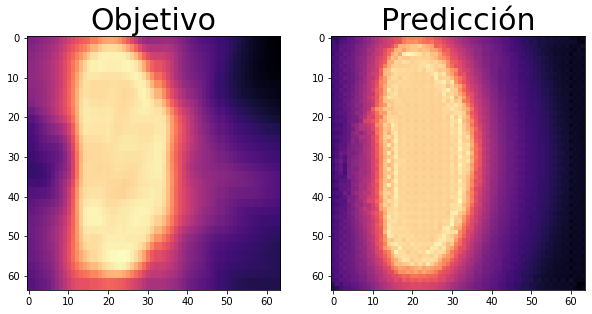

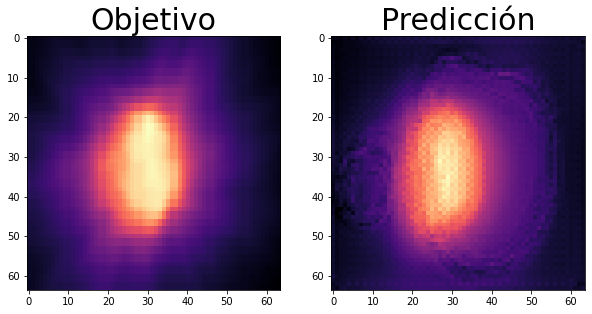

In [31]:
#10 epocas

for i in range(5):
    model.eval()
    with torch.no_grad():
        ix = random.randint(0, len(dataset['test'])-1)
        img, mask = dataset['test'][ix]
        output = model(img.unsqueeze(0).to(device, dtype=torch.float))[0]
        pred_mask = output

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        ax1.set_title('Objetivo', fontsize=30)
        ax1.imshow(mask[:,:,:,29].permute(1,2,0),cmap="magma")
        ax2.set_title('Predicción', fontsize=30)
        ax2.imshow(pred_mask.squeeze().cpu().numpy()[:,:,29],cmap="magma")
        plt.show()
 

## * Entrenamiento de 100 épocas con torch.nn.MSELoss

In [37]:
device = torch.device('cuda')
model = UNet()
hist = fit(model, dataloader, epochs=100)


Epoch 1/100


test_loss 0.01614 iou 0.848 dice 0.917 i 0.98968: 100%|█████████████████████████████████| 15/15 [00:03<00:00,  4.54it/s]



Epoch 2/100


test_loss 0.00952 iou 0.882 dice 0.938 i 0.99225: 100%|█████████████████████████████████| 15/15 [00:03<00:00,  4.61it/s]



Epoch 3/100


test_loss 0.00938 iou 0.892 dice 0.943 i 0.99446: 100%|█████████████████████████████████| 15/15 [00:03<00:00,  4.52it/s]



Epoch 4/100


test_loss 0.00704 iou 0.917 dice 0.957 i 0.99671: 100%|█████████████████████████████████| 15/15 [00:03<00:00,  4.37it/s]



Epoch 5/100


test_loss 0.00865 iou 0.911 dice 0.954 i 0.99206: 100%|█████████████████████████████████| 15/15 [00:03<00:00,  4.34it/s]



Epoch 6/100


test_loss 0.00575 iou 0.896 dice 0.945 i 0.99515: 100%|█████████████████████████████████| 15/15 [00:03<00:00,  4.47it/s]



Epoch 7/100


test_loss 0.00320 iou 0.917 dice 0.957 i 0.99722: 100%|█████████████████████████████████| 15/15 [00:03<00:00,  4.36it/s]



Epoch 8/100


test_loss 0.00312 iou 0.912 dice 0.954 i 0.99710: 100%|█████████████████████████████████| 15/15 [00:03<00:00,  4.39it/s]



Epoch 9/100


test_loss 0.00300 iou 0.924 dice 0.961 i 0.99740: 100%|█████████████████████████████████| 15/15 [00:03<00:00,  4.23it/s]



Epoch 10/100


test_loss 0.00291 iou 0.910 dice 0.953 i 0.99701: 100%|█████████████████████████████████| 15/15 [00:03<00:00,  4.37it/s]



Epoch 11/100


test_loss 0.00238 iou 0.925 dice 0.961 i 0.99761: 100%|█████████████████████████████████| 15/15 [00:03<00:00,  4.27it/s]



Epoch 12/100


test_loss 0.00264 iou 0.922 dice 0.959 i 0.99745: 100%|█████████████████████████████████| 15/15 [00:03<00:00,  4.29it/s]



Epoch 13/100


test_loss 0.00267 iou 0.925 dice 0.961 i 0.99731: 100%|█████████████████████████████████| 15/15 [00:03<00:00,  3.79it/s]



Epoch 14/100


test_loss 0.00359 iou 0.918 dice 0.957 i 0.99635: 100%|█████████████████████████████████| 15/15 [00:03<00:00,  4.34it/s]



Epoch 15/100


test_loss 0.00278 iou 0.924 dice 0.960 i 0.99713: 100%|█████████████████████████████████| 15/15 [00:03<00:00,  4.22it/s]



Epoch 16/100


test_loss 0.00216 iou 0.917 dice 0.957 i 0.99782: 100%|█████████████████████████████████| 15/15 [00:03<00:00,  4.03it/s]



Epoch 17/100


test_loss 0.00251 iou 0.921 dice 0.959 i 0.99788: 100%|█████████████████████████████████| 15/15 [00:04<00:00,  3.64it/s]



Epoch 18/100


test_loss 0.00204 iou 0.925 dice 0.961 i 0.99791: 100%|█████████████████████████████████| 15/15 [00:03<00:00,  4.40it/s]



Epoch 19/100


test_loss 0.00234 iou 0.920 dice 0.958 i 0.99759: 100%|█████████████████████████████████| 15/15 [00:03<00:00,  4.08it/s]



Epoch 20/100


test_loss 0.00273 iou 0.926 dice 0.961 i 0.99701: 100%|█████████████████████████████████| 15/15 [00:03<00:00,  4.40it/s]



Epoch 21/100


loss 0.00387 iou 0.906 dice 0.950 i 0.99230: 100%|██████████████████████████████████████| 90/90 [00:24<00:00,  3.66it/s]
test_loss 1.24474 iou 0.198 dice 0.330 i -0.33599: 100%|████████████████████████████████| 15/15 [00:03<00:00,  4.16it/s]



Epoch 22/100


test_loss 0.00782 iou 0.901 dice 0.948 i 0.99228: 100%|█████████████████████████████████| 15/15 [00:03<00:00,  3.97it/s]



Epoch 23/100


test_loss 0.00897 iou 0.890 dice 0.942 i 0.99369: 100%|█████████████████████████████████| 15/15 [00:03<00:00,  4.37it/s]



Epoch 24/100


test_loss 0.00591 iou 0.887 dice 0.940 i 0.99463: 100%|█████████████████████████████████| 15/15 [00:03<00:00,  4.15it/s]



Epoch 25/100


test_loss 0.00294 iou 0.921 dice 0.959 i 0.99737: 100%|█████████████████████████████████| 15/15 [00:03<00:00,  4.37it/s]



Epoch 26/100


test_loss 0.00231 iou 0.917 dice 0.957 i 0.99775: 100%|█████████████████████████████████| 15/15 [00:03<00:00,  4.34it/s]



Epoch 27/100


test_loss 0.00222 iou 0.927 dice 0.962 i 0.99807: 100%|█████████████████████████████████| 15/15 [00:03<00:00,  4.12it/s]



Epoch 28/100


test_loss 0.00217 iou 0.925 dice 0.961 i 0.99771: 100%|█████████████████████████████████| 15/15 [00:03<00:00,  4.18it/s]



Epoch 29/100


test_loss 0.00212 iou 0.925 dice 0.961 i 0.99774: 100%|█████████████████████████████████| 15/15 [00:03<00:00,  4.23it/s]



Epoch 30/100


test_loss 0.00199 iou 0.928 dice 0.963 i 0.99806: 100%|█████████████████████████████████| 15/15 [00:03<00:00,  4.30it/s]



Epoch 31/100


test_loss 0.00209 iou 0.924 dice 0.960 i 0.99794: 100%|█████████████████████████████████| 15/15 [00:03<00:00,  4.30it/s]



Epoch 32/100


test_loss 0.00184 iou 0.928 dice 0.963 i 0.99793: 100%|█████████████████████████████████| 15/15 [00:03<00:00,  4.28it/s]



Epoch 33/100


test_loss 0.00184 iou 0.931 dice 0.964 i 0.99812: 100%|█████████████████████████████████| 15/15 [00:03<00:00,  4.22it/s]



Epoch 34/100


test_loss 0.00173 iou 0.930 dice 0.964 i 0.99816: 100%|█████████████████████████████████| 15/15 [00:03<00:00,  4.25it/s]



Epoch 35/100


test_loss 0.00182 iou 0.930 dice 0.964 i 0.99809: 100%|█████████████████████████████████| 15/15 [00:03<00:00,  4.19it/s]



Epoch 36/100


test_loss 0.00194 iou 0.924 dice 0.961 i 0.99792: 100%|█████████████████████████████████| 15/15 [00:03<00:00,  4.01it/s]



Epoch 37/100


test_loss 0.00167 iou 0.930 dice 0.964 i 0.99827: 100%|█████████████████████████████████| 15/15 [00:03<00:00,  3.93it/s]



Epoch 38/100


test_loss 0.00177 iou 0.931 dice 0.964 i 0.99804: 100%|█████████████████████████████████| 15/15 [00:03<00:00,  4.00it/s]



Epoch 39/100


test_loss 0.00205 iou 0.926 dice 0.962 i 0.99779: 100%|█████████████████████████████████| 15/15 [00:03<00:00,  4.34it/s]



Epoch 40/100


test_loss 0.00177 iou 0.934 dice 0.966 i 0.99831: 100%|█████████████████████████████████| 15/15 [00:03<00:00,  4.28it/s]



Epoch 41/100


test_loss 0.00192 iou 0.928 dice 0.963 i 0.99803: 100%|█████████████████████████████████| 15/15 [00:03<00:00,  4.35it/s]



Epoch 42/100


test_loss 0.00183 iou 0.928 dice 0.963 i 0.99821: 100%|█████████████████████████████████| 15/15 [00:03<00:00,  4.22it/s]



Epoch 43/100


test_loss 0.00198 iou 0.928 dice 0.963 i 0.99779: 100%|█████████████████████████████████| 15/15 [00:03<00:00,  4.27it/s]



Epoch 44/100


test_loss 0.00162 iou 0.932 dice 0.965 i 0.99828: 100%|█████████████████████████████████| 15/15 [00:03<00:00,  4.30it/s]



Epoch 45/100


test_loss 0.00166 iou 0.925 dice 0.961 i 0.99805: 100%|█████████████████████████████████| 15/15 [00:03<00:00,  4.46it/s]



Epoch 46/100


test_loss 0.00180 iou 0.919 dice 0.958 i 0.99785: 100%|█████████████████████████████████| 15/15 [00:03<00:00,  4.20it/s]



Epoch 47/100


test_loss 0.00163 iou 0.929 dice 0.963 i 0.99816: 100%|█████████████████████████████████| 15/15 [00:03<00:00,  4.31it/s]



Epoch 48/100


test_loss 0.00155 iou 0.931 dice 0.964 i 0.99823: 100%|█████████████████████████████████| 15/15 [00:03<00:00,  4.01it/s]



Epoch 49/100


test_loss 0.00155 iou 0.934 dice 0.966 i 0.99834: 100%|█████████████████████████████████| 15/15 [00:03<00:00,  4.31it/s]



Epoch 50/100


test_loss 0.00183 iou 0.934 dice 0.966 i 0.99814: 100%|█████████████████████████████████| 15/15 [00:03<00:00,  4.29it/s]



Epoch 51/100


test_loss 0.00192 iou 0.928 dice 0.963 i 0.99788: 100%|█████████████████████████████████| 15/15 [00:03<00:00,  4.30it/s]



Epoch 52/100


test_loss 0.00172 iou 0.932 dice 0.965 i 0.99828: 100%|█████████████████████████████████| 15/15 [00:03<00:00,  4.15it/s]



Epoch 53/100


test_loss 0.00165 iou 0.928 dice 0.963 i 0.99812: 100%|█████████████████████████████████| 15/15 [00:03<00:00,  4.32it/s]



Epoch 54/100


test_loss 0.00146 iou 0.933 dice 0.966 i 0.99836: 100%|█████████████████████████████████| 15/15 [00:03<00:00,  3.93it/s]



Epoch 55/100


test_loss 0.00272 iou 0.918 dice 0.957 i 0.99723: 100%|█████████████████████████████████| 15/15 [00:03<00:00,  4.27it/s]



Epoch 56/100


test_loss 0.00210 iou 0.925 dice 0.961 i 0.99798: 100%|█████████████████████████████████| 15/15 [00:03<00:00,  4.21it/s]



Epoch 57/100


test_loss 0.00159 iou 0.929 dice 0.963 i 0.99819: 100%|█████████████████████████████████| 15/15 [00:03<00:00,  4.31it/s]



Epoch 58/100


test_loss 0.00140 iou 0.935 dice 0.966 i 0.99836: 100%|█████████████████████████████████| 15/15 [00:03<00:00,  3.97it/s]



Epoch 59/100


test_loss 0.00159 iou 0.933 dice 0.965 i 0.99830: 100%|█████████████████████████████████| 15/15 [00:03<00:00,  4.41it/s]



Epoch 60/100


test_loss 0.00147 iou 0.933 dice 0.965 i 0.99832: 100%|█████████████████████████████████| 15/15 [00:03<00:00,  3.99it/s]



Epoch 61/100


test_loss 0.00150 iou 0.935 dice 0.967 i 0.99838: 100%|█████████████████████████████████| 15/15 [00:03<00:00,  4.35it/s]



Epoch 62/100


test_loss 0.00144 iou 0.933 dice 0.965 i 0.99833: 100%|█████████████████████████████████| 15/15 [00:03<00:00,  4.25it/s]



Epoch 63/100


test_loss 0.00152 iou 0.932 dice 0.965 i 0.99837: 100%|█████████████████████████████████| 15/15 [00:03<00:00,  4.18it/s]



Epoch 64/100


test_loss 0.00134 iou 0.936 dice 0.967 i 0.99850: 100%|█████████████████████████████████| 15/15 [00:03<00:00,  4.33it/s]



Epoch 65/100


test_loss 0.00162 iou 0.933 dice 0.965 i 0.99811: 100%|█████████████████████████████████| 15/15 [00:03<00:00,  4.09it/s]



Epoch 66/100


test_loss 0.00141 iou 0.935 dice 0.966 i 0.99847: 100%|█████████████████████████████████| 15/15 [00:03<00:00,  4.27it/s]



Epoch 67/100


test_loss 0.00144 iou 0.932 dice 0.965 i 0.99823: 100%|█████████████████████████████████| 15/15 [00:03<00:00,  4.13it/s]



Epoch 68/100


test_loss 0.00139 iou 0.934 dice 0.966 i 0.99840: 100%|█████████████████████████████████| 15/15 [00:07<00:00,  1.93it/s]



Epoch 69/100


test_loss 0.00144 iou 0.933 dice 0.965 i 0.99839: 100%|█████████████████████████████████| 15/15 [00:07<00:00,  1.94it/s]



Epoch 70/100


test_loss 0.00164 iou 0.929 dice 0.963 i 0.99821: 100%|█████████████████████████████████| 15/15 [00:07<00:00,  1.91it/s]



Epoch 71/100


test_loss 0.00143 iou 0.936 dice 0.967 i 0.99839: 100%|█████████████████████████████████| 15/15 [00:08<00:00,  1.83it/s]



Epoch 72/100


test_loss 0.00142 iou 0.934 dice 0.966 i 0.99839: 100%|█████████████████████████████████| 15/15 [00:07<00:00,  1.90it/s]



Epoch 73/100


test_loss 0.00156 iou 0.930 dice 0.964 i 0.99827: 100%|█████████████████████████████████| 15/15 [00:07<00:00,  1.89it/s]



Epoch 74/100


test_loss 0.00165 iou 0.933 dice 0.966 i 0.99828: 100%|█████████████████████████████████| 15/15 [00:07<00:00,  1.92it/s]



Epoch 75/100


test_loss 0.00137 iou 0.937 dice 0.967 i 0.99848: 100%|█████████████████████████████████| 15/15 [00:07<00:00,  1.90it/s]



Epoch 76/100


test_loss 0.00141 iou 0.931 dice 0.964 i 0.99835: 100%|█████████████████████████████████| 15/15 [00:08<00:00,  1.82it/s]



Epoch 77/100


test_loss 0.00157 iou 0.936 dice 0.967 i 0.99812: 100%|█████████████████████████████████| 15/15 [00:07<00:00,  1.89it/s]



Epoch 78/100


test_loss 0.00140 iou 0.934 dice 0.966 i 0.99842: 100%|█████████████████████████████████| 15/15 [00:07<00:00,  1.90it/s]



Epoch 79/100


test_loss 0.00137 iou 0.936 dice 0.967 i 0.99840: 100%|█████████████████████████████████| 15/15 [00:07<00:00,  1.92it/s]



Epoch 80/100


test_loss 0.00134 iou 0.932 dice 0.965 i 0.99836: 100%|█████████████████████████████████| 15/15 [00:07<00:00,  1.90it/s]



Epoch 81/100


test_loss 0.00142 iou 0.934 dice 0.966 i 0.99840: 100%|█████████████████████████████████| 15/15 [00:07<00:00,  1.89it/s]



Epoch 82/100


test_loss 0.00140 iou 0.935 dice 0.966 i 0.99843: 100%|█████████████████████████████████| 15/15 [00:07<00:00,  1.88it/s]



Epoch 83/100


test_loss 0.00160 iou 0.928 dice 0.963 i 0.99831: 100%|█████████████████████████████████| 15/15 [00:07<00:00,  1.91it/s]



Epoch 84/100


test_loss 0.00125 iou 0.939 dice 0.968 i 0.99852: 100%|█████████████████████████████████| 15/15 [00:07<00:00,  1.90it/s]



Epoch 85/100


test_loss 0.00135 iou 0.934 dice 0.966 i 0.99833: 100%|█████████████████████████████████| 15/15 [00:07<00:00,  1.92it/s]



Epoch 86/100


test_loss 0.00133 iou 0.937 dice 0.967 i 0.99848: 100%|█████████████████████████████████| 15/15 [00:08<00:00,  1.85it/s]



Epoch 87/100


test_loss 0.00143 iou 0.939 dice 0.969 i 0.99832: 100%|█████████████████████████████████| 15/15 [00:07<00:00,  1.93it/s]



Epoch 88/100


test_loss 0.00132 iou 0.936 dice 0.967 i 0.99845: 100%|█████████████████████████████████| 15/15 [00:07<00:00,  1.94it/s]



Epoch 89/100


test_loss 0.00128 iou 0.937 dice 0.968 i 0.99851: 100%|█████████████████████████████████| 15/15 [00:07<00:00,  1.91it/s]



Epoch 90/100


test_loss 0.00131 iou 0.937 dice 0.967 i 0.99848: 100%|█████████████████████████████████| 15/15 [00:07<00:00,  1.93it/s]



Epoch 91/100


test_loss 0.00132 iou 0.935 dice 0.966 i 0.99840: 100%|█████████████████████████████████| 15/15 [00:07<00:00,  1.89it/s]



Epoch 92/100


test_loss 0.00143 iou 0.937 dice 0.968 i 0.99834: 100%|█████████████████████████████████| 15/15 [00:07<00:00,  1.92it/s]



Epoch 93/100


test_loss 0.00137 iou 0.938 dice 0.968 i 0.99844: 100%|█████████████████████████████████| 15/15 [00:07<00:00,  1.89it/s]



Epoch 94/100


test_loss 0.00146 iou 0.935 dice 0.966 i 0.99840: 100%|█████████████████████████████████| 15/15 [00:07<00:00,  1.91it/s]



Epoch 95/100


test_loss 0.02068 iou 0.820 dice 0.901 i 0.97923: 100%|█████████████████████████████████| 15/15 [00:07<00:00,  1.89it/s]



Epoch 96/100


test_loss 0.00366 iou 0.920 dice 0.959 i 0.99742: 100%|█████████████████████████████████| 15/15 [00:07<00:00,  1.90it/s]



Epoch 97/100


test_loss 0.00236 iou 0.922 dice 0.960 i 0.99785: 100%|█████████████████████████████████| 15/15 [00:07<00:00,  1.89it/s]



Epoch 98/100


test_loss 0.00184 iou 0.927 dice 0.962 i 0.99812: 100%|█████████████████████████████████| 15/15 [00:08<00:00,  1.82it/s]



Epoch 99/100


test_loss 0.00164 iou 0.927 dice 0.962 i 0.99804: 100%|█████████████████████████████████| 15/15 [00:07<00:00,  1.89it/s]



Epoch 100/100


test_loss 0.00153 iou 0.933 dice 0.965 i 0.99831: 100%|█████████████████████████████████| 15/15 [00:07<00:00,  1.88it/s]


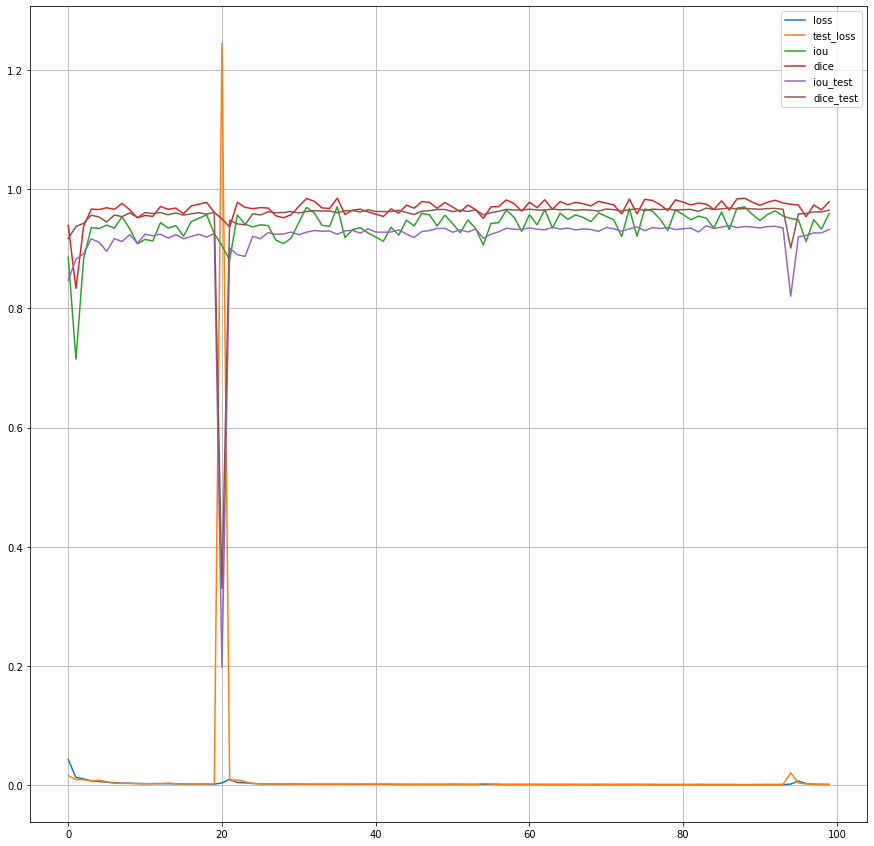

In [41]:
#100 epocas
df = pd.DataFrame(hist)
df.plot(grid=True, figsize=(15,15))
plt.show()

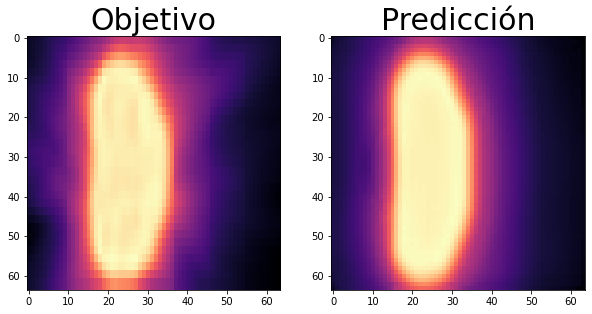

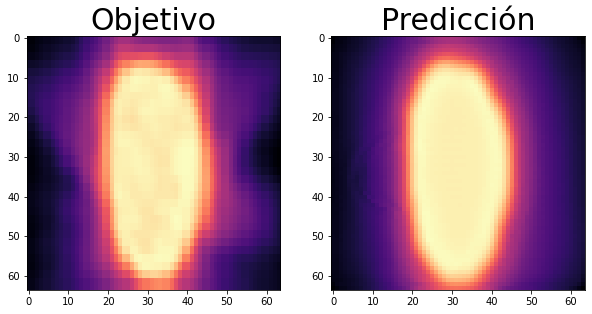

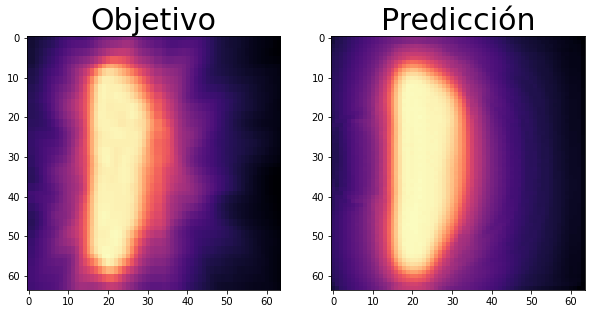

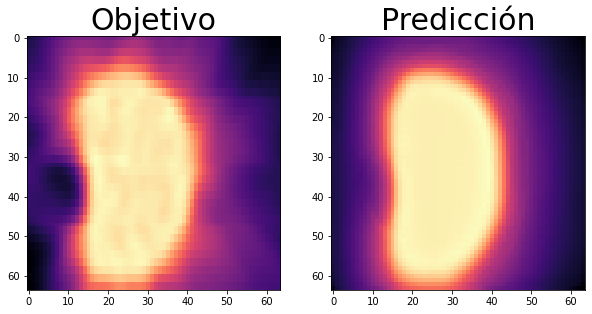

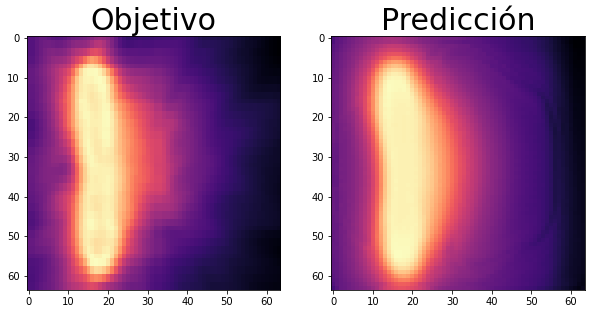

In [42]:
#100 epocas

for i in range(5):
    model.eval()
    with torch.no_grad():
        ix = random.randint(0, len(dataset['test'])-1)
        img, mask = dataset['test'][ix]
        output = model(img.unsqueeze(0).to(device, dtype=torch.float))[0]
        pred_mask = output

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        ax1.set_title('Objetivo', fontsize=30)
        ax1.imshow(mask[:,:,:,29].permute(1,2,0),cmap="magma")
        ax2.set_title('Predicción', fontsize=30)
        ax2.imshow(pred_mask.squeeze().cpu().numpy()[:,:,29],cmap="magma")
        plt.show()

## * Entrenamiento de 250 épocas con torch.nn.MSELoss

In [20]:
device = torch.device('cuda')
model = UNet()
hist = fit(model, dataloader, epochs=250)


Epoch 1/250


test_loss 0.02386 iou 0.851 dice 0.919 i 0.98307: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.43it/s]



Epoch 2/250


test_loss 0.01222 iou 0.899 dice 0.947 i 0.99338: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.47it/s]



Epoch 3/250


test_loss 0.00899 iou 0.916 dice 0.956 i 0.99582: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.46it/s]



Epoch 4/250


test_loss 0.02469 iou 0.858 dice 0.923 i 0.98602: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.43it/s]



Epoch 5/250


test_loss 0.00875 iou 0.900 dice 0.947 i 0.99578: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.63it/s]



Epoch 6/250


test_loss 0.00541 iou 0.906 dice 0.951 i 0.99551: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.43it/s]



Epoch 7/250


test_loss 0.00399 iou 0.926 dice 0.961 i 0.99705: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.43it/s]



Epoch 8/250


test_loss 0.00343 iou 0.924 dice 0.960 i 0.99711: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.51it/s]



Epoch 9/250


test_loss 0.00310 iou 0.927 dice 0.962 i 0.99752: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.37it/s]



Epoch 10/250


test_loss 0.00270 iou 0.928 dice 0.963 i 0.99769: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.41it/s]



Epoch 11/250


test_loss 0.00245 iou 0.926 dice 0.961 i 0.99792: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.47it/s]



Epoch 12/250


test_loss 0.00457 iou 0.913 dice 0.954 i 0.99596: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.47it/s]



Epoch 13/250


test_loss 0.00228 iou 0.931 dice 0.964 i 0.99796: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.43it/s]



Epoch 14/250


test_loss 0.00250 iou 0.928 dice 0.963 i 0.99760: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.49it/s]



Epoch 15/250


test_loss 0.00703 iou 0.906 dice 0.950 i 0.99632: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.45it/s]



Epoch 16/250


test_loss 0.00662 iou 0.908 dice 0.952 i 0.99463: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.49it/s]



Epoch 17/250


test_loss 0.00564 iou 0.924 dice 0.961 i 0.99733: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.39it/s]



Epoch 18/250


test_loss 0.00298 iou 0.929 dice 0.963 i 0.99735: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.43it/s]



Epoch 19/250


test_loss 0.00265 iou 0.923 dice 0.960 i 0.99762: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.44it/s]



Epoch 20/250


test_loss 0.00229 iou 0.928 dice 0.963 i 0.99799: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.49it/s]



Epoch 21/250


test_loss 0.00247 iou 0.933 dice 0.965 i 0.99804: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.42it/s]



Epoch 22/250


test_loss 0.00242 iou 0.930 dice 0.963 i 0.99790: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.49it/s]



Epoch 23/250


test_loss 0.00207 iou 0.931 dice 0.964 i 0.99814: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.65it/s]



Epoch 24/250


test_loss 0.00202 iou 0.931 dice 0.964 i 0.99807: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.46it/s]



Epoch 25/250


test_loss 0.00206 iou 0.925 dice 0.961 i 0.99777: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.50it/s]



Epoch 26/250


test_loss 0.00235 iou 0.927 dice 0.962 i 0.99779: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.56it/s]



Epoch 27/250


test_loss 0.00229 iou 0.917 dice 0.957 i 0.99735: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.41it/s]



Epoch 28/250


test_loss 0.00212 iou 0.926 dice 0.961 i 0.99765: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.43it/s]



Epoch 29/250


test_loss 0.00211 iou 0.935 dice 0.967 i 0.99809: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.44it/s]



Epoch 30/250


test_loss 0.00176 iou 0.931 dice 0.964 i 0.99809: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.45it/s]



Epoch 31/250


test_loss 0.00187 iou 0.923 dice 0.960 i 0.99794: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.40it/s]



Epoch 32/250


test_loss 0.00179 iou 0.926 dice 0.961 i 0.99805: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.43it/s]



Epoch 33/250


test_loss 0.00167 iou 0.937 dice 0.967 i 0.99844: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.53it/s]



Epoch 34/250


test_loss 0.00183 iou 0.932 dice 0.965 i 0.99808: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.42it/s]



Epoch 35/250


test_loss 0.00186 iou 0.929 dice 0.963 i 0.99801: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.49it/s]



Epoch 36/250


test_loss 0.00178 iou 0.937 dice 0.968 i 0.99831: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.40it/s]



Epoch 37/250


test_loss 0.00177 iou 0.936 dice 0.967 i 0.99838: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.40it/s]



Epoch 38/250


test_loss 0.00177 iou 0.934 dice 0.966 i 0.99820: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.35it/s]



Epoch 39/250


test_loss 0.00189 iou 0.932 dice 0.965 i 0.99819: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.50it/s]



Epoch 40/250


test_loss 0.00209 iou 0.929 dice 0.963 i 0.99818: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.43it/s]



Epoch 41/250


test_loss 0.00162 iou 0.931 dice 0.964 i 0.99831: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.42it/s]



Epoch 42/250


test_loss 0.01421 iou 0.778 dice 0.875 i 0.98853: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.45it/s]



Epoch 43/250


test_loss 0.00882 iou 0.902 dice 0.948 i 0.99439: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.51it/s]



Epoch 44/250


test_loss 0.00353 iou 0.929 dice 0.963 i 0.99768: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.57it/s]



Epoch 45/250


test_loss 0.00226 iou 0.927 dice 0.962 i 0.99789: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.45it/s]



Epoch 46/250


test_loss 0.00218 iou 0.936 dice 0.967 i 0.99813: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.42it/s]



Epoch 47/250


test_loss 0.00206 iou 0.927 dice 0.962 i 0.99802: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.42it/s]



Epoch 48/250


test_loss 0.00209 iou 0.915 dice 0.956 i 0.99754: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.41it/s]



Epoch 49/250


test_loss 0.00179 iou 0.938 dice 0.968 i 0.99840: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.40it/s]



Epoch 50/250


test_loss 0.00200 iou 0.929 dice 0.963 i 0.99786: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.42it/s]



Epoch 51/250


test_loss 0.00177 iou 0.936 dice 0.967 i 0.99829: 100%|█████████████████████████████████| 30/30 [00:09<00:00,  3.30it/s]



Epoch 52/250


test_loss 0.00162 iou 0.934 dice 0.966 i 0.99826: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.50it/s]



Epoch 53/250


test_loss 0.00167 iou 0.933 dice 0.965 i 0.99816: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.45it/s]



Epoch 54/250


test_loss 0.00190 iou 0.938 dice 0.968 i 0.99831: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.49it/s]



Epoch 55/250


test_loss 0.00159 iou 0.933 dice 0.965 i 0.99829: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.57it/s]



Epoch 56/250


test_loss 0.00169 iou 0.931 dice 0.964 i 0.99825: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.45it/s]



Epoch 57/250


test_loss 0.00160 iou 0.938 dice 0.968 i 0.99834: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.46it/s]



Epoch 58/250


test_loss 0.00149 iou 0.941 dice 0.969 i 0.99845: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.53it/s]



Epoch 59/250


test_loss 0.00163 iou 0.930 dice 0.964 i 0.99835: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.45it/s]



Epoch 60/250


test_loss 0.00160 iou 0.934 dice 0.966 i 0.99834: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.50it/s]



Epoch 61/250


test_loss 0.00150 iou 0.934 dice 0.966 i 0.99832: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.52it/s]



Epoch 62/250


test_loss 0.00152 iou 0.938 dice 0.968 i 0.99838: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.50it/s]



Epoch 63/250


test_loss 0.00152 iou 0.939 dice 0.968 i 0.99844: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.40it/s]



Epoch 64/250


test_loss 0.00161 iou 0.932 dice 0.965 i 0.99808: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.44it/s]



Epoch 65/250


test_loss 0.00157 iou 0.936 dice 0.967 i 0.99830: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.47it/s]



Epoch 66/250


test_loss 0.00145 iou 0.935 dice 0.966 i 0.99840: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.47it/s]



Epoch 67/250


test_loss 0.00148 iou 0.936 dice 0.967 i 0.99831: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.53it/s]



Epoch 68/250


test_loss 0.00197 iou 0.936 dice 0.967 i 0.99772: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.41it/s]



Epoch 69/250


test_loss 0.00169 iou 0.940 dice 0.969 i 0.99837: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.43it/s]



Epoch 70/250


test_loss 0.00136 iou 0.941 dice 0.970 i 0.99850: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.46it/s]



Epoch 71/250


test_loss 0.00157 iou 0.933 dice 0.966 i 0.99816: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.45it/s]



Epoch 72/250


test_loss 0.00144 iou 0.937 dice 0.968 i 0.99847: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.44it/s]



Epoch 73/250


test_loss 0.00136 iou 0.940 dice 0.969 i 0.99851: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.49it/s]



Epoch 74/250


test_loss 0.00138 iou 0.938 dice 0.968 i 0.99851: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.52it/s]



Epoch 75/250


test_loss 0.00142 iou 0.939 dice 0.968 i 0.99846: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.46it/s]



Epoch 76/250


test_loss 0.00157 iou 0.934 dice 0.966 i 0.99836: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.47it/s]



Epoch 77/250


test_loss 0.00157 iou 0.931 dice 0.964 i 0.99818: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.41it/s]



Epoch 78/250


test_loss 0.00141 iou 0.941 dice 0.969 i 0.99854: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.44it/s]



Epoch 79/250


test_loss 0.00147 iou 0.937 dice 0.967 i 0.99838: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.37it/s]



Epoch 80/250


test_loss 0.00146 iou 0.940 dice 0.969 i 0.99847: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.50it/s]



Epoch 81/250


test_loss 0.00139 iou 0.936 dice 0.967 i 0.99843: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.46it/s]



Epoch 82/250


test_loss 0.00141 iou 0.935 dice 0.966 i 0.99842: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.44it/s]



Epoch 83/250


test_loss 0.00127 iou 0.939 dice 0.968 i 0.99856: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.55it/s]



Epoch 84/250


test_loss 0.00172 iou 0.930 dice 0.964 i 0.99798: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.49it/s]



Epoch 85/250


test_loss 0.00151 iou 0.935 dice 0.966 i 0.99833: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.47it/s]



Epoch 86/250


test_loss 0.00135 iou 0.942 dice 0.970 i 0.99859: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.46it/s]



Epoch 87/250


test_loss 0.00141 iou 0.938 dice 0.968 i 0.99842: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.40it/s]



Epoch 88/250


test_loss 0.00141 iou 0.939 dice 0.969 i 0.99843: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.40it/s]



Epoch 89/250


test_loss 0.00130 iou 0.940 dice 0.969 i 0.99854: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.50it/s]



Epoch 90/250


test_loss 0.00143 iou 0.943 dice 0.971 i 0.99855: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.42it/s]



Epoch 91/250


test_loss 0.00153 iou 0.937 dice 0.968 i 0.99830: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.46it/s]



Epoch 92/250


test_loss 0.00129 iou 0.940 dice 0.969 i 0.99851: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.47it/s]



Epoch 93/250


test_loss 0.00128 iou 0.938 dice 0.968 i 0.99850: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.44it/s]



Epoch 94/250


test_loss 0.00160 iou 0.941 dice 0.970 i 0.99827: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.43it/s]



Epoch 95/250


test_loss 0.00141 iou 0.937 dice 0.967 i 0.99841: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.43it/s]



Epoch 96/250


test_loss 0.00133 iou 0.937 dice 0.968 i 0.99856: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.49it/s]



Epoch 97/250


test_loss 0.00138 iou 0.936 dice 0.967 i 0.99843: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.42it/s]



Epoch 98/250


test_loss 0.00131 iou 0.941 dice 0.970 i 0.99844: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.43it/s]



Epoch 99/250


test_loss 0.00122 iou 0.940 dice 0.969 i 0.99858: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.41it/s]



Epoch 100/250


test_loss 0.00140 iou 0.937 dice 0.968 i 0.99842: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.45it/s]



Epoch 101/250


test_loss 0.00145 iou 0.939 dice 0.969 i 0.99833: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.49it/s]



Epoch 102/250


test_loss 0.00128 iou 0.939 dice 0.969 i 0.99845: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.47it/s]



Epoch 103/250


test_loss 0.00141 iou 0.938 dice 0.968 i 0.99836: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.47it/s]



Epoch 104/250


test_loss 0.00122 iou 0.943 dice 0.970 i 0.99859: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.40it/s]



Epoch 105/250


test_loss 0.00130 iou 0.939 dice 0.969 i 0.99842: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.53it/s]



Epoch 106/250


test_loss 0.00163 iou 0.935 dice 0.966 i 0.99825: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.50it/s]



Epoch 107/250


test_loss 0.00736 iou 0.918 dice 0.957 i 0.99578: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.47it/s]



Epoch 108/250


test_loss 0.00209 iou 0.932 dice 0.965 i 0.99819: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.48it/s]



Epoch 109/250


test_loss 0.00161 iou 0.933 dice 0.965 i 0.99832: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.39it/s]



Epoch 110/250


test_loss 0.00143 iou 0.938 dice 0.968 i 0.99846: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.47it/s]



Epoch 111/250


test_loss 0.00140 iou 0.936 dice 0.967 i 0.99840: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.45it/s]



Epoch 112/250


test_loss 0.00127 iou 0.941 dice 0.970 i 0.99861: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.52it/s]



Epoch 113/250


test_loss 0.00127 iou 0.938 dice 0.968 i 0.99856: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.48it/s]



Epoch 114/250


test_loss 0.00147 iou 0.937 dice 0.968 i 0.99829: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.49it/s]



Epoch 115/250


test_loss 0.00126 iou 0.939 dice 0.968 i 0.99847: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.49it/s]



Epoch 116/250


test_loss 0.00121 iou 0.939 dice 0.969 i 0.99849: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.45it/s]



Epoch 117/250


test_loss 0.00127 iou 0.941 dice 0.970 i 0.99851: 100%|█████████████████████████████████| 30/30 [00:09<00:00,  3.32it/s]



Epoch 118/250


test_loss 0.00123 iou 0.936 dice 0.967 i 0.99849: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.45it/s]



Epoch 119/250


test_loss 0.00123 iou 0.939 dice 0.968 i 0.99852: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.47it/s]



Epoch 120/250


test_loss 0.00126 iou 0.937 dice 0.968 i 0.99847: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.45it/s]



Epoch 121/250


test_loss 0.00121 iou 0.939 dice 0.968 i 0.99848: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.41it/s]



Epoch 122/250


test_loss 0.00120 iou 0.941 dice 0.970 i 0.99853: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.43it/s]



Epoch 123/250


test_loss 0.00117 iou 0.940 dice 0.969 i 0.99851: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.53it/s]



Epoch 124/250


test_loss 0.00123 iou 0.941 dice 0.970 i 0.99855: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.46it/s]



Epoch 125/250


test_loss 0.00124 iou 0.938 dice 0.968 i 0.99847: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.46it/s]



Epoch 126/250


test_loss 0.00125 iou 0.939 dice 0.969 i 0.99853: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.40it/s]



Epoch 127/250


test_loss 0.00124 iou 0.937 dice 0.967 i 0.99845: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.44it/s]



Epoch 128/250


test_loss 0.00116 iou 0.941 dice 0.969 i 0.99858: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.51it/s]



Epoch 129/250


test_loss 0.00120 iou 0.937 dice 0.967 i 0.99848: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.41it/s]



Epoch 130/250


test_loss 0.00123 iou 0.938 dice 0.968 i 0.99841: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.48it/s]



Epoch 131/250


test_loss 0.00119 iou 0.940 dice 0.969 i 0.99846: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.42it/s]



Epoch 132/250


test_loss 0.00135 iou 0.936 dice 0.967 i 0.99830: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.43it/s]



Epoch 133/250


test_loss 0.00117 iou 0.940 dice 0.969 i 0.99851: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.44it/s]



Epoch 134/250


test_loss 0.00133 iou 0.939 dice 0.968 i 0.99843: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.41it/s]



Epoch 135/250


test_loss 0.00139 iou 0.942 dice 0.970 i 0.99839: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.45it/s]



Epoch 136/250


test_loss 0.00121 iou 0.939 dice 0.969 i 0.99847: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.38it/s]



Epoch 137/250


test_loss 0.00122 iou 0.937 dice 0.968 i 0.99849: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.40it/s]



Epoch 138/250


test_loss 0.00120 iou 0.941 dice 0.970 i 0.99849: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.46it/s]



Epoch 139/250


test_loss 0.00122 iou 0.941 dice 0.970 i 0.99852: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.50it/s]



Epoch 140/250


test_loss 0.00117 iou 0.938 dice 0.968 i 0.99845: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.48it/s]



Epoch 141/250


test_loss 0.00140 iou 0.936 dice 0.967 i 0.99825: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.43it/s]



Epoch 142/250


test_loss 0.00119 iou 0.940 dice 0.969 i 0.99848: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.45it/s]



Epoch 143/250


test_loss 0.00124 iou 0.938 dice 0.968 i 0.99851: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.46it/s]



Epoch 144/250


test_loss 0.00117 iou 0.941 dice 0.970 i 0.99851: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.52it/s]



Epoch 145/250


test_loss 0.00120 iou 0.941 dice 0.969 i 0.99850: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.37it/s]



Epoch 146/250


test_loss 0.00123 iou 0.939 dice 0.969 i 0.99847: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.38it/s]



Epoch 147/250


test_loss 0.00126 iou 0.938 dice 0.968 i 0.99846: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.34it/s]



Epoch 148/250


test_loss 0.00133 iou 0.938 dice 0.968 i 0.99846: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.41it/s]



Epoch 149/250


test_loss 0.00130 iou 0.941 dice 0.969 i 0.99845: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.50it/s]



Epoch 150/250


test_loss 0.00117 iou 0.942 dice 0.970 i 0.99858: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.48it/s]



Epoch 151/250


test_loss 0.00117 iou 0.941 dice 0.970 i 0.99853: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.49it/s]



Epoch 152/250


test_loss 0.00126 iou 0.939 dice 0.969 i 0.99844: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.37it/s]



Epoch 153/250


test_loss 0.00131 iou 0.941 dice 0.970 i 0.99838: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.49it/s]



Epoch 154/250


test_loss 0.00124 iou 0.939 dice 0.969 i 0.99850: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.46it/s]



Epoch 155/250


test_loss 0.00128 iou 0.938 dice 0.968 i 0.99842: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.46it/s]



Epoch 156/250


test_loss 0.00132 iou 0.939 dice 0.968 i 0.99836: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.43it/s]



Epoch 157/250


test_loss 0.00115 iou 0.940 dice 0.969 i 0.99853: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.47it/s]



Epoch 158/250


test_loss 0.00119 iou 0.938 dice 0.968 i 0.99840: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.51it/s]



Epoch 159/250


test_loss 0.00116 iou 0.941 dice 0.970 i 0.99856: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.50it/s]



Epoch 160/250


test_loss 0.00119 iou 0.938 dice 0.968 i 0.99843: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.41it/s]



Epoch 161/250


test_loss 0.00128 iou 0.938 dice 0.968 i 0.99829: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.51it/s]



Epoch 162/250


test_loss 0.00115 iou 0.940 dice 0.969 i 0.99850: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.46it/s]



Epoch 163/250


test_loss 0.00123 iou 0.938 dice 0.968 i 0.99846: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.40it/s]



Epoch 164/250


test_loss 0.00133 iou 0.939 dice 0.969 i 0.99840: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.54it/s]



Epoch 165/250


test_loss 0.00121 iou 0.938 dice 0.968 i 0.99844: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.54it/s]



Epoch 166/250


test_loss 0.00118 iou 0.940 dice 0.969 i 0.99860: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.43it/s]



Epoch 167/250


test_loss 0.00120 iou 0.938 dice 0.968 i 0.99844: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.37it/s]



Epoch 168/250


test_loss 0.00122 iou 0.940 dice 0.969 i 0.99836: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.53it/s]



Epoch 169/250


test_loss 0.00120 iou 0.937 dice 0.967 i 0.99841: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.53it/s]



Epoch 170/250


test_loss 0.00120 iou 0.939 dice 0.969 i 0.99853: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.44it/s]



Epoch 171/250


test_loss 0.00121 iou 0.939 dice 0.969 i 0.99848: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.50it/s]



Epoch 172/250


test_loss 0.00118 iou 0.935 dice 0.967 i 0.99850: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.45it/s]



Epoch 173/250


test_loss 0.00117 iou 0.938 dice 0.968 i 0.99850: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.47it/s]



Epoch 174/250


test_loss 0.00126 iou 0.939 dice 0.969 i 0.99841: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.49it/s]



Epoch 175/250


test_loss 0.00126 iou 0.936 dice 0.967 i 0.99841: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.49it/s]



Epoch 176/250


test_loss 0.00119 iou 0.937 dice 0.967 i 0.99845: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.38it/s]



Epoch 177/250


test_loss 0.00119 iou 0.939 dice 0.968 i 0.99847: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.47it/s]



Epoch 178/250


test_loss 0.00117 iou 0.939 dice 0.968 i 0.99850: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.47it/s]



Epoch 179/250


test_loss 0.00117 iou 0.939 dice 0.968 i 0.99851: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.44it/s]



Epoch 180/250


test_loss 0.00119 iou 0.937 dice 0.967 i 0.99846: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.50it/s]



Epoch 181/250


test_loss 0.00136 iou 0.936 dice 0.967 i 0.99829: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.50it/s]



Epoch 182/250


test_loss 0.00118 iou 0.939 dice 0.968 i 0.99848: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.47it/s]



Epoch 183/250


test_loss 0.00118 iou 0.937 dice 0.968 i 0.99845: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.40it/s]



Epoch 184/250


test_loss 0.00121 iou 0.938 dice 0.968 i 0.99840: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.49it/s]



Epoch 185/250


test_loss 0.00117 iou 0.937 dice 0.967 i 0.99848: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.41it/s]



Epoch 186/250


test_loss 0.00119 iou 0.937 dice 0.967 i 0.99840: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.49it/s]



Epoch 187/250


test_loss 0.00114 iou 0.938 dice 0.968 i 0.99850: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.46it/s]



Epoch 188/250


test_loss 0.00113 iou 0.939 dice 0.968 i 0.99853: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.40it/s]



Epoch 189/250


test_loss 0.00120 iou 0.936 dice 0.967 i 0.99838: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.44it/s]



Epoch 190/250


test_loss 0.00116 iou 0.937 dice 0.968 i 0.99838: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.42it/s]



Epoch 191/250


test_loss 0.00113 iou 0.938 dice 0.968 i 0.99851: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.46it/s]



Epoch 192/250


test_loss 0.00116 iou 0.938 dice 0.968 i 0.99843: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.56it/s]



Epoch 193/250


test_loss 0.00118 iou 0.937 dice 0.968 i 0.99844: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.45it/s]



Epoch 194/250


test_loss 0.00117 iou 0.936 dice 0.967 i 0.99843: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.63it/s]



Epoch 195/250


test_loss 0.00113 iou 0.935 dice 0.967 i 0.99844: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.42it/s]



Epoch 196/250


test_loss 0.00126 iou 0.938 dice 0.968 i 0.99837: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.52it/s]



Epoch 197/250


test_loss 0.00120 iou 0.937 dice 0.967 i 0.99841: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.48it/s]



Epoch 198/250


test_loss 0.00116 iou 0.938 dice 0.968 i 0.99849: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.49it/s]



Epoch 199/250


test_loss 0.00122 iou 0.936 dice 0.967 i 0.99841: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.50it/s]



Epoch 200/250


test_loss 0.00118 iou 0.937 dice 0.968 i 0.99849: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.42it/s]



Epoch 201/250


test_loss 0.00118 iou 0.939 dice 0.968 i 0.99846: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.49it/s]



Epoch 202/250


test_loss 0.00113 iou 0.937 dice 0.968 i 0.99838: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.51it/s]



Epoch 203/250


test_loss 0.00111 iou 0.938 dice 0.968 i 0.99849: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.43it/s]



Epoch 204/250


test_loss 0.00118 iou 0.937 dice 0.968 i 0.99836: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.52it/s]



Epoch 205/250


test_loss 0.00112 iou 0.938 dice 0.968 i 0.99851: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.50it/s]



Epoch 206/250


test_loss 0.00121 iou 0.938 dice 0.968 i 0.99840: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.41it/s]



Epoch 207/250


test_loss 0.00115 iou 0.935 dice 0.967 i 0.99846: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.48it/s]



Epoch 208/250


test_loss 0.00121 iou 0.937 dice 0.968 i 0.99839: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.41it/s]



Epoch 209/250


test_loss 0.00118 iou 0.939 dice 0.969 i 0.99850: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.47it/s]



Epoch 210/250


test_loss 0.00116 iou 0.938 dice 0.968 i 0.99847: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.42it/s]



Epoch 211/250


test_loss 0.00120 iou 0.934 dice 0.966 i 0.99839: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.35it/s]



Epoch 212/250


test_loss 0.00116 iou 0.937 dice 0.968 i 0.99842: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.49it/s]



Epoch 213/250


test_loss 0.00114 iou 0.936 dice 0.967 i 0.99847: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.64it/s]



Epoch 214/250


test_loss 0.00112 iou 0.939 dice 0.968 i 0.99853: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.40it/s]



Epoch 215/250


test_loss 0.00110 iou 0.938 dice 0.968 i 0.99856: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.52it/s]



Epoch 216/250


test_loss 0.00110 iou 0.938 dice 0.968 i 0.99848: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.43it/s]



Epoch 217/250


test_loss 0.00111 iou 0.938 dice 0.968 i 0.99855: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.43it/s]



Epoch 218/250


test_loss 0.00121 iou 0.939 dice 0.969 i 0.99844: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.56it/s]



Epoch 219/250


test_loss 0.00112 iou 0.940 dice 0.969 i 0.99853: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.39it/s]



Epoch 220/250


test_loss 0.00112 iou 0.936 dice 0.967 i 0.99843: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.44it/s]



Epoch 221/250


test_loss 0.00113 iou 0.939 dice 0.969 i 0.99851: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.34it/s]



Epoch 222/250


test_loss 0.00115 iou 0.939 dice 0.969 i 0.99842: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.35it/s]



Epoch 223/250


test_loss 0.00113 iou 0.940 dice 0.969 i 0.99846: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.52it/s]



Epoch 224/250


test_loss 0.00111 iou 0.940 dice 0.969 i 0.99858: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.52it/s]



Epoch 225/250


test_loss 0.00120 iou 0.936 dice 0.967 i 0.99833: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.51it/s]



Epoch 226/250


test_loss 0.00116 iou 0.936 dice 0.967 i 0.99841: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.45it/s]



Epoch 227/250


test_loss 0.00113 iou 0.938 dice 0.968 i 0.99848: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.52it/s]



Epoch 228/250


test_loss 0.00109 iou 0.938 dice 0.968 i 0.99852: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.49it/s]



Epoch 229/250


test_loss 0.00117 iou 0.937 dice 0.967 i 0.99841: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.54it/s]



Epoch 230/250


test_loss 0.00116 iou 0.938 dice 0.968 i 0.99846: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.38it/s]



Epoch 231/250


test_loss 0.00114 iou 0.937 dice 0.967 i 0.99841: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.52it/s]



Epoch 232/250


test_loss 0.00112 iou 0.938 dice 0.968 i 0.99849: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.52it/s]



Epoch 233/250


test_loss 0.00114 iou 0.938 dice 0.968 i 0.99845: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.49it/s]



Epoch 234/250


test_loss 0.00112 iou 0.937 dice 0.968 i 0.99842: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.49it/s]



Epoch 235/250


test_loss 0.00110 iou 0.939 dice 0.969 i 0.99849: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.44it/s]



Epoch 236/250


test_loss 0.00115 iou 0.938 dice 0.968 i 0.99846: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.43it/s]



Epoch 237/250


test_loss 0.00118 iou 0.938 dice 0.968 i 0.99842: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.38it/s]



Epoch 238/250


test_loss 0.00113 iou 0.937 dice 0.968 i 0.99843: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.46it/s]



Epoch 239/250


test_loss 0.00111 iou 0.938 dice 0.968 i 0.99850: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.53it/s]



Epoch 240/250


test_loss 0.00109 iou 0.939 dice 0.968 i 0.99848: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.43it/s]



Epoch 241/250


test_loss 0.00111 iou 0.939 dice 0.969 i 0.99853: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.48it/s]



Epoch 242/250


test_loss 0.00107 iou 0.939 dice 0.968 i 0.99854: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.46it/s]



Epoch 243/250


test_loss 0.00108 iou 0.940 dice 0.969 i 0.99846: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.64it/s]



Epoch 244/250


test_loss 0.00107 iou 0.939 dice 0.968 i 0.99854: 100%|█████████████████████████████████| 30/30 [00:10<00:00,  2.86it/s]



Epoch 245/250


test_loss 0.00109 iou 0.939 dice 0.968 i 0.99853: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.41it/s]



Epoch 246/250


test_loss 0.00109 iou 0.940 dice 0.969 i 0.99857: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.50it/s]



Epoch 247/250


test_loss 0.00115 iou 0.938 dice 0.968 i 0.99850: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.41it/s]



Epoch 248/250


test_loss 0.00112 iou 0.939 dice 0.969 i 0.99851: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.60it/s]



Epoch 249/250


test_loss 0.00109 iou 0.940 dice 0.969 i 0.99853: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.67it/s]



Epoch 250/250


test_loss 0.00110 iou 0.938 dice 0.968 i 0.99853: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.44it/s]


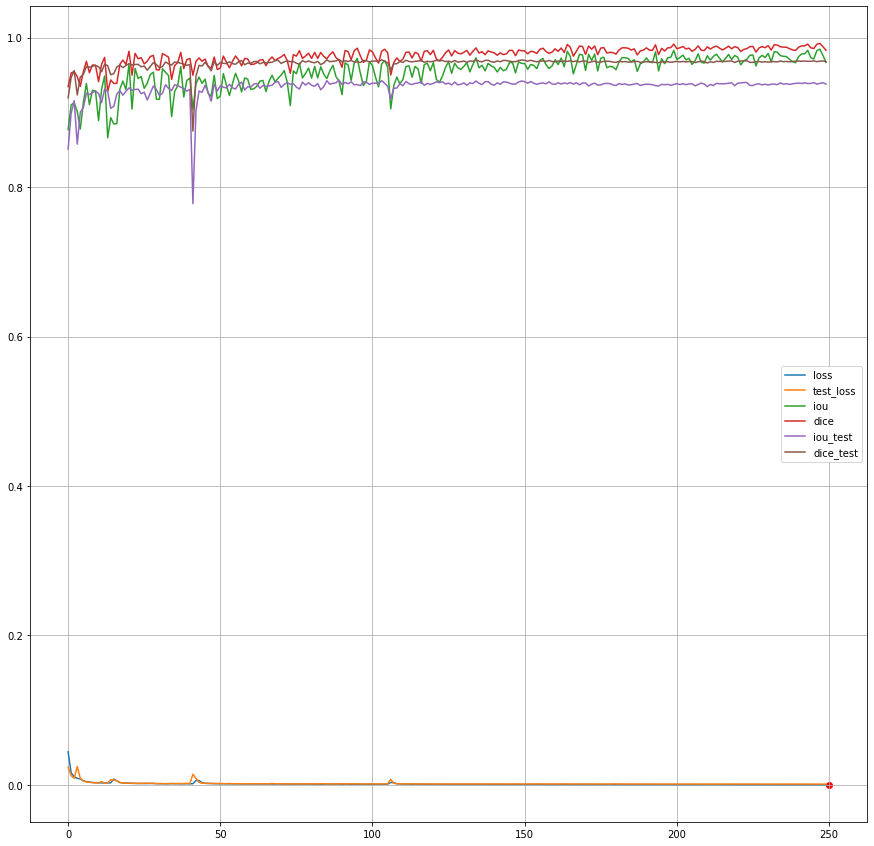

In [26]:
#250 epocas
df = pd.DataFrame(hist)
df.plot(grid=True, figsize=(15,15))
plt.show()

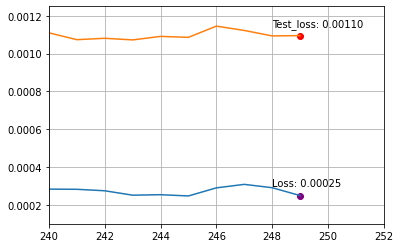

In [53]:
df = pd.DataFrame(hist)
df.plot(grid=True, xlim = (240,252), ylim=(0.00010,0.00125))
plt.scatter(249, hist["loss"][-1], color="purple")
plt.scatter(249, hist["test_loss"][-1], color="red")
plt.text(248, hist["loss"][-1]+0.00005, "Loss: 0.00025")
plt.text(248, hist["test_loss"][-1]+0.00005, "Test_loss: 0.00110 ")
plt.legend().remove()
plt.axes().remove()
plt.show()

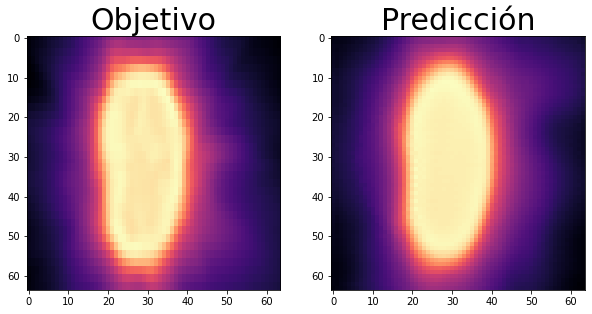

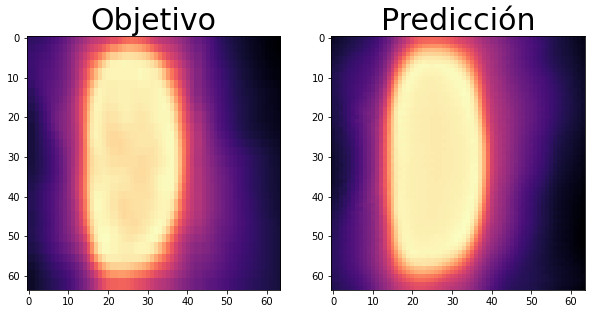

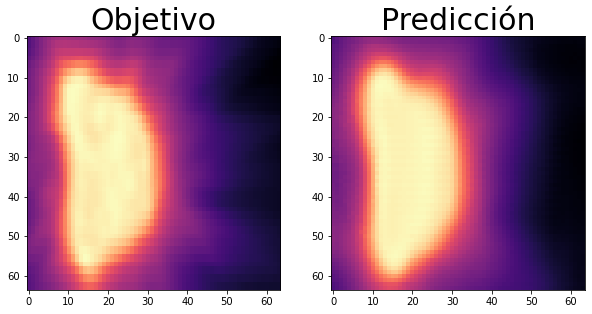

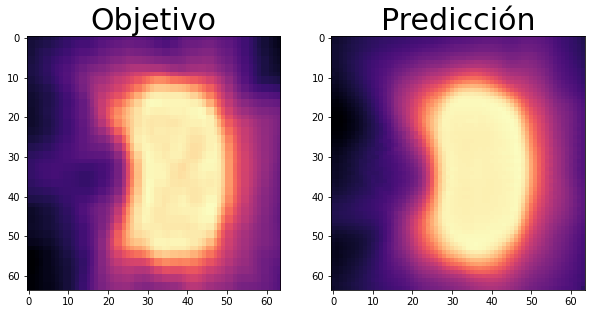

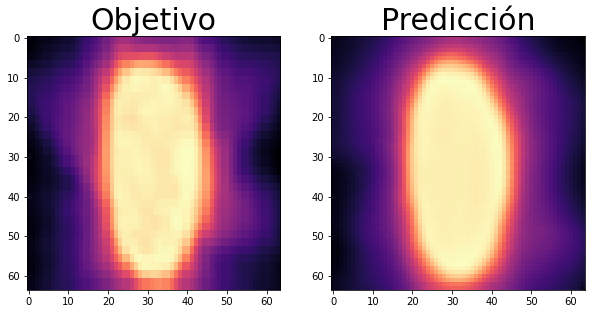

In [22]:
#250 epocas
for i in range(5):
    model.eval()
    with torch.no_grad():
        ix = random.randint(0, len(dataset['test'])-1)
        img, mask = dataset['test'][ix]
        output = model(img.unsqueeze(0).to(device, dtype=torch.float))[0]
        pred_mask = output

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        ax1.set_title('Objetivo', fontsize=30)
        ax1.imshow(mask[:,:,:,29].permute(1,2,0),cmap="magma")
        ax2.set_title('Predicción', fontsize=30)
        ax2.imshow(pred_mask.squeeze().cpu().numpy()[:,:,29],cmap="magma")
        plt.show()

## * Entrenamiento de 10 épocas con BCEWithLogitsLoss

In [19]:
device = torch.device('cuda')
model = UNet()
hist = fit(model, dataloader, epochs=10)


Epoch 1/10


loss 0.45893 iou 0.049 dice 0.093 i -2.91769: 100%|█████████████████████████████████████| 90/90 [00:50<00:00,  1.78it/s]
test_loss 0.87194 iou 0.143 dice 0.250 i -36.47937: 100%|███████████████████████████████| 30/30 [00:07<00:00,  3.80it/s]



Epoch 2/10


loss 0.40336 iou 0.113 dice 0.203 i -3.46299: 100%|█████████████████████████████████████| 90/90 [00:50<00:00,  1.77it/s]
test_loss 0.42215 iou 0.195 dice 0.326 i -4.09491: 100%|████████████████████████████████| 30/30 [00:08<00:00,  3.71it/s]



Epoch 3/10


loss 0.39123 iou 0.090 dice 0.164 i -4.12245: 100%|█████████████████████████████████████| 90/90 [00:50<00:00,  1.77it/s]
test_loss 0.38146 iou 0.137 dice 0.241 i -5.90228: 100%|████████████████████████████████| 30/30 [00:07<00:00,  3.77it/s]



Epoch 4/10


loss 0.38078 iou 0.103 dice 0.187 i -4.78184: 100%|█████████████████████████████████████| 90/90 [00:51<00:00,  1.75it/s]
test_loss 0.37117 iou 0.096 dice 0.176 i -5.29611: 100%|████████████████████████████████| 30/30 [00:07<00:00,  3.78it/s]



Epoch 5/10


loss 0.37777 iou 0.044 dice 0.084 i -5.27100: 100%|█████████████████████████████████████| 90/90 [00:52<00:00,  1.71it/s]
test_loss 0.36836 iou 0.087 dice 0.159 i -6.51430: 100%|████████████████████████████████| 30/30 [00:08<00:00,  3.61it/s]



Epoch 6/10


loss 0.36952 iou 0.101 dice 0.183 i -6.00719: 100%|█████████████████████████████████████| 90/90 [00:55<00:00,  1.63it/s]
test_loss 0.37544 iou 0.104 dice 0.188 i -6.92099: 100%|████████████████████████████████| 30/30 [00:08<00:00,  3.59it/s]



Epoch 7/10


loss 0.36364 iou 0.085 dice 0.157 i -7.08837: 100%|█████████████████████████████████████| 90/90 [00:56<00:00,  1.59it/s]
test_loss 0.35748 iou 0.108 dice 0.194 i -6.54260: 100%|████████████████████████████████| 30/30 [00:08<00:00,  3.52it/s]



Epoch 8/10


loss 0.35897 iou 0.093 dice 0.171 i -7.51472: 100%|█████████████████████████████████████| 90/90 [00:55<00:00,  1.61it/s]
test_loss 0.35577 iou 0.091 dice 0.166 i -7.86796: 100%|████████████████████████████████| 30/30 [00:08<00:00,  3.53it/s]



Epoch 9/10


loss 0.35678 iou 0.097 dice 0.177 i -8.47320: 100%|█████████████████████████████████████| 90/90 [00:56<00:00,  1.59it/s]
test_loss 0.34908 iou 0.105 dice 0.189 i -9.76816: 100%|████████████████████████████████| 30/30 [00:08<00:00,  3.52it/s]



Epoch 10/10


loss 0.35434 iou 0.103 dice 0.187 i -9.20834: 100%|█████████████████████████████████████| 90/90 [00:56<00:00,  1.59it/s]
test_loss 0.34335 iou 0.112 dice 0.202 i -17.46275: 100%|███████████████████████████████| 30/30 [00:08<00:00,  3.41it/s]


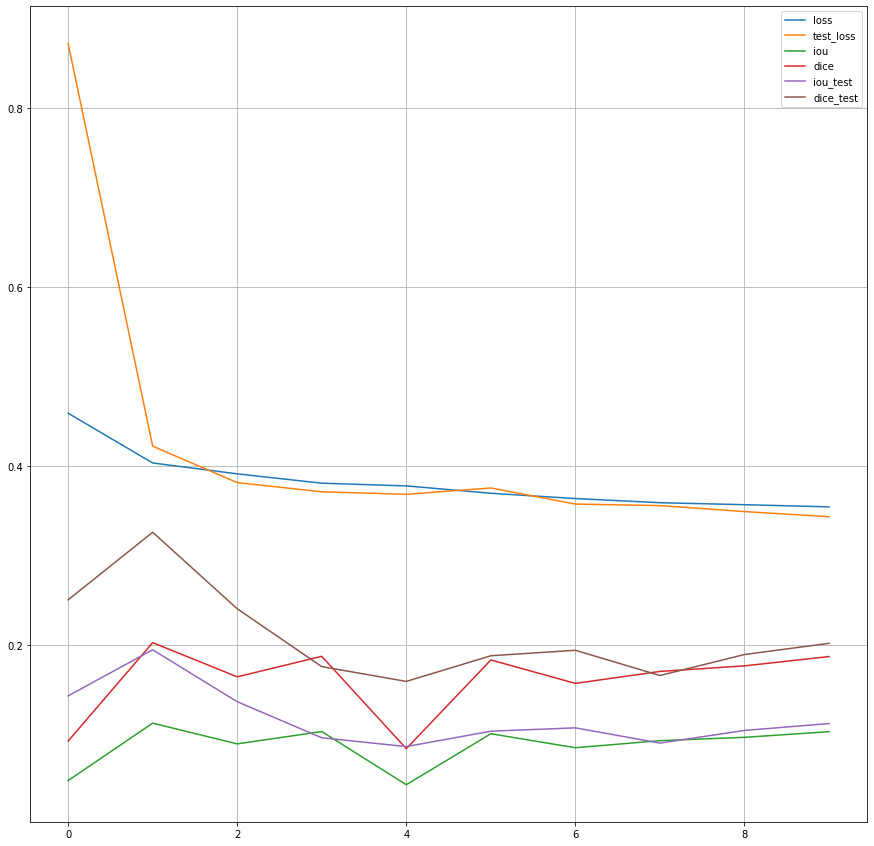

In [20]:
#10 epocas
df = pd.DataFrame(hist)
df.plot(grid=True, figsize=(15,15))
plt.show()

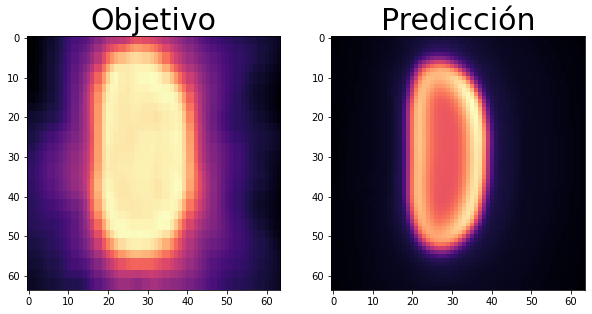

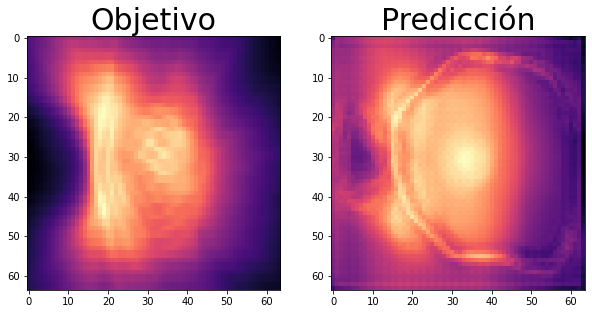

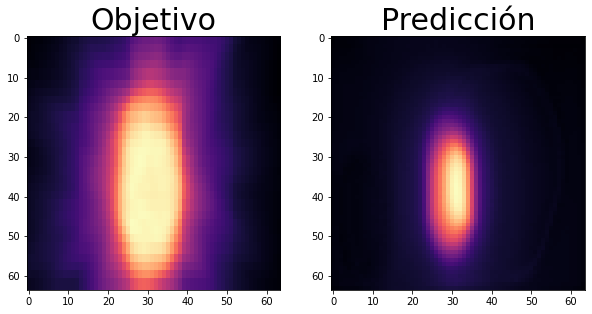

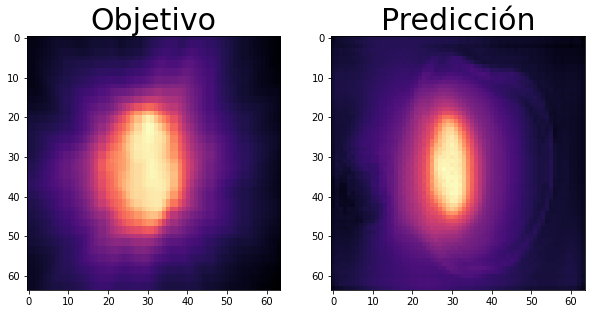

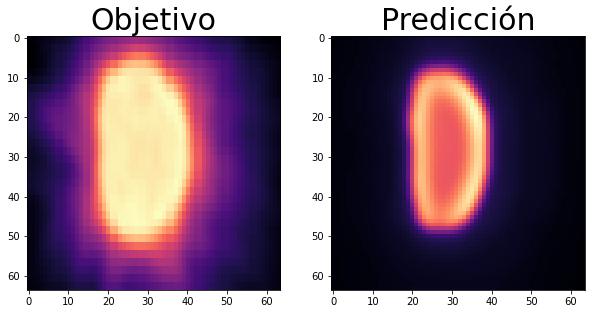

In [21]:
#10 epocas
for i in range(5):
    model.eval()
    with torch.no_grad():
        ix = random.randint(0, len(dataset['test'])-1)
        img, mask = dataset['test'][ix]
        output = model(img.unsqueeze(0).to(device, dtype=torch.float))[0]
        pred_mask = output

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        ax1.set_title('Objetivo', fontsize=30)
        ax1.imshow(mask[:,:,:,29].permute(1,2,0),cmap="magma")
        ax2.set_title('Predicción', fontsize=30)
        ax2.imshow(pred_mask.squeeze().cpu().numpy()[:,:,29],cmap="magma")
        plt.show()

## * Entrenamiento de 100 épocas con BCEWithLogitsLoss

In [38]:
device = torch.device('cuda')
model = UNet()
hist = fit(model, dataloader, epochs=100)


Epoch 1/100


loss 0.49165 iou 0.192 dice 0.322 i -3.88977: 100%|█████████████████████████████████████| 90/90 [00:51<00:00,  1.76it/s]
test_loss 0.45388 iou 0.189 dice 0.318 i -3.17180: 100%|████████████████████████████████| 30/30 [00:07<00:00,  3.85it/s]



Epoch 2/100


loss 0.42653 iou 0.129 dice 0.228 i -4.31948: 100%|█████████████████████████████████████| 90/90 [00:50<00:00,  1.77it/s]
test_loss 0.40345 iou 0.151 dice 0.263 i -6.04407: 100%|████████████████████████████████| 30/30 [00:07<00:00,  3.76it/s]



Epoch 3/100


loss 0.40386 iou 0.121 dice 0.216 i -5.06799: 100%|█████████████████████████████████████| 90/90 [00:51<00:00,  1.75it/s]
test_loss 0.41052 iou 0.143 dice 0.251 i -7.06085: 100%|████████████████████████████████| 30/30 [00:07<00:00,  3.80it/s]



Epoch 4/100


loss 0.38894 iou 0.148 dice 0.259 i -5.82541: 100%|█████████████████████████████████████| 90/90 [00:51<00:00,  1.74it/s]
test_loss 0.38941 iou 0.173 dice 0.295 i -10.00620: 100%|███████████████████████████████| 30/30 [00:08<00:00,  3.58it/s]



Epoch 5/100


loss 0.37879 iou 0.123 dice 0.220 i -6.28424: 100%|█████████████████████████████████████| 90/90 [00:53<00:00,  1.67it/s]
test_loss 0.37002 iou 0.153 dice 0.266 i -9.68665: 100%|████████████████████████████████| 30/30 [00:08<00:00,  3.48it/s]



Epoch 6/100


loss 0.37155 iou 0.141 dice 0.247 i -7.22257: 100%|█████████████████████████████████████| 90/90 [00:56<00:00,  1.60it/s]
test_loss 0.37116 iou 0.114 dice 0.204 i -6.28658: 100%|████████████████████████████████| 30/30 [00:08<00:00,  3.48it/s]



Epoch 7/100


loss 0.36696 iou 0.112 dice 0.201 i -8.14918: 100%|█████████████████████████████████████| 90/90 [00:56<00:00,  1.59it/s]
test_loss 0.36059 iou 0.105 dice 0.190 i -10.94507: 100%|███████████████████████████████| 30/30 [00:08<00:00,  3.61it/s]



Epoch 8/100


loss 0.36231 iou 0.112 dice 0.202 i -8.73477: 100%|█████████████████████████████████████| 90/90 [00:57<00:00,  1.58it/s]
test_loss 0.35627 iou 0.101 dice 0.184 i -8.74981: 100%|████████████████████████████████| 30/30 [00:08<00:00,  3.55it/s]



Epoch 9/100


loss 0.35701 iou 0.134 dice 0.236 i -10.30260: 100%|████████████████████████████████████| 90/90 [00:56<00:00,  1.60it/s]
test_loss 0.34878 iou 0.126 dice 0.224 i -11.48551: 100%|███████████████████████████████| 30/30 [00:08<00:00,  3.54it/s]



Epoch 10/100


loss 0.35649 iou 0.101 dice 0.183 i -11.54355: 100%|████████████████████████████████████| 90/90 [00:56<00:00,  1.60it/s]
test_loss 0.35325 iou 0.119 dice 0.213 i -11.48933: 100%|███████████████████████████████| 30/30 [00:08<00:00,  3.49it/s]



Epoch 11/100


loss 0.35162 iou 0.068 dice 0.127 i -11.22010: 100%|████████████████████████████████████| 90/90 [00:55<00:00,  1.62it/s]
test_loss 0.34568 iou 0.109 dice 0.197 i -11.52207: 100%|███████████████████████████████| 30/30 [00:08<00:00,  3.52it/s]



Epoch 12/100


loss 0.34812 iou 0.104 dice 0.189 i -13.91854: 100%|████████████████████████████████████| 90/90 [00:56<00:00,  1.60it/s]
test_loss 0.34230 iou 0.110 dice 0.199 i -14.45167: 100%|███████████████████████████████| 30/30 [00:08<00:00,  3.62it/s]



Epoch 13/100


loss 0.34480 iou 0.073 dice 0.137 i -15.90657: 100%|████████████████████████████████████| 90/90 [00:56<00:00,  1.58it/s]
test_loss 0.34265 iou 0.099 dice 0.180 i -15.51241: 100%|███████████████████████████████| 30/30 [00:08<00:00,  3.52it/s]



Epoch 14/100


loss 0.34356 iou 0.077 dice 0.143 i -16.99411: 100%|████████████████████████████████████| 90/90 [00:56<00:00,  1.60it/s]
test_loss 0.35213 iou 0.082 dice 0.151 i -15.12577: 100%|███████████████████████████████| 30/30 [00:08<00:00,  3.48it/s]



Epoch 15/100


loss 0.35537 iou 0.108 dice 0.194 i -19.29435: 100%|████████████████████████████████████| 90/90 [00:56<00:00,  1.60it/s]
test_loss 0.41009 iou 0.121 dice 0.216 i -41.63228: 100%|███████████████████████████████| 30/30 [00:08<00:00,  3.58it/s]



Epoch 16/100


loss 0.35540 iou 0.099 dice 0.179 i -19.90146: 100%|████████████████████████████████████| 90/90 [00:56<00:00,  1.58it/s]
test_loss 0.34393 iou 0.106 dice 0.192 i -19.19852: 100%|███████████████████████████████| 30/30 [00:08<00:00,  3.36it/s]



Epoch 17/100


loss 0.34173 iou 0.103 dice 0.186 i -22.74220: 100%|████████████████████████████████████| 90/90 [00:56<00:00,  1.59it/s]
test_loss 0.35487 iou 0.094 dice 0.172 i -11.89731: 100%|███████████████████████████████| 30/30 [00:08<00:00,  3.55it/s]



Epoch 18/100


loss 0.33815 iou 0.084 dice 0.155 i -24.34373: 100%|████████████████████████████████████| 90/90 [00:56<00:00,  1.58it/s]
test_loss 0.32912 iou 0.108 dice 0.195 i -34.19821: 100%|███████████████████████████████| 30/30 [00:08<00:00,  3.51it/s]



Epoch 19/100


loss 0.33367 iou 0.106 dice 0.191 i -26.15376: 100%|████████████████████████████████████| 90/90 [00:56<00:00,  1.59it/s]
test_loss 0.32739 iou 0.104 dice 0.189 i -33.01474: 100%|███████████████████████████████| 30/30 [00:08<00:00,  3.60it/s]



Epoch 20/100


loss 0.33179 iou 0.086 dice 0.159 i -28.52625: 100%|████████████████████████████████████| 90/90 [00:56<00:00,  1.60it/s]
test_loss 0.33034 iou 0.096 dice 0.175 i -36.05830: 100%|███████████████████████████████| 30/30 [00:08<00:00,  3.60it/s]



Epoch 21/100


loss 0.33032 iou 0.084 dice 0.155 i -32.40924: 100%|████████████████████████████████████| 90/90 [00:56<00:00,  1.60it/s]
test_loss 0.32924 iou 0.086 dice 0.158 i -29.90245: 100%|███████████████████████████████| 30/30 [00:08<00:00,  3.57it/s]



Epoch 22/100


loss 0.32639 iou 0.093 dice 0.170 i -39.12769: 100%|████████████████████████████████████| 90/90 [00:56<00:00,  1.60it/s]
test_loss 0.32804 iou 0.099 dice 0.180 i -30.29951: 100%|███████████████████████████████| 30/30 [00:08<00:00,  3.62it/s]



Epoch 23/100


loss 0.32320 iou 0.095 dice 0.174 i -44.19771: 100%|████████████████████████████████████| 90/90 [00:55<00:00,  1.62it/s]
test_loss 0.31510 iou 0.118 dice 0.211 i -55.76401: 100%|███████████████████████████████| 30/30 [00:08<00:00,  3.54it/s]



Epoch 24/100


loss 0.32003 iou 0.068 dice 0.128 i -47.35085: 100%|████████████████████████████████████| 90/90 [00:56<00:00,  1.60it/s]
test_loss 0.31429 iou 0.089 dice 0.163 i -55.17868: 100%|███████████████████████████████| 30/30 [00:08<00:00,  3.58it/s]



Epoch 25/100


loss 0.31687 iou 0.078 dice 0.144 i -54.29412: 100%|████████████████████████████████████| 90/90 [00:56<00:00,  1.59it/s]
test_loss 0.31002 iou 0.092 dice 0.168 i -63.01778: 100%|███████████████████████████████| 30/30 [00:08<00:00,  3.53it/s]



Epoch 26/100


loss 0.31347 iou 0.087 dice 0.160 i -57.23570: 100%|████████████████████████████████████| 90/90 [00:56<00:00,  1.59it/s]
test_loss 0.30315 iou 0.100 dice 0.182 i -76.72949: 100%|███████████████████████████████| 30/30 [00:08<00:00,  3.52it/s]



Epoch 27/100


loss 0.31076 iou 0.106 dice 0.192 i -61.89160: 100%|████████████████████████████████████| 90/90 [00:57<00:00,  1.58it/s]
test_loss 0.29941 iou 0.102 dice 0.185 i -91.50484: 100%|███████████████████████████████| 30/30 [00:08<00:00,  3.53it/s]



Epoch 28/100


loss 0.30692 iou 0.097 dice 0.177 i -71.44566: 100%|████████████████████████████████████| 90/90 [00:56<00:00,  1.59it/s]
test_loss 0.30785 iou 0.094 dice 0.172 i -72.09692: 100%|███████████████████████████████| 30/30 [00:08<00:00,  3.56it/s]



Epoch 29/100


loss 0.30973 iou 0.077 dice 0.143 i -77.92268: 100%|████████████████████████████████████| 90/90 [00:56<00:00,  1.59it/s]
test_loss 0.31741 iou 0.112 dice 0.201 i -105.95003: 100%|██████████████████████████████| 30/30 [00:08<00:00,  3.55it/s]



Epoch 30/100


loss 0.30891 iou 0.066 dice 0.124 i -86.09859: 100%|████████████████████████████████████| 90/90 [00:55<00:00,  1.61it/s]
test_loss 0.48402 iou 0.175 dice 0.298 i -114.05215: 100%|██████████████████████████████| 30/30 [00:08<00:00,  3.55it/s]



Epoch 31/100


loss 0.31915 iou 0.112 dice 0.201 i -96.14121: 100%|████████████████████████████████████| 90/90 [00:55<00:00,  1.61it/s]
test_loss 0.30785 iou 0.107 dice 0.194 i -84.94560: 100%|███████████████████████████████| 30/30 [00:08<00:00,  3.52it/s]



Epoch 32/100


loss 0.29870 iou 0.116 dice 0.208 i -93.77525: 100%|████████████████████████████████████| 90/90 [00:56<00:00,  1.59it/s]
test_loss 0.28869 iou 0.107 dice 0.193 i -128.23386: 100%|██████████████████████████████| 30/30 [00:08<00:00,  3.57it/s]



Epoch 33/100


loss 0.29220 iou 0.079 dice 0.147 i -114.68615: 100%|███████████████████████████████████| 90/90 [00:56<00:00,  1.58it/s]
test_loss 0.28395 iou 0.093 dice 0.171 i -137.61176: 100%|██████████████████████████████| 30/30 [00:08<00:00,  3.59it/s]



Epoch 34/100


loss 0.28783 iou 0.109 dice 0.196 i -127.80045: 100%|███████████████████████████████████| 90/90 [00:55<00:00,  1.62it/s]
test_loss 0.27570 iou 0.102 dice 0.185 i -179.46097: 100%|██████████████████████████████| 30/30 [00:08<00:00,  3.54it/s]



Epoch 35/100


loss 0.28276 iou 0.117 dice 0.209 i -131.19696: 100%|███████████████████████████████████| 90/90 [00:56<00:00,  1.59it/s]
test_loss 0.27290 iou 0.102 dice 0.186 i -183.24619: 100%|██████████████████████████████| 30/30 [00:08<00:00,  3.57it/s]



Epoch 36/100


loss 0.27875 iou 0.128 dice 0.227 i -145.88158: 100%|███████████████████████████████████| 90/90 [00:56<00:00,  1.59it/s]
test_loss 0.27316 iou 0.105 dice 0.191 i -176.79634: 100%|██████████████████████████████| 30/30 [00:08<00:00,  3.48it/s]



Epoch 37/100


loss 0.27528 iou 0.090 dice 0.164 i -170.37131: 100%|███████████████████████████████████| 90/90 [00:56<00:00,  1.60it/s]
test_loss 0.27384 iou 0.107 dice 0.194 i -172.38763: 100%|██████████████████████████████| 30/30 [00:08<00:00,  3.50it/s]



Epoch 38/100


loss 0.27077 iou 0.085 dice 0.157 i -186.40729: 100%|███████████████████████████████████| 90/90 [00:56<00:00,  1.59it/s]
test_loss 0.25688 iou 0.102 dice 0.185 i -238.32861: 100%|██████████████████████████████| 30/30 [00:08<00:00,  3.53it/s]



Epoch 39/100


loss 0.26683 iou 0.082 dice 0.152 i -193.82076: 100%|███████████████████████████████████| 90/90 [00:57<00:00,  1.57it/s]
test_loss 0.18058 iou 0.123 dice 0.218 i -905.04480: 100%|██████████████████████████████| 30/30 [00:08<00:00,  3.42it/s]



Epoch 40/100


loss 0.26309 iou 0.073 dice 0.136 i -214.08636: 100%|███████████████████████████████████| 90/90 [00:56<00:00,  1.60it/s]
test_loss 0.26989 iou 0.095 dice 0.174 i -179.93765: 100%|██████████████████████████████| 30/30 [00:08<00:00,  3.58it/s]



Epoch 41/100


loss 0.25643 iou 0.076 dice 0.142 i -216.65247: 100%|███████████████████████████████████| 90/90 [00:56<00:00,  1.58it/s]
test_loss 0.24938 iou 0.090 dice 0.166 i -269.99820: 100%|██████████████████████████████| 30/30 [00:08<00:00,  3.56it/s]



Epoch 42/100


loss 0.25161 iou 0.104 dice 0.189 i -242.21478: 100%|███████████████████████████████████| 90/90 [00:55<00:00,  1.61it/s]
test_loss 0.24700 iou 0.106 dice 0.192 i -333.47333: 100%|██████████████████████████████| 30/30 [00:08<00:00,  3.54it/s]



Epoch 43/100


loss 0.24691 iou 0.081 dice 0.150 i -279.77661: 100%|███████████████████████████████████| 90/90 [00:56<00:00,  1.58it/s]
test_loss 0.24776 iou 0.099 dice 0.180 i -265.98151: 100%|██████████████████████████████| 30/30 [00:08<00:00,  3.61it/s]



Epoch 44/100


loss 0.24395 iou 0.068 dice 0.128 i -277.06827: 100%|███████████████████████████████████| 90/90 [00:56<00:00,  1.60it/s]
test_loss 0.18002 iou 0.117 dice 0.209 i -957.10822: 100%|██████████████████████████████| 30/30 [00:08<00:00,  3.53it/s]



Epoch 45/100


loss 0.24318 iou 0.079 dice 0.146 i -312.55847: 100%|███████████████████████████████████| 90/90 [00:57<00:00,  1.57it/s]
test_loss 0.20440 iou 0.100 dice 0.182 i -565.65625: 100%|██████████████████████████████| 30/30 [00:08<00:00,  3.58it/s]



Epoch 46/100


loss 0.23376 iou 0.088 dice 0.162 i -335.02478: 100%|███████████████████████████████████| 90/90 [00:56<00:00,  1.59it/s]
test_loss 0.20027 iou 0.104 dice 0.188 i -521.94690: 100%|██████████████████████████████| 30/30 [00:08<00:00,  3.47it/s]



Epoch 47/100


loss 0.22975 iou 0.075 dice 0.140 i -364.93756: 100%|███████████████████████████████████| 90/90 [00:56<00:00,  1.59it/s]
test_loss 0.21696 iou 0.089 dice 0.163 i -462.83954: 100%|██████████████████████████████| 30/30 [00:08<00:00,  3.62it/s]



Epoch 48/100


loss 0.22519 iou 0.092 dice 0.168 i -378.14120: 100%|███████████████████████████████████| 90/90 [00:56<00:00,  1.61it/s]
test_loss 0.27244 iou 0.087 dice 0.160 i -205.37393: 100%|██████████████████████████████| 30/30 [00:08<00:00,  3.62it/s]



Epoch 49/100


loss 0.21694 iou 0.108 dice 0.195 i -407.23654: 100%|███████████████████████████████████| 90/90 [00:56<00:00,  1.59it/s]
test_loss 0.22533 iou 0.094 dice 0.172 i -424.02094: 100%|██████████████████████████████| 30/30 [00:08<00:00,  3.48it/s]



Epoch 50/100


loss 0.21340 iou 0.063 dice 0.119 i -446.69690: 100%|███████████████████████████████████| 90/90 [00:56<00:00,  1.60it/s]
test_loss 0.19180 iou 0.084 dice 0.156 i -618.29364: 100%|██████████████████████████████| 30/30 [00:08<00:00,  3.40it/s]



Epoch 51/100


loss 0.24466 iou 0.068 dice 0.127 i -466.30249: 100%|███████████████████████████████████| 90/90 [00:56<00:00,  1.60it/s]
test_loss 0.21154 iou 0.087 dice 0.160 i -553.23260: 100%|██████████████████████████████| 30/30 [00:08<00:00,  3.63it/s]



Epoch 52/100


loss 0.21362 iou 0.067 dice 0.126 i -504.68872: 100%|███████████████████████████████████| 90/90 [00:56<00:00,  1.59it/s]
test_loss 0.18943 iou 0.096 dice 0.176 i -635.87805: 100%|██████████████████████████████| 30/30 [00:09<00:00,  3.16it/s]



Epoch 53/100


loss 0.20292 iou 0.099 dice 0.179 i -511.13733: 100%|███████████████████████████████████| 90/90 [00:56<00:00,  1.60it/s]
test_loss 0.18789 iou 0.099 dice 0.180 i -633.76819: 100%|██████████████████████████████| 30/30 [00:08<00:00,  3.56it/s]



Epoch 54/100


loss 0.19565 iou 0.069 dice 0.129 i -564.17981: 100%|███████████████████████████████████| 90/90 [00:56<00:00,  1.60it/s]
test_loss 0.18328 iou 0.098 dice 0.178 i -664.08331: 100%|██████████████████████████████| 30/30 [00:08<00:00,  3.53it/s]



Epoch 55/100


loss 0.18878 iou 0.112 dice 0.202 i -583.28381: 100%|███████████████████████████████████| 90/90 [00:56<00:00,  1.60it/s]
test_loss 0.19667 iou 0.092 dice 0.169 i -588.61157: 100%|██████████████████████████████| 30/30 [00:08<00:00,  3.40it/s]



Epoch 56/100


loss 0.18200 iou 0.072 dice 0.135 i -637.13373: 100%|███████████████████████████████████| 90/90 [00:56<00:00,  1.58it/s]
test_loss 0.16223 iou 0.099 dice 0.180 i -822.93597: 100%|██████████████████████████████| 30/30 [00:08<00:00,  3.58it/s]



Epoch 57/100


loss 0.17636 iou 0.049 dice 0.093 i -680.90320: 100%|███████████████████████████████████| 90/90 [00:57<00:00,  1.58it/s]
test_loss 0.18544 iou 0.095 dice 0.173 i -657.21429: 100%|██████████████████████████████| 30/30 [00:08<00:00,  3.48it/s]



Epoch 58/100


loss 0.16982 iou 0.095 dice 0.173 i -691.45331: 100%|███████████████████████████████████| 90/90 [00:56<00:00,  1.60it/s]
test_loss 0.16008 iou 0.095 dice 0.174 i -857.07056: 100%|██████████████████████████████| 30/30 [00:08<00:00,  3.53it/s]



Epoch 59/100


loss 0.16476 iou 0.079 dice 0.147 i -764.97162: 100%|███████████████████████████████████| 90/90 [00:56<00:00,  1.60it/s]
test_loss 0.12922 iou 0.105 dice 0.190 i -1133.79700: 100%|█████████████████████████████| 30/30 [00:08<00:00,  3.56it/s]



Epoch 60/100


loss 0.15776 iou 0.099 dice 0.179 i -806.45154: 100%|███████████████████████████████████| 90/90 [00:56<00:00,  1.59it/s]
test_loss 0.12988 iou 0.097 dice 0.177 i -1136.29492: 100%|█████████████████████████████| 30/30 [00:08<00:00,  3.52it/s]



Epoch 61/100


loss 0.15185 iou 0.102 dice 0.185 i -838.84766: 100%|███████████████████████████████████| 90/90 [00:56<00:00,  1.60it/s]
test_loss 0.14867 iou 0.095 dice 0.174 i -956.31873: 100%|██████████████████████████████| 30/30 [00:08<00:00,  3.54it/s]



Epoch 62/100


loss 0.14804 iou 0.066 dice 0.123 i -892.56860: 100%|███████████████████████████████████| 90/90 [00:56<00:00,  1.60it/s]
test_loss 0.15596 iou 0.081 dice 0.150 i -943.51001: 100%|██████████████████████████████| 30/30 [00:08<00:00,  3.54it/s]



Epoch 63/100


loss 0.13986 iou 0.086 dice 0.159 i -934.81360: 100%|███████████████████████████████████| 90/90 [00:57<00:00,  1.58it/s]
test_loss 0.10893 iou 0.105 dice 0.190 i -1280.95447: 100%|█████████████████████████████| 30/30 [00:08<00:00,  3.49it/s]



Epoch 64/100


loss 0.13387 iou 0.080 dice 0.148 i -984.72449: 100%|███████████████████████████████████| 90/90 [00:56<00:00,  1.59it/s]
test_loss 0.12098 iou 0.097 dice 0.176 i -1269.68152: 100%|█████████████████████████████| 30/30 [00:08<00:00,  3.62it/s]



Epoch 65/100


loss 0.12803 iou 0.093 dice 0.170 i -1039.96997: 100%|██████████████████████████████████| 90/90 [00:57<00:00,  1.57it/s]
test_loss 0.11740 iou 0.096 dice 0.176 i -1300.38867: 100%|█████████████████████████████| 30/30 [00:08<00:00,  3.60it/s]



Epoch 66/100


loss 0.11930 iou 0.115 dice 0.207 i -1081.57959: 100%|██████████████████████████████████| 90/90 [00:56<00:00,  1.59it/s]
test_loss 0.08355 iou 0.104 dice 0.189 i -1677.06897: 100%|█████████████████████████████| 30/30 [00:08<00:00,  3.51it/s]



Epoch 67/100


loss 0.11677 iou 0.086 dice 0.159 i -1140.56079: 100%|██████████████████████████████████| 90/90 [00:56<00:00,  1.59it/s]
test_loss 0.09493 iou 0.105 dice 0.190 i -1433.98669: 100%|█████████████████████████████| 30/30 [00:08<00:00,  3.54it/s]



Epoch 68/100


loss 0.10994 iou 0.085 dice 0.157 i -1205.56177: 100%|██████████████████████████████████| 90/90 [00:56<00:00,  1.60it/s]
test_loss 0.07391 iou 0.089 dice 0.163 i -1891.93323: 100%|█████████████████████████████| 30/30 [00:08<00:00,  3.55it/s]



Epoch 69/100


loss 0.10442 iou 0.088 dice 0.161 i -1278.53589: 100%|██████████████████████████████████| 90/90 [00:56<00:00,  1.58it/s]
test_loss 0.07729 iou 0.110 dice 0.198 i -1780.01074: 100%|█████████████████████████████| 30/30 [00:08<00:00,  3.58it/s]



Epoch 70/100


loss 0.09413 iou 0.104 dice 0.188 i -1307.72876: 100%|██████████████████████████████████| 90/90 [00:56<00:00,  1.60it/s]
test_loss 0.10872 iou 0.104 dice 0.188 i -1343.44482: 100%|█████████████████████████████| 30/30 [00:08<00:00,  3.58it/s]



Epoch 71/100


loss 0.08896 iou 0.063 dice 0.118 i -1379.98340: 100%|██████████████████████████████████| 90/90 [00:55<00:00,  1.61it/s]
test_loss 0.11910 iou 0.086 dice 0.159 i -1267.95093: 100%|█████████████████████████████| 30/30 [00:08<00:00,  3.42it/s]



Epoch 72/100


loss 0.08277 iou 0.092 dice 0.169 i -1440.17651: 100%|██████████████████████████████████| 90/90 [00:56<00:00,  1.60it/s]
test_loss 0.07596 iou 0.093 dice 0.170 i -1762.16895: 100%|█████████████████████████████| 30/30 [00:08<00:00,  3.52it/s]



Epoch 73/100


loss 0.07436 iou 0.104 dice 0.189 i -1507.08667: 100%|██████████████████████████████████| 90/90 [00:56<00:00,  1.60it/s]
test_loss 0.05330 iou 0.097 dice 0.177 i -2085.79175: 100%|█████████████████████████████| 30/30 [00:08<00:00,  3.45it/s]



Epoch 74/100


loss 0.07079 iou 0.125 dice 0.223 i -1559.30969: 100%|██████████████████████████████████| 90/90 [00:56<00:00,  1.59it/s]
test_loss -0.07222 iou 0.103 dice 0.186 i -3611.06299: 100%|████████████████████████████| 30/30 [00:08<00:00,  3.54it/s]



Epoch 75/100


loss 0.06241 iou 0.092 dice 0.168 i -1619.78931: 100%|██████████████████████████████████| 90/90 [00:55<00:00,  1.61it/s]
test_loss 0.04554 iou 0.095 dice 0.174 i -2058.11792: 100%|█████████████████████████████| 30/30 [00:08<00:00,  3.39it/s]



Epoch 76/100


loss 0.05596 iou 0.086 dice 0.158 i -1697.55103: 100%|██████████████████████████████████| 90/90 [00:56<00:00,  1.59it/s]
test_loss 0.01037 iou 0.088 dice 0.162 i -2694.03271: 100%|█████████████████████████████| 30/30 [00:08<00:00,  3.52it/s]



Epoch 77/100


loss 0.05452 iou 0.083 dice 0.154 i -1809.31226: 100%|██████████████████████████████████| 90/90 [00:56<00:00,  1.58it/s]
test_loss 0.02277 iou 0.090 dice 0.164 i -2380.87109: 100%|█████████████████████████████| 30/30 [00:08<00:00,  3.57it/s]



Epoch 78/100


loss 0.04079 iou 0.103 dice 0.186 i -1845.99561: 100%|██████████████████████████████████| 90/90 [00:56<00:00,  1.60it/s]
test_loss 0.02268 iou 0.102 dice 0.185 i -2441.43311: 100%|█████████████████████████████| 30/30 [00:08<00:00,  3.54it/s]



Epoch 79/100


loss 0.03691 iou 0.064 dice 0.121 i -1972.27185: 100%|██████████████████████████████████| 90/90 [00:56<00:00,  1.60it/s]
test_loss 0.08894 iou 0.089 dice 0.163 i -1724.05139: 100%|█████████████████████████████| 30/30 [00:08<00:00,  3.46it/s]



Epoch 80/100


loss 0.05581 iou 0.076 dice 0.141 i -2003.77026: 100%|██████████████████████████████████| 90/90 [00:55<00:00,  1.61it/s]
test_loss 0.46955 iou 0.113 dice 0.203 i -1934.02209: 100%|█████████████████████████████| 30/30 [00:08<00:00,  3.60it/s]



Epoch 81/100


loss 0.06691 iou 0.076 dice 0.141 i -2100.39648: 100%|██████████████████████████████████| 90/90 [00:56<00:00,  1.59it/s]
test_loss 0.02047 iou 0.132 dice 0.234 i -2912.40552: 100%|█████████████████████████████| 30/30 [00:08<00:00,  3.57it/s]



Epoch 82/100


loss 0.04146 iou 0.078 dice 0.145 i -2166.14355: 100%|██████████████████████████████████| 90/90 [00:56<00:00,  1.60it/s]
test_loss 0.05336 iou 0.094 dice 0.172 i -2084.34961: 100%|█████████████████████████████| 30/30 [00:08<00:00,  3.55it/s]



Epoch 83/100


loss 0.02249 iou 0.092 dice 0.169 i -2240.56641: 100%|██████████████████████████████████| 90/90 [00:56<00:00,  1.60it/s]
test_loss 0.01977 iou 0.107 dice 0.193 i -2610.71729: 100%|█████████████████████████████| 30/30 [00:08<00:00,  3.53it/s]



Epoch 84/100


loss 0.00986 iou 0.107 dice 0.193 i -2301.89697: 100%|██████████████████████████████████| 90/90 [00:56<00:00,  1.60it/s]
test_loss -0.00311 iou 0.103 dice 0.187 i -2734.54590: 100%|████████████████████████████| 30/30 [00:08<00:00,  3.55it/s]



Epoch 85/100


loss 0.00353 iou 0.071 dice 0.133 i -2445.20264: 100%|██████████████████████████████████| 90/90 [00:56<00:00,  1.59it/s]
test_loss -0.06182 iou 0.100 dice 0.181 i -3858.17090: 100%|████████████████████████████| 30/30 [00:08<00:00,  3.55it/s]



Epoch 86/100


loss -0.00844 iou 0.071 dice 0.132 i -2558.54248: 100%|█████████████████████████████████| 90/90 [00:56<00:00,  1.59it/s]
test_loss -0.05841 iou 0.094 dice 0.172 i -3826.13550: 100%|████████████████████████████| 30/30 [00:08<00:00,  3.48it/s]



Epoch 87/100


loss -0.01596 iou 0.102 dice 0.185 i -2623.02490: 100%|█████████████████████████████████| 90/90 [00:56<00:00,  1.59it/s]
test_loss -0.04525 iou 0.107 dice 0.193 i -3552.37280: 100%|████████████████████████████| 30/30 [00:08<00:00,  3.56it/s]



Epoch 88/100


loss -0.01349 iou 0.076 dice 0.141 i -2738.87305: 100%|█████████████████████████████████| 90/90 [00:56<00:00,  1.59it/s]
test_loss -0.02224 iou 0.106 dice 0.191 i -3181.57324: 100%|████████████████████████████| 30/30 [00:08<00:00,  3.39it/s]



Epoch 89/100


loss -0.02998 iou 0.103 dice 0.186 i -2768.70068: 100%|█████████████████████████████████| 90/90 [00:55<00:00,  1.61it/s]
test_loss -0.06049 iou 0.107 dice 0.194 i -3644.32178: 100%|████████████████████████████| 30/30 [00:08<00:00,  3.38it/s]



Epoch 90/100


loss -0.04116 iou 0.082 dice 0.151 i -2929.23535: 100%|█████████████████████████████████| 90/90 [00:56<00:00,  1.61it/s]
test_loss -0.08058 iou 0.097 dice 0.176 i -3785.51514: 100%|████████████████████████████| 30/30 [00:08<00:00,  3.55it/s]



Epoch 91/100


loss -0.04869 iou 0.120 dice 0.214 i -3039.00488: 100%|█████████████████████████████████| 90/90 [00:56<00:00,  1.60it/s]
test_loss -0.09930 iou 0.105 dice 0.191 i -4469.09766: 100%|████████████████████████████| 30/30 [00:08<00:00,  3.62it/s]



Epoch 92/100


loss -0.05768 iou 0.102 dice 0.184 i -3084.90332: 100%|█████████████████████████████████| 90/90 [00:56<00:00,  1.60it/s]
test_loss -0.03957 iou 0.105 dice 0.191 i -3485.94824: 100%|████████████████████████████| 30/30 [00:08<00:00,  3.41it/s]



Epoch 93/100


loss -0.06593 iou 0.112 dice 0.201 i -3212.15967: 100%|█████████████████████████████████| 90/90 [00:57<00:00,  1.58it/s]
test_loss -0.04859 iou 0.103 dice 0.187 i -3585.65137: 100%|████████████████████████████| 30/30 [00:08<00:00,  3.49it/s]



Epoch 94/100


loss -0.06717 iou 0.090 dice 0.166 i -3356.11377: 100%|█████████████████████████████████| 90/90 [00:56<00:00,  1.59it/s]
test_loss -0.07334 iou 0.094 dice 0.172 i -3958.85449: 100%|████████████████████████████| 30/30 [00:08<00:00,  3.55it/s]



Epoch 95/100


loss -0.07758 iou 0.093 dice 0.171 i -3500.72705: 100%|█████████████████████████████████| 90/90 [00:56<00:00,  1.59it/s]
test_loss -0.11211 iou 0.095 dice 0.174 i -4732.07422: 100%|████████████████████████████| 30/30 [00:08<00:00,  3.59it/s]



Epoch 96/100


loss -0.08645 iou 0.084 dice 0.156 i -3643.40576: 100%|█████████████████████████████████| 90/90 [00:56<00:00,  1.60it/s]
test_loss -0.14622 iou 0.093 dice 0.170 i -5316.22168: 100%|████████████████████████████| 30/30 [00:08<00:00,  3.58it/s]



Epoch 97/100


loss -0.09310 iou 0.075 dice 0.139 i -3760.62378: 100%|█████████████████████████████████| 90/90 [00:56<00:00,  1.59it/s]
test_loss -0.06188 iou 0.100 dice 0.182 i -4154.57812: 100%|████████████████████████████| 30/30 [00:08<00:00,  3.53it/s]



Epoch 98/100


loss -0.10363 iou 0.091 dice 0.168 i -3831.17847: 100%|█████████████████████████████████| 90/90 [00:56<00:00,  1.58it/s]
test_loss -0.11397 iou 0.104 dice 0.189 i -4786.73242: 100%|████████████████████████████| 30/30 [00:09<00:00,  3.26it/s]



Epoch 99/100


loss -0.11136 iou 0.110 dice 0.198 i -3972.76514: 100%|█████████████████████████████████| 90/90 [00:59<00:00,  1.52it/s]
test_loss -0.07574 iou 0.101 dice 0.183 i -3981.96777: 100%|████████████████████████████| 30/30 [00:09<00:00,  3.22it/s]



Epoch 100/100


loss -0.11991 iou 0.102 dice 0.185 i -4098.13525: 100%|█████████████████████████████████| 90/90 [00:58<00:00,  1.53it/s]
test_loss -0.11886 iou 0.099 dice 0.180 i -4793.07812: 100%|████████████████████████████| 30/30 [00:08<00:00,  3.37it/s]


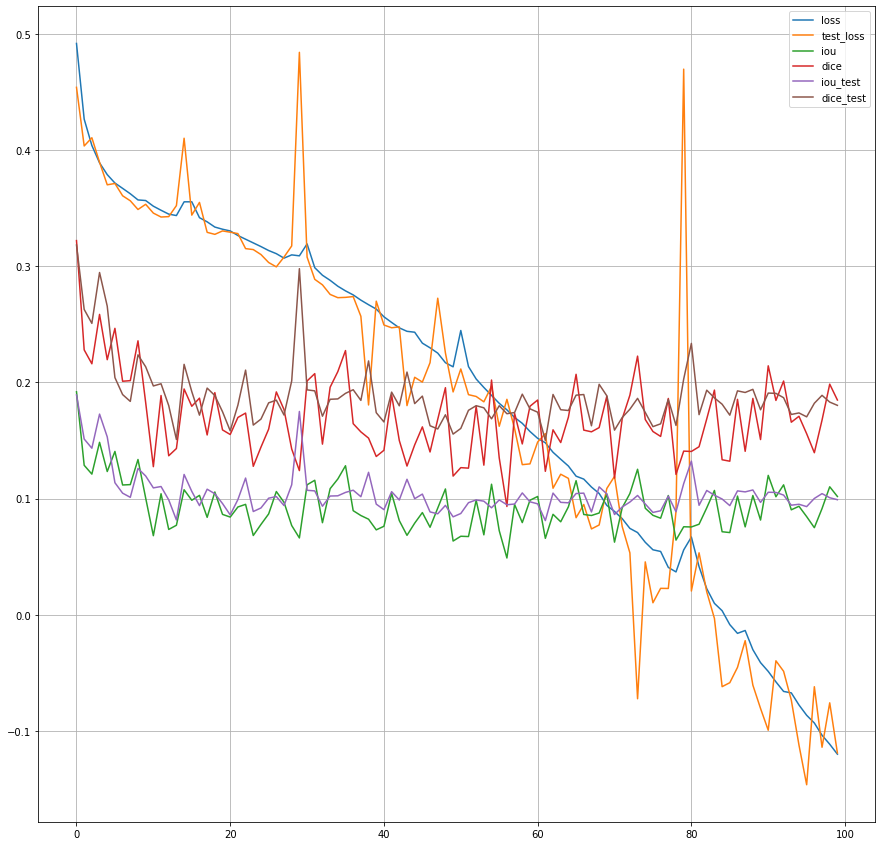

In [39]:
#100 epocas
df = pd.DataFrame(hist)
df.plot(grid=True, figsize=(15,15))
plt.show()

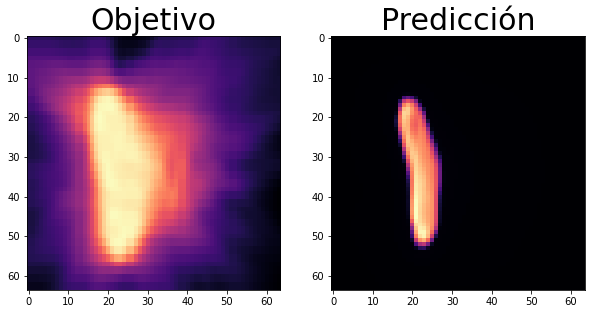

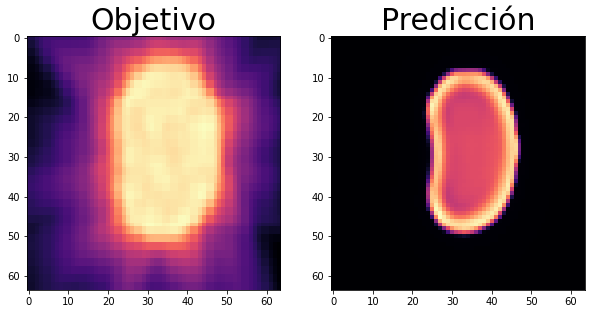

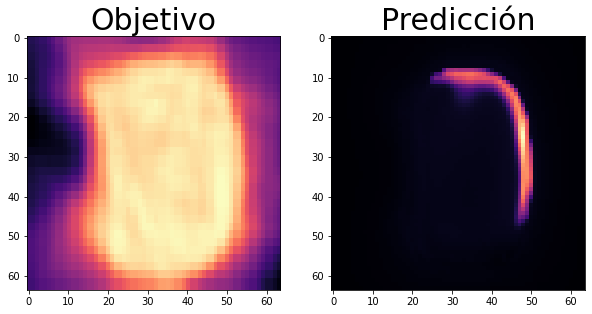

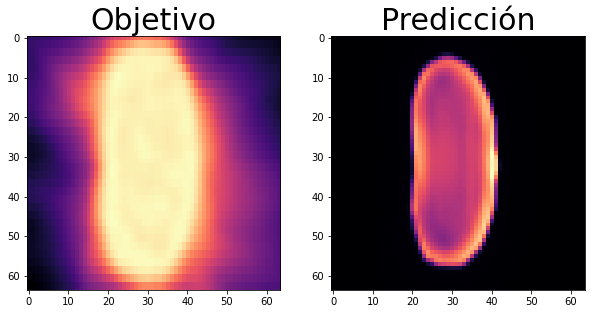

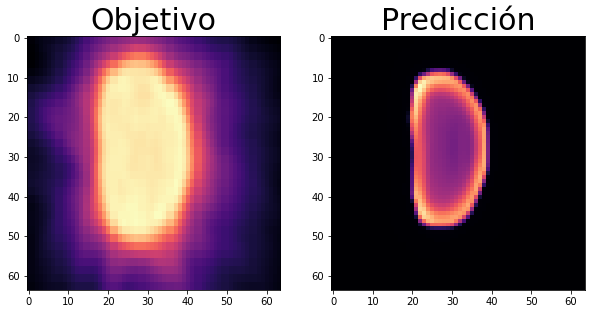

In [40]:
#100 epocas
for i in range(5):
    model.eval()
    with torch.no_grad():
        ix = random.randint(0, len(dataset['test'])-1)
        img, mask = dataset['test'][ix]
        output = model(img.unsqueeze(0).to(device, dtype=torch.float))[0]
        pred_mask = output

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        ax1.set_title('Objetivo', fontsize=30)
        ax1.imshow(mask[:,:,:,29].permute(1,2,0),cmap="magma")
        ax2.set_title('Predicción', fontsize=30)
        ax2.imshow(pred_mask.squeeze().cpu().numpy()[:,:,29],cmap="magma")
        plt.show()

## * Entrenamiento de 10 épocas con L1Loss

In [73]:
device = torch.device('cuda')
model = UNet()
hist = fit(model, dataloader, epochs=10)


Epoch 1/10


test_loss 0.08962 iou 0.867 dice 0.929 i 0.98981: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.67it/s]



Epoch 2/10


test_loss 0.06001 iou 0.900 dice 0.947 i 0.99565: 100%|█████████████████████████████████| 30/30 [00:07<00:00,  3.78it/s]



Epoch 3/10


test_loss 0.05558 iou 0.877 dice 0.934 i 0.99545: 100%|█████████████████████████████████| 30/30 [00:07<00:00,  3.77it/s]



Epoch 4/10


test_loss 0.04663 iou 0.919 dice 0.958 i 0.99676: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.63it/s]



Epoch 5/10


test_loss 0.05283 iou 0.908 dice 0.952 i 0.99644: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.68it/s]



Epoch 6/10


test_loss 0.03716 iou 0.924 dice 0.961 i 0.99749: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.62it/s]



Epoch 7/10


test_loss 0.03465 iou 0.926 dice 0.962 i 0.99766: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.46it/s]



Epoch 8/10


test_loss 0.03987 iou 0.922 dice 0.959 i 0.99734: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.52it/s]



Epoch 9/10


test_loss 0.04704 iou 0.923 dice 0.960 i 0.99698: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.49it/s]



Epoch 10/10


test_loss 0.03430 iou 0.929 dice 0.963 i 0.99748: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.49it/s]


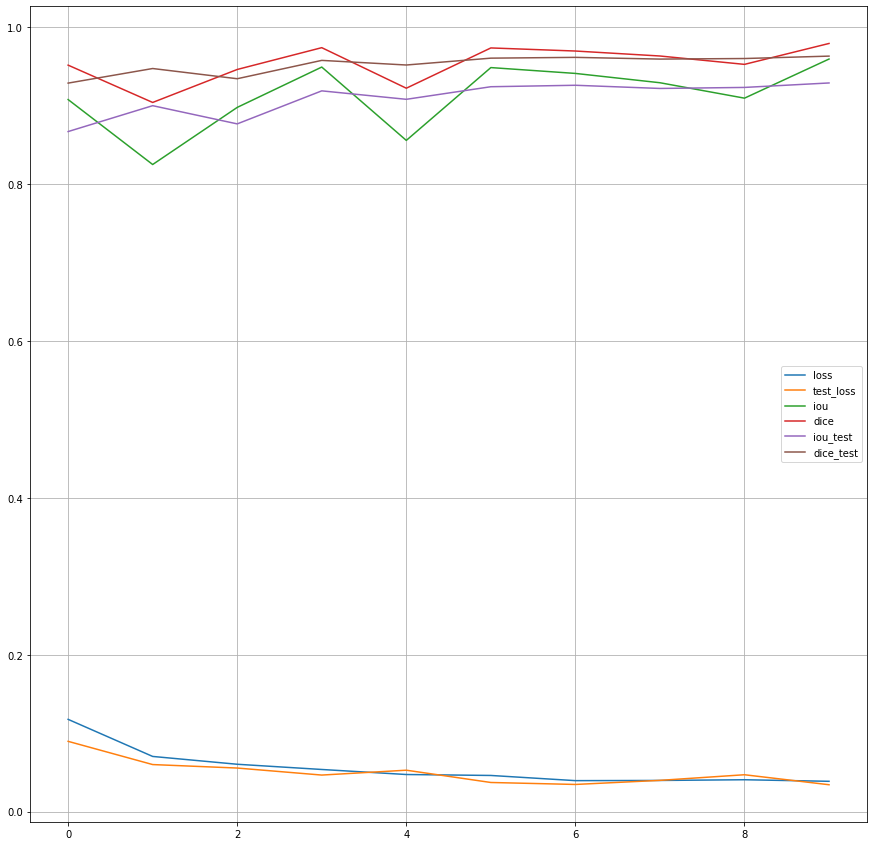

In [75]:
#10 epocas
df = pd.DataFrame(hist)
df.plot(grid=True, figsize=(15,15))
plt.show()

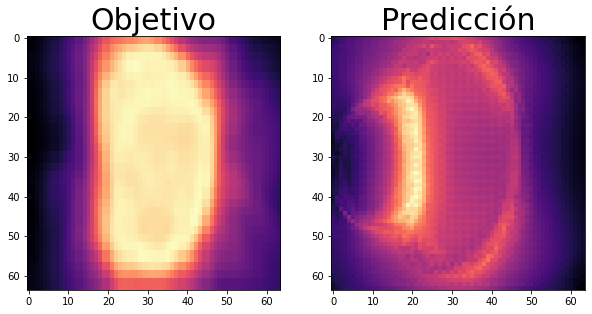

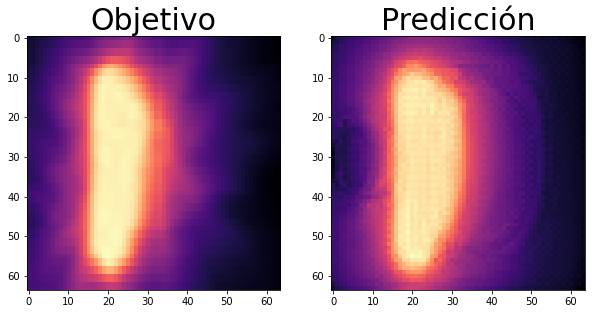

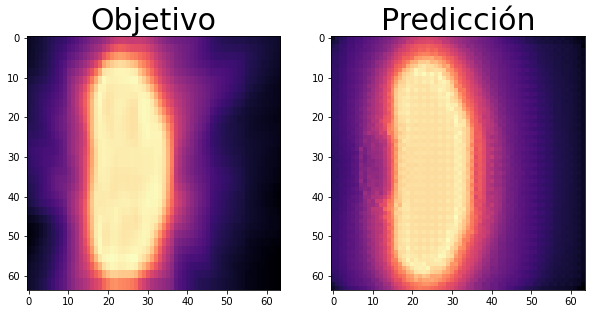

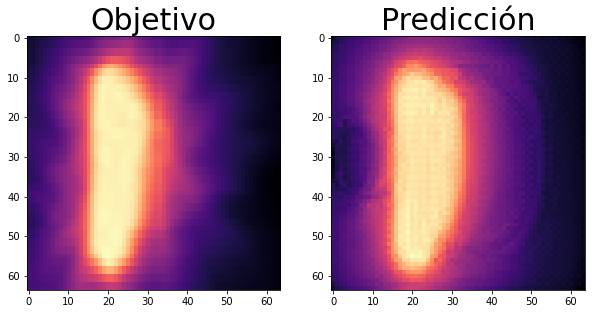

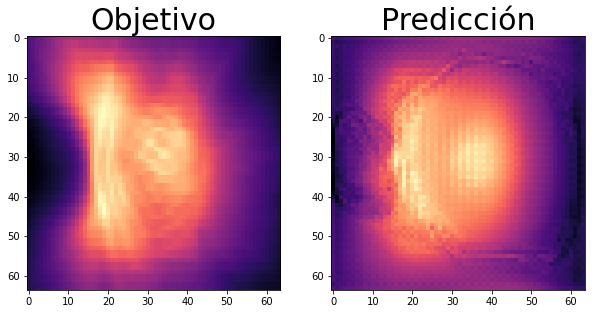

In [76]:
#10 epocas
for i in range(5):
    model.eval()
    with torch.no_grad():
        ix = random.randint(0, len(dataset['test'])-1)
        img, mask = dataset['test'][ix]
        output = model(img.unsqueeze(0).to(device, dtype=torch.float))[0]
        pred_mask = output

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        ax1.set_title('Objetivo', fontsize=30)
        ax1.imshow(mask[:,:,:,29].permute(1,2,0),cmap="magma")
        ax2.set_title('Predicción', fontsize=30)
        ax2.imshow(pred_mask.squeeze().cpu().numpy()[:,:,29],cmap="magma")
        plt.show()

## * Entrenamiento de 100 épocas con L1Loss

In [95]:
device = torch.device('cuda')
model = UNet()
hist = fit(model, dataloader, epochs=100)


Epoch 1/100


test_loss 0.10712 iou 0.879 dice 0.935 i 0.98178: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.65it/s]



Epoch 2/100


test_loss 0.06674 iou 0.902 dice 0.948 i 0.99471: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.63it/s]



Epoch 3/100


test_loss 0.06372 iou 0.890 dice 0.942 i 0.99008: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.70it/s]



Epoch 4/100


test_loss 0.05523 iou 0.912 dice 0.954 i 0.99573: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.50it/s]



Epoch 5/100


test_loss 0.04164 iou 0.925 dice 0.961 i 0.99734: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.44it/s]



Epoch 6/100


test_loss 0.05975 iou 0.911 dice 0.953 i 0.99429: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.53it/s]



Epoch 7/100


test_loss 0.04085 iou 0.928 dice 0.963 i 0.99754: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.54it/s]



Epoch 8/100


test_loss 0.04009 iou 0.928 dice 0.963 i 0.99747: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.48it/s]



Epoch 9/100


test_loss 0.03589 iou 0.906 dice 0.951 i 0.99699: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.46it/s]



Epoch 10/100


test_loss 0.03996 iou 0.923 dice 0.960 i 0.99737: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.44it/s]



Epoch 11/100


test_loss 0.03696 iou 0.921 dice 0.959 i 0.99765: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.44it/s]



Epoch 12/100


test_loss 0.05042 iou 0.899 dice 0.947 i 0.99592: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.48it/s]



Epoch 13/100


test_loss 0.03435 iou 0.932 dice 0.965 i 0.99785: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.50it/s]



Epoch 14/100


test_loss 0.03189 iou 0.929 dice 0.963 i 0.99797: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.45it/s]



Epoch 15/100


test_loss 0.03208 iou 0.924 dice 0.960 i 0.99787: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.58it/s]



Epoch 16/100


test_loss 0.03312 iou 0.925 dice 0.961 i 0.99770: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.53it/s]



Epoch 17/100


test_loss 0.03071 iou 0.934 dice 0.966 i 0.99790: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.54it/s]



Epoch 18/100


test_loss 0.03343 iou 0.929 dice 0.963 i 0.99754: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.45it/s]



Epoch 19/100


test_loss 0.03143 iou 0.932 dice 0.965 i 0.99800: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.50it/s]



Epoch 20/100


test_loss 0.03310 iou 0.928 dice 0.963 i 0.99796: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.38it/s]



Epoch 21/100


test_loss 0.03022 iou 0.934 dice 0.966 i 0.99793: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.43it/s]



Epoch 22/100


test_loss 0.02835 iou 0.930 dice 0.964 i 0.99803: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.44it/s]



Epoch 23/100


test_loss 0.02950 iou 0.933 dice 0.965 i 0.99803: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.57it/s]



Epoch 24/100


test_loss 0.02779 iou 0.935 dice 0.966 i 0.99817: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.50it/s]



Epoch 25/100


test_loss 0.02742 iou 0.927 dice 0.962 i 0.99782: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.50it/s]



Epoch 26/100


test_loss 0.02984 iou 0.937 dice 0.967 i 0.99818: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.47it/s]



Epoch 27/100


test_loss 0.02767 iou 0.931 dice 0.964 i 0.99797: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.48it/s]



Epoch 28/100


test_loss 0.02763 iou 0.929 dice 0.963 i 0.99809: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.42it/s]



Epoch 29/100


test_loss 0.02651 iou 0.932 dice 0.965 i 0.99826: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.55it/s]



Epoch 30/100


test_loss 0.02899 iou 0.921 dice 0.959 i 0.99804: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.43it/s]



Epoch 31/100


test_loss 0.03235 iou 0.920 dice 0.958 i 0.99721: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.51it/s]



Epoch 32/100


test_loss 0.02726 iou 0.933 dice 0.966 i 0.99803: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.49it/s]



Epoch 33/100


test_loss 0.02546 iou 0.934 dice 0.966 i 0.99821: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.38it/s]



Epoch 34/100


test_loss 0.02550 iou 0.930 dice 0.964 i 0.99813: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.50it/s]



Epoch 35/100


test_loss 0.02573 iou 0.935 dice 0.967 i 0.99841: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.44it/s]



Epoch 36/100


test_loss 0.02609 iou 0.936 dice 0.967 i 0.99813: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.51it/s]



Epoch 37/100


test_loss 0.02779 iou 0.934 dice 0.966 i 0.99822: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.53it/s]



Epoch 38/100


test_loss 0.02851 iou 0.935 dice 0.966 i 0.99771: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.53it/s]



Epoch 39/100


test_loss 0.02752 iou 0.928 dice 0.963 i 0.99815: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.44it/s]



Epoch 40/100


test_loss 0.02607 iou 0.930 dice 0.964 i 0.99816: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.52it/s]



Epoch 41/100


test_loss 0.02479 iou 0.938 dice 0.968 i 0.99843: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.53it/s]



Epoch 42/100


test_loss 0.02666 iou 0.936 dice 0.967 i 0.99829: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.41it/s]



Epoch 43/100


test_loss 0.02641 iou 0.934 dice 0.966 i 0.99818: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.49it/s]



Epoch 44/100


test_loss 0.02474 iou 0.936 dice 0.967 i 0.99835: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.51it/s]



Epoch 45/100


test_loss 0.02508 iou 0.932 dice 0.965 i 0.99815: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.52it/s]



Epoch 46/100


test_loss 0.02553 iou 0.938 dice 0.968 i 0.99840: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.48it/s]



Epoch 47/100


test_loss 0.02665 iou 0.935 dice 0.966 i 0.99802: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.53it/s]



Epoch 48/100


test_loss 0.02517 iou 0.939 dice 0.969 i 0.99842: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.59it/s]



Epoch 49/100


test_loss 0.02458 iou 0.940 dice 0.969 i 0.99843: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.42it/s]



Epoch 50/100


test_loss 0.02485 iou 0.938 dice 0.968 i 0.99837: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.45it/s]



Epoch 51/100


test_loss 0.02482 iou 0.935 dice 0.966 i 0.99820: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.45it/s]



Epoch 52/100


test_loss 0.02347 iou 0.935 dice 0.967 i 0.99838: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.46it/s]



Epoch 53/100


test_loss 0.02549 iou 0.943 dice 0.971 i 0.99851: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.46it/s]



Epoch 54/100


test_loss 0.02520 iou 0.934 dice 0.966 i 0.99837: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.54it/s]



Epoch 55/100


test_loss 0.02338 iou 0.940 dice 0.969 i 0.99851: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.53it/s]



Epoch 56/100


test_loss 0.02557 iou 0.938 dice 0.968 i 0.99832: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.57it/s]



Epoch 57/100


test_loss 0.02454 iou 0.935 dice 0.966 i 0.99834: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.62it/s]



Epoch 58/100


test_loss 0.02412 iou 0.938 dice 0.968 i 0.99836: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.57it/s]



Epoch 59/100


test_loss 0.02270 iou 0.940 dice 0.969 i 0.99851: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.54it/s]



Epoch 60/100


test_loss 0.02251 iou 0.939 dice 0.968 i 0.99852: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.55it/s]



Epoch 61/100


test_loss 0.02525 iou 0.935 dice 0.966 i 0.99834: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.65it/s]



Epoch 62/100


test_loss 0.02490 iou 0.939 dice 0.968 i 0.99833: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.64it/s]



Epoch 63/100


test_loss 0.02433 iou 0.944 dice 0.971 i 0.99853: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.50it/s]



Epoch 64/100


test_loss 0.02279 iou 0.939 dice 0.969 i 0.99861: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.55it/s]



Epoch 65/100


test_loss 0.02268 iou 0.935 dice 0.966 i 0.99836: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.47it/s]



Epoch 66/100


test_loss 0.02529 iou 0.934 dice 0.966 i 0.99821: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.47it/s]



Epoch 67/100


test_loss 0.02477 iou 0.940 dice 0.969 i 0.99840: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.49it/s]



Epoch 68/100


test_loss 0.02420 iou 0.939 dice 0.969 i 0.99813: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.51it/s]



Epoch 69/100


test_loss 0.02517 iou 0.933 dice 0.966 i 0.99818: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.50it/s]



Epoch 70/100


test_loss 0.02256 iou 0.941 dice 0.970 i 0.99848: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.50it/s]



Epoch 71/100


test_loss 0.02309 iou 0.943 dice 0.970 i 0.99859: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.57it/s]



Epoch 72/100


test_loss 0.02444 iou 0.934 dice 0.966 i 0.99834: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.56it/s]



Epoch 73/100


test_loss 0.02264 iou 0.938 dice 0.968 i 0.99851: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.46it/s]



Epoch 74/100


test_loss 0.02418 iou 0.941 dice 0.969 i 0.99841: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.45it/s]



Epoch 75/100


test_loss 0.02234 iou 0.943 dice 0.970 i 0.99845: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.54it/s]



Epoch 76/100


test_loss 0.02250 iou 0.939 dice 0.968 i 0.99850: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.51it/s]



Epoch 77/100


test_loss 0.02196 iou 0.942 dice 0.970 i 0.99852: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.46it/s]



Epoch 78/100


test_loss 0.02215 iou 0.941 dice 0.969 i 0.99849: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.58it/s]



Epoch 79/100


test_loss 0.02447 iou 0.939 dice 0.969 i 0.99844: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.56it/s]



Epoch 80/100


test_loss 0.02180 iou 0.941 dice 0.970 i 0.99861: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.60it/s]



Epoch 81/100


test_loss 0.02468 iou 0.940 dice 0.969 i 0.99847: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.44it/s]



Epoch 82/100


test_loss 0.02248 iou 0.941 dice 0.970 i 0.99850: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.46it/s]



Epoch 83/100


test_loss 0.02175 iou 0.943 dice 0.970 i 0.99864: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.53it/s]



Epoch 84/100


test_loss 0.02191 iou 0.942 dice 0.970 i 0.99861: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.51it/s]



Epoch 85/100


test_loss 0.02182 iou 0.943 dice 0.970 i 0.99859: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.51it/s]



Epoch 86/100


test_loss 0.02235 iou 0.941 dice 0.970 i 0.99838: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.39it/s]



Epoch 87/100


test_loss 0.02515 iou 0.938 dice 0.968 i 0.99830: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.52it/s]



Epoch 88/100


test_loss 0.02320 iou 0.941 dice 0.969 i 0.99844: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.53it/s]



Epoch 89/100


test_loss 0.02297 iou 0.943 dice 0.971 i 0.99859: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.49it/s]



Epoch 90/100


test_loss 0.02252 iou 0.940 dice 0.969 i 0.99853: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.48it/s]



Epoch 91/100


test_loss 0.02191 iou 0.937 dice 0.968 i 0.99849: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.60it/s]



Epoch 92/100


test_loss 0.02218 iou 0.943 dice 0.971 i 0.99857: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.56it/s]



Epoch 93/100


test_loss 0.02429 iou 0.939 dice 0.969 i 0.99832: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.47it/s]



Epoch 94/100


test_loss 0.02494 iou 0.937 dice 0.967 i 0.99817: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.44it/s]



Epoch 95/100


test_loss 0.02167 iou 0.944 dice 0.971 i 0.99859: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.50it/s]



Epoch 96/100


test_loss 0.02298 iou 0.944 dice 0.971 i 0.99850: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.45it/s]



Epoch 97/100


test_loss 0.02194 iou 0.943 dice 0.971 i 0.99853: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.48it/s]



Epoch 98/100


test_loss 0.02243 iou 0.943 dice 0.971 i 0.99856: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.52it/s]



Epoch 99/100


test_loss 0.02334 iou 0.938 dice 0.968 i 0.99824: 100%|█████████████████████████████████| 30/30 [00:08<00:00,  3.53it/s]



Epoch 100/100


test_loss 0.02379 iou 0.930 dice 0.964 i 0.99816: 100%|█████████████████████████████████| 30/30 [00:09<00:00,  3.21it/s]


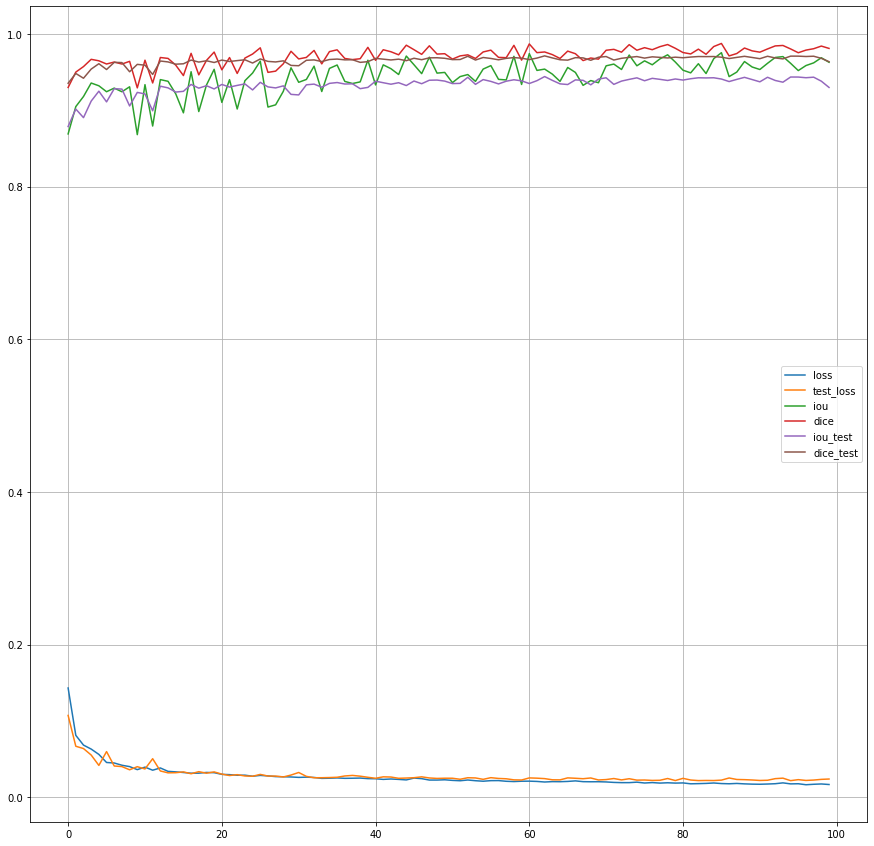

In [96]:
#100 epocas
df = pd.DataFrame(hist)
df.plot(grid=True, figsize=(15,15))
plt.show()

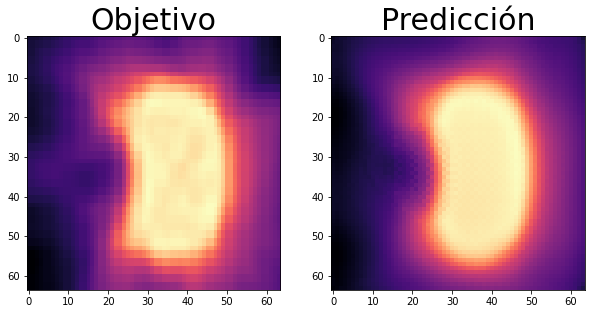

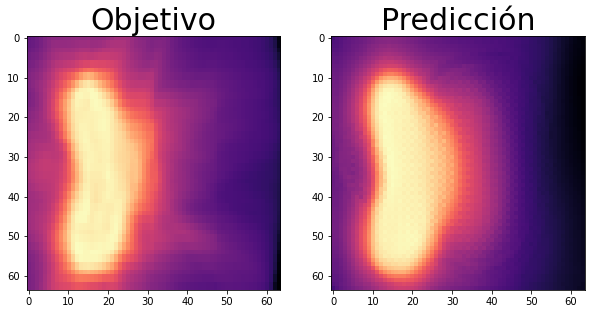

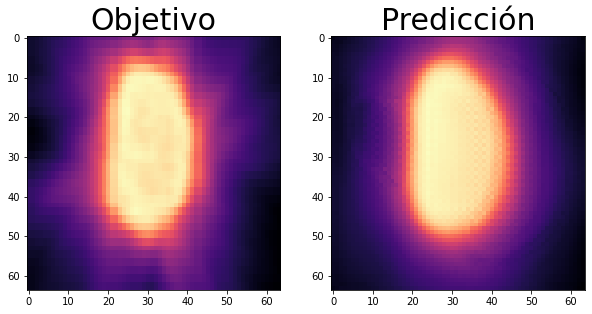

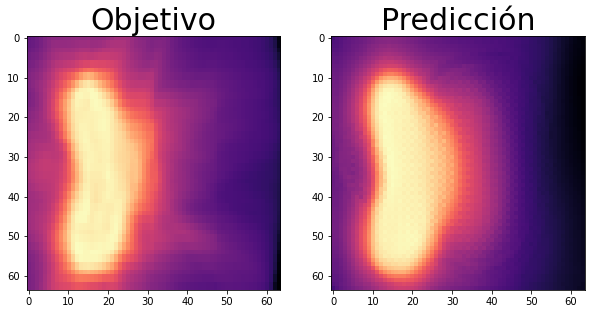

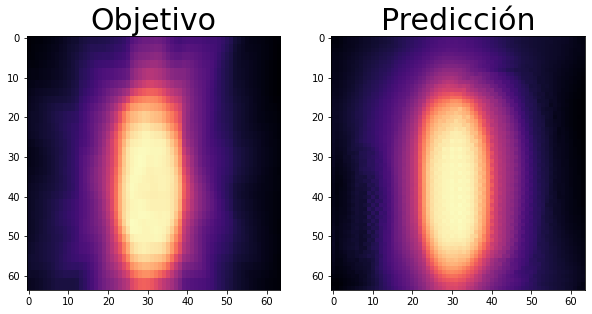

In [97]:
#100 epocas
for i in range(5):
    model.eval()
    with torch.no_grad():
        ix = random.randint(0, len(dataset['test'])-1)
        img, mask = dataset['test'][ix]
        output = model(img.unsqueeze(0).to(device, dtype=torch.float))[0]
        pred_mask = output

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        ax1.set_title('Objetivo', fontsize=30)
        ax1.imshow(mask[:,:,:,29].permute(1,2,0),cmap="magma")
        ax2.set_title('Predicción', fontsize=30)
        ax2.imshow(pred_mask.squeeze().cpu().numpy()[:,:,29],cmap="magma")
        plt.show()

## * Entrenamiento de 10 épocas con BCEDiceLoss

In [19]:
device = torch.device('cuda')
model = UNet()
hist = fit(model, dataloader, epochs=10)


Epoch 1/10


test_loss 0.68257 iou 0.880 dice 0.936 i 0.96536: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.56it/s]



Epoch 2/10


test_loss 0.66889 iou 0.901 dice 0.948 i 0.96990: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.79it/s]



Epoch 3/10


test_loss 0.66495 iou 0.898 dice 0.946 i 0.96732: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.87it/s]



Epoch 4/10


test_loss 0.65873 iou 0.899 dice 0.947 i 0.97391: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.82it/s]



Epoch 5/10


test_loss 0.66565 iou 0.884 dice 0.938 i 0.96631: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.59it/s]



Epoch 6/10


test_loss 0.65659 iou 0.904 dice 0.950 i 0.97091: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.83it/s]



Epoch 7/10


test_loss 0.65466 iou 0.933 dice 0.965 i 0.97753: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.66it/s]



Epoch 8/10


test_loss 0.65556 iou 0.919 dice 0.958 i 0.97629: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.78it/s]



Epoch 9/10


test_loss 0.65371 iou 0.912 dice 0.954 i 0.96938: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.76it/s]



Epoch 10/10


test_loss 0.65357 iou 0.923 dice 0.960 i 0.97611: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.62it/s]


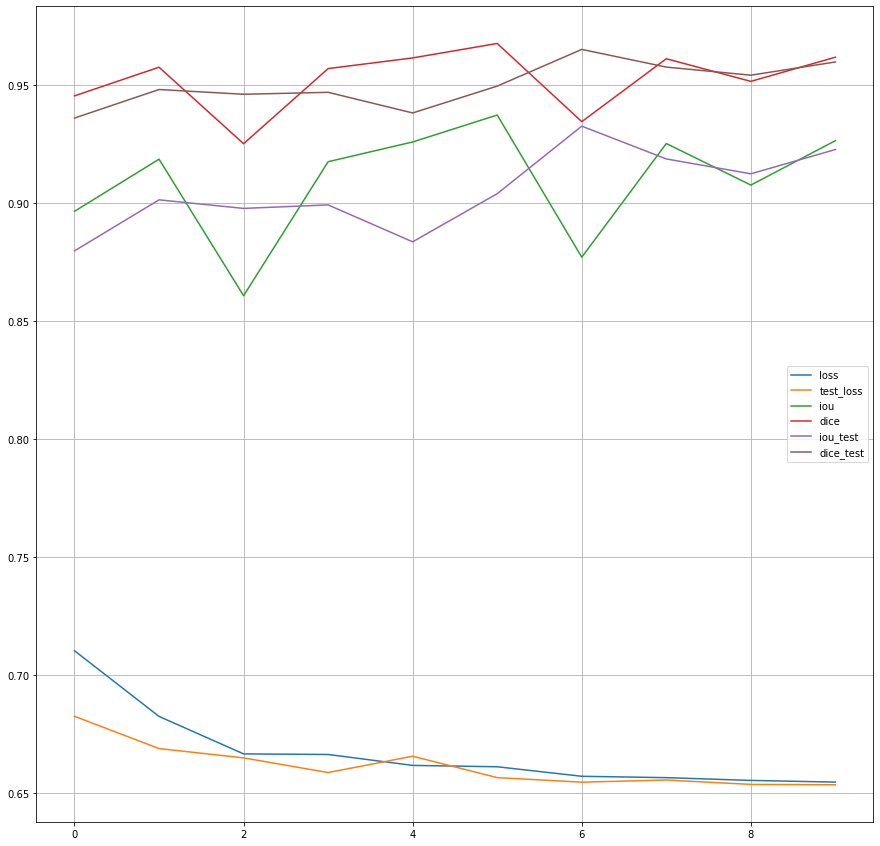

In [20]:
#10 epocas
df = pd.DataFrame(hist)
df.plot(grid=True, figsize=(15,15))
plt.show()

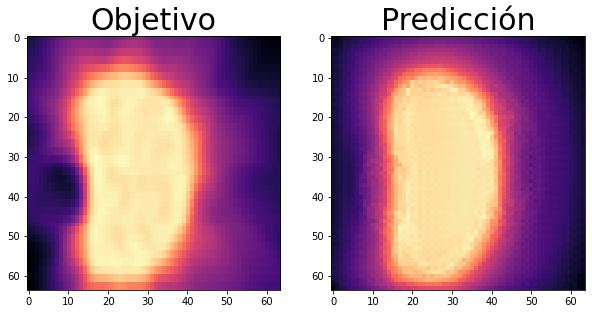

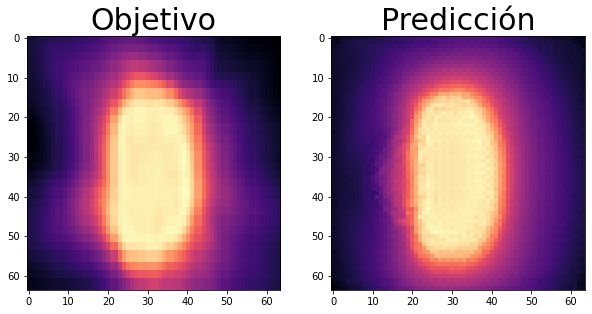

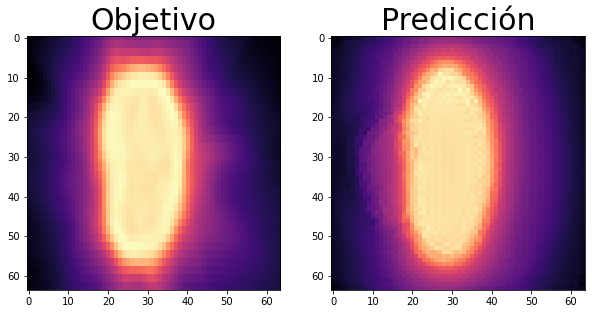

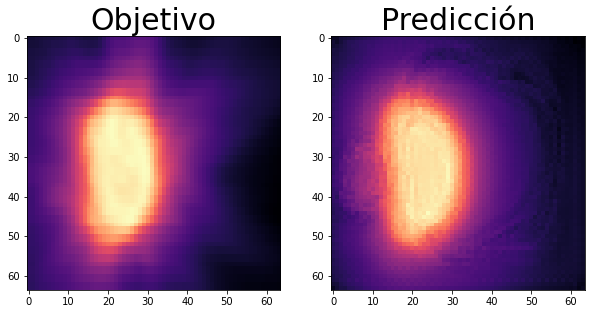

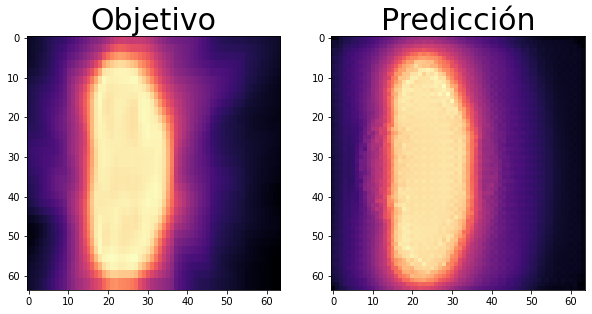

In [21]:
#10 epocas
for i in range(5):
    model.eval()
    with torch.no_grad():
        ix = random.randint(0, len(dataset['test'])-1)
        img, mask = dataset['test'][ix]
        output = model(img.unsqueeze(0).to(device, dtype=torch.float))[0]
        pred_mask = output

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        ax1.set_title('Objetivo', fontsize=30)
        ax1.imshow(mask[:,:,:,29].permute(1,2,0),cmap="magma")
        ax2.set_title('Predicción', fontsize=30)
        ax2.imshow(pred_mask.squeeze().cpu().numpy()[:,:,29],cmap="magma")
        plt.show()

## * Entrenamiento de 100 épocas con BCEDiceLoss

In [19]:
device = torch.device('cuda')
model = UNet()
hist = fit(model, dataloader, epochs=100)


Epoch 1/100


test_loss 0.68430 iou 0.855 dice 0.922 i 0.95939: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.79it/s]



Epoch 2/100


test_loss 0.66865 iou 0.863 dice 0.926 i 0.95802: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.92it/s]



Epoch 3/100


test_loss 0.66113 iou 0.886 dice 0.940 i 0.96841: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.91it/s]



Epoch 4/100


test_loss 0.71718 iou 0.734 dice 0.846 i 0.96385: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.66it/s]



Epoch 5/100


test_loss 0.66017 iou 0.903 dice 0.949 i 0.96533: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.81it/s]



Epoch 6/100


test_loss 0.65520 iou 0.918 dice 0.957 i 0.97475: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.79it/s]



Epoch 7/100


test_loss 0.65453 iou 0.911 dice 0.954 i 0.97395: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.81it/s]



Epoch 8/100


test_loss 0.65300 iou 0.923 dice 0.960 i 0.97168: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.70it/s]



Epoch 9/100


test_loss 0.65349 iou 0.917 dice 0.957 i 0.97663: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.64it/s]



Epoch 10/100


test_loss 0.65280 iou 0.912 dice 0.954 i 0.97610: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.74it/s]



Epoch 11/100


test_loss 0.65505 iou 0.898 dice 0.946 i 0.97430: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.65it/s]



Epoch 12/100


test_loss 0.65498 iou 0.923 dice 0.960 i 0.98001: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.72it/s]



Epoch 13/100


test_loss 0.65248 iou 0.921 dice 0.959 i 0.97595: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.54it/s]



Epoch 14/100


test_loss 0.65214 iou 0.927 dice 0.962 i 0.97484: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.58it/s]



Epoch 15/100


test_loss 0.65182 iou 0.925 dice 0.961 i 0.97382: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.13it/s]



Epoch 16/100


test_loss 0.65161 iou 0.926 dice 0.961 i 0.97101: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.48it/s]



Epoch 17/100


test_loss 0.65161 iou 0.918 dice 0.957 i 0.97609: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.41it/s]



Epoch 18/100


test_loss 0.65139 iou 0.934 dice 0.966 i 0.97338: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.12it/s]



Epoch 19/100


test_loss 0.65150 iou 0.923 dice 0.960 i 0.97482: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  7.86it/s]



Epoch 20/100


test_loss 0.65125 iou 0.929 dice 0.963 i 0.97359: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.45it/s]



Epoch 21/100


test_loss 0.65214 iou 0.929 dice 0.963 i 0.97802: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.43it/s]



Epoch 22/100


test_loss 0.65150 iou 0.927 dice 0.962 i 0.97896: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.52it/s]



Epoch 23/100


test_loss 0.65116 iou 0.927 dice 0.962 i 0.97525: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.42it/s]



Epoch 24/100


test_loss 0.65138 iou 0.923 dice 0.960 i 0.97765: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  7.79it/s]



Epoch 25/100


test_loss 0.65152 iou 0.924 dice 0.960 i 0.97847: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.53it/s]



Epoch 26/100


test_loss 0.65103 iou 0.923 dice 0.960 i 0.97443: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  7.65it/s]



Epoch 27/100


test_loss 0.65145 iou 0.932 dice 0.965 i 0.97473: 100%|█████████████████████████████████| 30/30 [00:04<00:00,  7.20it/s]



Epoch 28/100


test_loss 0.65144 iou 0.909 dice 0.952 i 0.97757: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  7.73it/s]



Epoch 29/100


test_loss 0.65134 iou 0.906 dice 0.951 i 0.97572: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.40it/s]



Epoch 30/100


test_loss 0.65091 iou 0.914 dice 0.955 i 0.97183: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.43it/s]



Epoch 31/100


test_loss 0.65117 iou 0.928 dice 0.962 i 0.97754: 100%|█████████████████████████████████| 30/30 [00:04<00:00,  7.27it/s]



Epoch 32/100


test_loss 0.65096 iou 0.919 dice 0.958 i 0.97562: 100%|█████████████████████████████████| 30/30 [00:04<00:00,  7.02it/s]



Epoch 33/100


test_loss 0.65112 iou 0.925 dice 0.961 i 0.97561: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.41it/s]



Epoch 34/100


test_loss 0.65082 iou 0.916 dice 0.956 i 0.97293: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  7.86it/s]



Epoch 35/100


test_loss 0.65062 iou 0.925 dice 0.961 i 0.97398: 100%|█████████████████████████████████| 30/30 [00:04<00:00,  7.17it/s]



Epoch 36/100


test_loss 0.65085 iou 0.920 dice 0.958 i 0.97079: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  7.76it/s]



Epoch 37/100


test_loss 0.65093 iou 0.914 dice 0.955 i 0.97739: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.44it/s]



Epoch 38/100


test_loss 0.65066 iou 0.924 dice 0.961 i 0.97680: 100%|█████████████████████████████████| 30/30 [00:04<00:00,  7.47it/s]



Epoch 39/100


test_loss 0.65081 iou 0.916 dice 0.956 i 0.97343: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.11it/s]



Epoch 40/100


test_loss 0.65052 iou 0.922 dice 0.959 i 0.97350: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.47it/s]



Epoch 41/100


test_loss 0.65063 iou 0.923 dice 0.960 i 0.97477: 100%|█████████████████████████████████| 30/30 [00:04<00:00,  7.34it/s]



Epoch 42/100


test_loss 0.65114 iou 0.922 dice 0.960 i 0.97528: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  7.91it/s]



Epoch 43/100


test_loss 0.67008 iou 0.842 dice 0.914 i 0.97015: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.46it/s]



Epoch 44/100


test_loss 0.66723 iou 0.905 dice 0.950 i 0.98101: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.12it/s]



Epoch 45/100


test_loss 0.65562 iou 0.915 dice 0.956 i 0.96827: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.51it/s]



Epoch 46/100


test_loss 0.65421 iou 0.913 dice 0.955 i 0.97844: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.52it/s]



Epoch 47/100


test_loss 0.65250 iou 0.918 dice 0.957 i 0.97554: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.43it/s]



Epoch 48/100


test_loss 0.65146 iou 0.914 dice 0.955 i 0.97656: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.16it/s]



Epoch 49/100


test_loss 0.65124 iou 0.917 dice 0.957 i 0.97602: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.46it/s]



Epoch 50/100


test_loss 0.65101 iou 0.922 dice 0.960 i 0.97513: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  7.86it/s]



Epoch 51/100


test_loss 0.65107 iou 0.918 dice 0.957 i 0.97504: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.40it/s]



Epoch 52/100


test_loss 0.65080 iou 0.928 dice 0.963 i 0.97498: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.47it/s]



Epoch 53/100


test_loss 0.65102 iou 0.918 dice 0.957 i 0.97322: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  7.99it/s]



Epoch 54/100


test_loss 0.65064 iou 0.924 dice 0.961 i 0.97423: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.49it/s]



Epoch 55/100


test_loss 0.65079 iou 0.929 dice 0.963 i 0.97500: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.41it/s]



Epoch 56/100


test_loss 0.65063 iou 0.922 dice 0.959 i 0.97225: 100%|█████████████████████████████████| 30/30 [00:04<00:00,  7.29it/s]



Epoch 57/100


test_loss 0.65103 iou 0.910 dice 0.953 i 0.97301: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.27it/s]



Epoch 58/100


test_loss 0.65048 iou 0.927 dice 0.962 i 0.97413: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.31it/s]



Epoch 59/100


test_loss 0.65077 iou 0.917 dice 0.956 i 0.97662: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  7.85it/s]



Epoch 60/100


test_loss 0.65107 iou 0.923 dice 0.960 i 0.97506: 100%|█████████████████████████████████| 30/30 [00:04<00:00,  6.95it/s]



Epoch 61/100


test_loss 0.65050 iou 0.922 dice 0.959 i 0.97498: 100%|█████████████████████████████████| 30/30 [00:04<00:00,  7.36it/s]



Epoch 62/100


test_loss 0.65031 iou 0.929 dice 0.963 i 0.97501: 100%|█████████████████████████████████| 30/30 [00:04<00:00,  7.34it/s]



Epoch 63/100


test_loss 0.65041 iou 0.924 dice 0.960 i 0.97664: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.19it/s]



Epoch 64/100


test_loss 0.65036 iou 0.922 dice 0.959 i 0.97651: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.14it/s]



Epoch 65/100


test_loss 0.65054 iou 0.919 dice 0.958 i 0.97198: 100%|█████████████████████████████████| 30/30 [00:04<00:00,  7.11it/s]



Epoch 66/100


test_loss 0.65026 iou 0.926 dice 0.961 i 0.97484: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  7.80it/s]



Epoch 67/100


test_loss 0.65037 iou 0.918 dice 0.957 i 0.97276: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.20it/s]



Epoch 68/100


test_loss 0.65049 iou 0.914 dice 0.955 i 0.97424: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.16it/s]



Epoch 69/100


test_loss 0.65041 iou 0.921 dice 0.959 i 0.97523: 100%|█████████████████████████████████| 30/30 [00:04<00:00,  7.33it/s]



Epoch 70/100


test_loss 0.65056 iou 0.924 dice 0.961 i 0.97881: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.35it/s]



Epoch 71/100


test_loss 0.65050 iou 0.910 dice 0.953 i 0.97498: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.44it/s]



Epoch 72/100


test_loss 0.65045 iou 0.936 dice 0.967 i 0.97733: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.25it/s]



Epoch 73/100


test_loss 0.65024 iou 0.924 dice 0.961 i 0.97599: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.17it/s]



Epoch 74/100


test_loss 0.65027 iou 0.924 dice 0.960 i 0.97295: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.21it/s]



Epoch 75/100


test_loss 0.65017 iou 0.923 dice 0.960 i 0.97268: 100%|█████████████████████████████████| 30/30 [00:04<00:00,  7.06it/s]



Epoch 76/100


test_loss 0.65014 iou 0.927 dice 0.962 i 0.97476: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  7.87it/s]



Epoch 77/100


test_loss 0.65055 iou 0.921 dice 0.959 i 0.97582: 100%|█████████████████████████████████| 30/30 [00:04<00:00,  7.18it/s]



Epoch 78/100


test_loss 0.65024 iou 0.931 dice 0.964 i 0.97329: 100%|█████████████████████████████████| 30/30 [00:04<00:00,  6.85it/s]



Epoch 79/100


test_loss 0.65058 iou 0.922 dice 0.959 i 0.97701: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.30it/s]



Epoch 80/100


test_loss 0.65020 iou 0.928 dice 0.963 i 0.97592: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.40it/s]



Epoch 81/100


test_loss 0.65009 iou 0.920 dice 0.958 i 0.97271: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.41it/s]



Epoch 82/100


test_loss 0.65007 iou 0.922 dice 0.959 i 0.97417: 100%|█████████████████████████████████| 30/30 [00:04<00:00,  7.09it/s]



Epoch 83/100


test_loss 0.65032 iou 0.918 dice 0.957 i 0.97622: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.14it/s]



Epoch 84/100


test_loss 0.65015 iou 0.923 dice 0.960 i 0.97323: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.22it/s]



Epoch 85/100


test_loss 0.65009 iou 0.917 dice 0.957 i 0.97400: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.30it/s]



Epoch 86/100


test_loss 0.65099 iou 0.905 dice 0.950 i 0.97012: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  7.61it/s]



Epoch 87/100


test_loss 0.65011 iou 0.928 dice 0.963 i 0.97292: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.31it/s]



Epoch 88/100


test_loss 0.65005 iou 0.923 dice 0.960 i 0.97420: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.26it/s]



Epoch 89/100


test_loss 0.65006 iou 0.933 dice 0.965 i 0.97342: 100%|█████████████████████████████████| 30/30 [00:04<00:00,  7.02it/s]



Epoch 90/100


test_loss 0.64997 iou 0.929 dice 0.963 i 0.97349: 100%|█████████████████████████████████| 30/30 [00:04<00:00,  7.48it/s]



Epoch 91/100


test_loss 0.65024 iou 0.929 dice 0.963 i 0.97794: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.19it/s]



Epoch 92/100


test_loss 0.65008 iou 0.928 dice 0.963 i 0.97516: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  7.56it/s]



Epoch 93/100


test_loss 0.65021 iou 0.916 dice 0.956 i 0.97218: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.41it/s]



Epoch 94/100


test_loss 0.65017 iou 0.919 dice 0.958 i 0.97313: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.21it/s]



Epoch 95/100


test_loss 0.64997 iou 0.926 dice 0.961 i 0.97368: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.05it/s]



Epoch 96/100


test_loss 0.65005 iou 0.925 dice 0.961 i 0.97474: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  7.79it/s]



Epoch 97/100


test_loss 0.65001 iou 0.925 dice 0.961 i 0.97372: 100%|█████████████████████████████████| 30/30 [00:04<00:00,  7.31it/s]



Epoch 98/100


test_loss 0.65013 iou 0.934 dice 0.966 i 0.97441: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.15it/s]



Epoch 99/100


test_loss 0.65011 iou 0.932 dice 0.965 i 0.97272: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  7.86it/s]



Epoch 100/100


test_loss 0.65015 iou 0.929 dice 0.963 i 0.97344: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.17it/s]


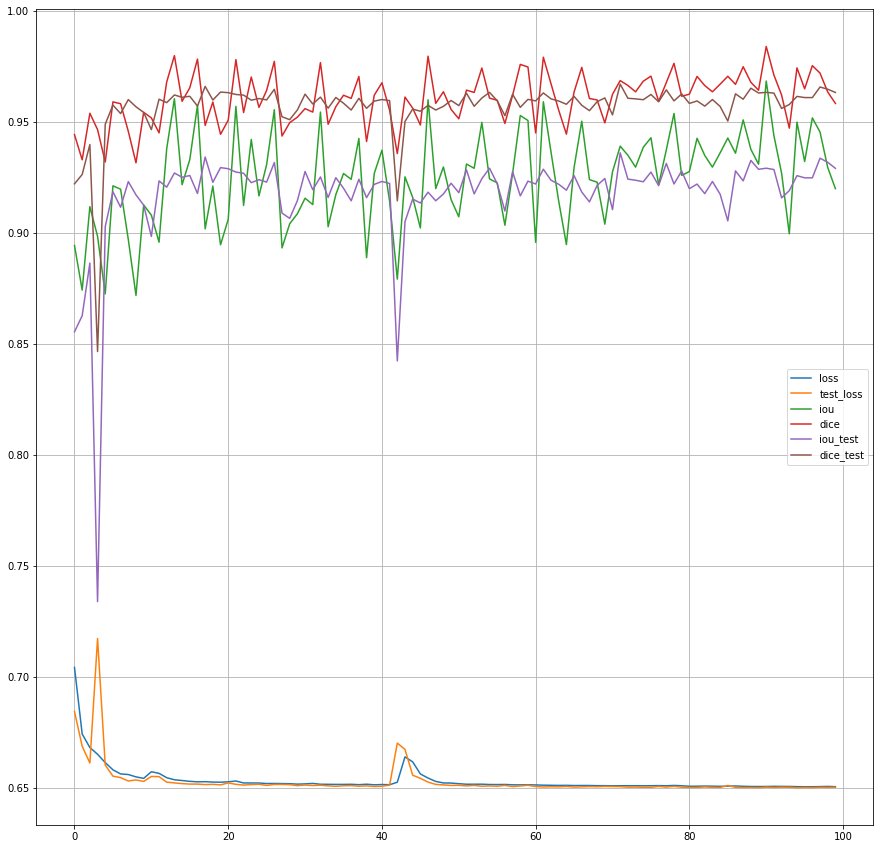

In [20]:
#100 epocas
df = pd.DataFrame(hist)
df.plot(grid=True, figsize=(15,15))
plt.show()

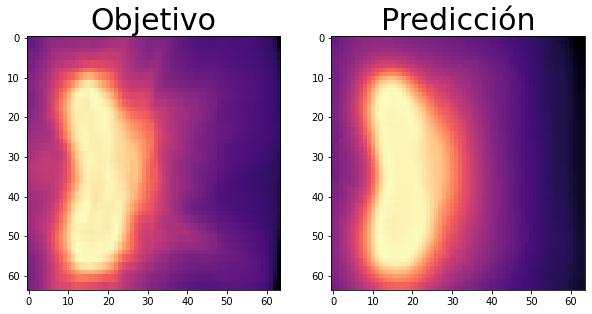

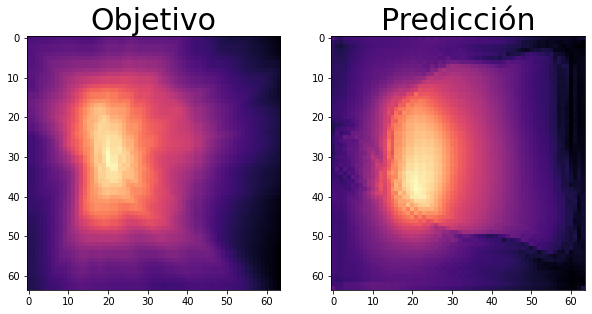

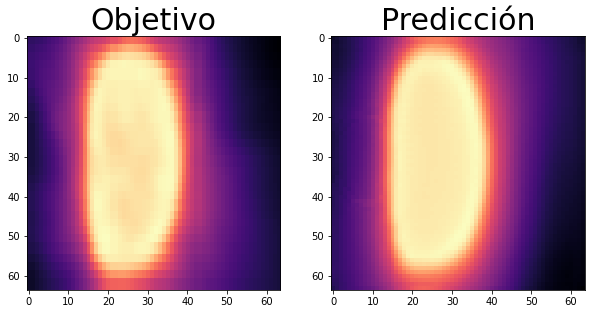

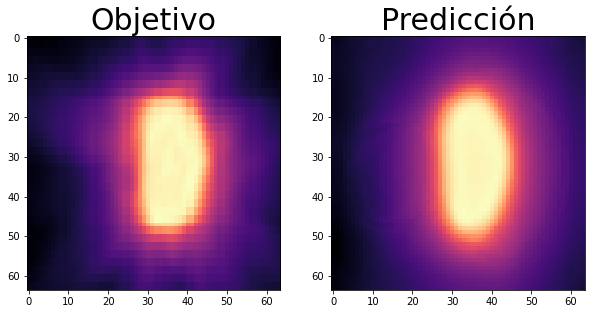

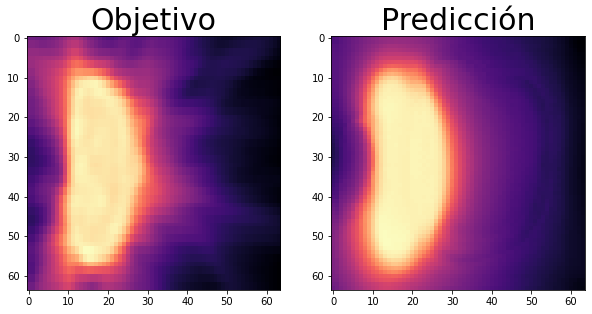

In [21]:
#100 epocas
for i in range(5):
    model.eval()
    with torch.no_grad():
        ix = random.randint(0, len(dataset['test'])-1)
        img, mask = dataset['test'][ix]
        output = model(img.unsqueeze(0).to(device, dtype=torch.float))[0]
        pred_mask = output

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        ax1.set_title('Objetivo', fontsize=30)
        ax1.imshow(mask[:,:,:,29].permute(1,2,0),cmap="magma")
        ax2.set_title('Predicción', fontsize=30)
        ax2.imshow(pred_mask.squeeze().cpu().numpy()[:,:,29],cmap="magma")
        plt.show()

In [41]:
device = torch.device('cuda')
model = UNet()
hist = fit(model, dataloader, epochs=150, lr=1e-3)


Epoch 1/150


test_loss 0.69953 iou 0.836 dice 0.911 i 0.94923: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.58it/s]



Epoch 2/150


test_loss 0.72869 iou 0.727 dice 0.842 i 0.93931: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.70it/s]



Epoch 3/150


test_loss 0.67526 iou 0.898 dice 0.946 i 0.96806: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.63it/s]



Epoch 4/150


test_loss 0.66873 iou 0.896 dice 0.945 i 0.97680: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.52it/s]



Epoch 5/150


test_loss 0.66561 iou 0.867 dice 0.929 i 0.97562: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.51it/s]



Epoch 6/150


test_loss 0.67830 iou 0.910 dice 0.953 i 0.96089: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.49it/s]



Epoch 7/150


test_loss 0.66151 iou 0.896 dice 0.945 i 0.98055: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.43it/s]



Epoch 8/150


test_loss 0.66287 iou 0.899 dice 0.947 i 0.97457: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.48it/s]



Epoch 9/150


test_loss 0.65793 iou 0.920 dice 0.958 i 0.97692: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.54it/s]



Epoch 10/150


test_loss 0.66064 iou 0.920 dice 0.958 i 0.97132: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.44it/s]



Epoch 11/150


test_loss 0.65630 iou 0.921 dice 0.959 i 0.98082: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.38it/s]



Epoch 12/150


test_loss 0.65759 iou 0.911 dice 0.954 i 0.97107: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.36it/s]



Epoch 13/150


test_loss 0.66180 iou 0.917 dice 0.957 i 0.96901: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.39it/s]



Epoch 14/150


test_loss 0.65857 iou 0.892 dice 0.943 i 0.97333: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.12it/s]



Epoch 15/150


test_loss 0.65614 iou 0.913 dice 0.955 i 0.97644: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.33it/s]



Epoch 16/150


test_loss 0.65702 iou 0.918 dice 0.958 i 0.96934: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.19it/s]



Epoch 17/150


test_loss 0.65555 iou 0.904 dice 0.949 i 0.97226: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.17it/s]



Epoch 18/150


test_loss 0.65354 iou 0.915 dice 0.956 i 0.97566: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.34it/s]



Epoch 19/150


test_loss 0.65320 iou 0.919 dice 0.958 i 0.97619: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.19it/s]



Epoch 20/150


test_loss 0.65368 iou 0.926 dice 0.961 i 0.97530: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.10it/s]



Epoch 21/150


test_loss 0.65302 iou 0.927 dice 0.962 i 0.97444: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.24it/s]



Epoch 22/150


test_loss 0.65562 iou 0.906 dice 0.951 i 0.96698: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.20it/s]



Epoch 23/150


test_loss 0.65492 iou 0.914 dice 0.955 i 0.97173: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.11it/s]



Epoch 24/150


test_loss 0.65265 iou 0.932 dice 0.965 i 0.97625: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.30it/s]



Epoch 25/150


test_loss 0.65258 iou 0.929 dice 0.963 i 0.97732: 100%|█████████████████████████████████| 30/30 [00:04<00:00,  7.27it/s]



Epoch 26/150


test_loss 0.65268 iou 0.918 dice 0.957 i 0.97219: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.25it/s]



Epoch 27/150


test_loss 0.65246 iou 0.923 dice 0.960 i 0.97452: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  7.85it/s]



Epoch 28/150


test_loss 0.65347 iou 0.929 dice 0.963 i 0.97441: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.01it/s]



Epoch 29/150


test_loss 0.65336 iou 0.911 dice 0.953 i 0.97457: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.25it/s]



Epoch 30/150


test_loss 0.65309 iou 0.904 dice 0.950 i 0.97771: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.39it/s]



Epoch 31/150


test_loss 0.65263 iou 0.923 dice 0.960 i 0.97797: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.23it/s]



Epoch 32/150


test_loss 0.65366 iou 0.929 dice 0.963 i 0.97633: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.20it/s]



Epoch 33/150


test_loss 0.65354 iou 0.930 dice 0.964 i 0.97082: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  7.90it/s]



Epoch 34/150


test_loss 0.65539 iou 0.916 dice 0.956 i 0.97077: 100%|█████████████████████████████████| 30/30 [00:04<00:00,  7.20it/s]



Epoch 35/150


test_loss 0.65490 iou 0.913 dice 0.955 i 0.98028: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.19it/s]



Epoch 36/150


test_loss 0.65253 iou 0.906 dice 0.951 i 0.97716: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.12it/s]



Epoch 37/150


test_loss 0.65248 iou 0.915 dice 0.956 i 0.97456: 100%|█████████████████████████████████| 30/30 [00:04<00:00,  7.35it/s]



Epoch 38/150


test_loss 0.65465 iou 0.896 dice 0.945 i 0.97593: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.22it/s]



Epoch 39/150


test_loss 0.65225 iou 0.901 dice 0.948 i 0.97382: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.32it/s]



Epoch 40/150


test_loss 0.65231 iou 0.917 dice 0.957 i 0.97235: 100%|█████████████████████████████████| 30/30 [00:04<00:00,  7.31it/s]



Epoch 41/150


test_loss 0.65201 iou 0.897 dice 0.946 i 0.97473: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  7.73it/s]



Epoch 42/150


test_loss 0.65192 iou 0.934 dice 0.966 i 0.97580: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.36it/s]



Epoch 43/150


test_loss 0.65287 iou 0.893 dice 0.944 i 0.97472: 100%|█████████████████████████████████| 30/30 [00:04<00:00,  7.25it/s]



Epoch 44/150


test_loss 0.65200 iou 0.910 dice 0.953 i 0.97508: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  7.75it/s]



Epoch 45/150


test_loss 0.65218 iou 0.913 dice 0.955 i 0.97572: 100%|█████████████████████████████████| 30/30 [00:04<00:00,  7.24it/s]



Epoch 46/150


test_loss 0.65240 iou 0.906 dice 0.951 i 0.97357: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  7.56it/s]



Epoch 47/150


test_loss 0.69553 iou 0.767 dice 0.868 i 0.92368: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.25it/s]



Epoch 48/150


test_loss 0.66034 iou 0.880 dice 0.936 i 0.98476: 100%|█████████████████████████████████| 30/30 [00:04<00:00,  7.13it/s]



Epoch 49/150


test_loss 0.65304 iou 0.914 dice 0.955 i 0.97319: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.22it/s]



Epoch 50/150


test_loss 0.65346 iou 0.912 dice 0.954 i 0.96967: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.35it/s]



Epoch 51/150


test_loss 0.65252 iou 0.916 dice 0.956 i 0.97685: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  7.97it/s]



Epoch 52/150


test_loss 0.65174 iou 0.914 dice 0.955 i 0.97707: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.00it/s]



Epoch 53/150


test_loss 0.65183 iou 0.914 dice 0.955 i 0.97648: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.15it/s]



Epoch 54/150


test_loss 0.65144 iou 0.921 dice 0.959 i 0.97642: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.23it/s]



Epoch 55/150


test_loss 0.65166 iou 0.909 dice 0.952 i 0.97409: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.11it/s]



Epoch 56/150


test_loss 0.65212 iou 0.907 dice 0.951 i 0.97112: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.09it/s]



Epoch 57/150


test_loss 0.65189 iou 0.904 dice 0.949 i 0.97116: 100%|█████████████████████████████████| 30/30 [00:04<00:00,  7.24it/s]



Epoch 58/150


test_loss 0.65122 iou 0.925 dice 0.961 i 0.97311: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.17it/s]



Epoch 59/150


test_loss 0.65324 iou 0.903 dice 0.949 i 0.96508: 100%|█████████████████████████████████| 30/30 [00:04<00:00,  7.02it/s]



Epoch 60/150


test_loss 0.65121 iou 0.915 dice 0.956 i 0.97562: 100%|█████████████████████████████████| 30/30 [00:04<00:00,  7.42it/s]



Epoch 61/150


test_loss 0.65132 iou 0.925 dice 0.961 i 0.97452: 100%|█████████████████████████████████| 30/30 [00:04<00:00,  7.33it/s]



Epoch 62/150


test_loss 0.65117 iou 0.913 dice 0.955 i 0.97358: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  7.88it/s]



Epoch 63/150


test_loss 0.65083 iou 0.921 dice 0.959 i 0.97378: 100%|█████████████████████████████████| 30/30 [00:04<00:00,  7.13it/s]



Epoch 64/150


test_loss 0.65233 iou 0.902 dice 0.948 i 0.97035: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  7.99it/s]



Epoch 65/150


test_loss 0.65168 iou 0.899 dice 0.947 i 0.97232: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  7.59it/s]



Epoch 66/150


test_loss 0.65108 iou 0.911 dice 0.953 i 0.97481: 100%|█████████████████████████████████| 30/30 [00:04<00:00,  7.06it/s]



Epoch 67/150


test_loss 0.65113 iou 0.916 dice 0.956 i 0.97706: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.11it/s]



Epoch 68/150


test_loss 0.65102 iou 0.928 dice 0.963 i 0.97406: 100%|█████████████████████████████████| 30/30 [00:04<00:00,  7.20it/s]



Epoch 69/150


test_loss 0.65060 iou 0.923 dice 0.960 i 0.97574: 100%|█████████████████████████████████| 30/30 [00:04<00:00,  6.95it/s]



Epoch 70/150


test_loss 0.65113 iou 0.912 dice 0.954 i 0.97314: 100%|█████████████████████████████████| 30/30 [00:04<00:00,  7.29it/s]



Epoch 71/150


test_loss 0.65072 iou 0.932 dice 0.965 i 0.97549: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.06it/s]



Epoch 72/150


test_loss 0.65149 iou 0.899 dice 0.947 i 0.97108: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.73it/s]



Epoch 73/150


test_loss 0.65079 iou 0.923 dice 0.960 i 0.97376: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.16it/s]



Epoch 74/150


test_loss 0.65142 iou 0.900 dice 0.947 i 0.97638: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.14it/s]



Epoch 75/150


test_loss 0.65232 iou 0.887 dice 0.940 i 0.96960: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.41it/s]



Epoch 76/150


test_loss 0.65098 iou 0.915 dice 0.956 i 0.97190: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.19it/s]



Epoch 77/150


test_loss 0.65099 iou 0.912 dice 0.954 i 0.97174: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.44it/s]



Epoch 78/150


test_loss 0.65183 iou 0.905 dice 0.950 i 0.97470: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.24it/s]



Epoch 79/150


test_loss 0.65123 iou 0.896 dice 0.945 i 0.97137: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.01it/s]



Epoch 80/150


test_loss 0.65096 iou 0.912 dice 0.954 i 0.97360: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.02it/s]



Epoch 81/150


test_loss 0.65099 iou 0.905 dice 0.950 i 0.97303: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.17it/s]



Epoch 82/150


test_loss 0.65069 iou 0.907 dice 0.951 i 0.97385: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  7.72it/s]



Epoch 83/150


test_loss 0.65085 iou 0.914 dice 0.955 i 0.97528: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.62it/s]



Epoch 84/150


test_loss 0.65036 iou 0.927 dice 0.962 i 0.97415: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.40it/s]



Epoch 85/150


test_loss 0.65102 iou 0.903 dice 0.949 i 0.97280: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.28it/s]



Epoch 86/150


test_loss 0.65117 iou 0.911 dice 0.953 i 0.96947: 100%|█████████████████████████████████| 30/30 [00:04<00:00,  7.20it/s]



Epoch 87/150


test_loss 0.65063 iou 0.926 dice 0.962 i 0.97754: 100%|█████████████████████████████████| 30/30 [00:04<00:00,  7.13it/s]



Epoch 88/150


test_loss 0.65033 iou 0.925 dice 0.961 i 0.97422: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.50it/s]



Epoch 89/150


test_loss 0.65056 iou 0.918 dice 0.957 i 0.97179: 100%|█████████████████████████████████| 30/30 [00:04<00:00,  7.16it/s]



Epoch 90/150


test_loss 0.65070 iou 0.912 dice 0.954 i 0.97451: 100%|█████████████████████████████████| 30/30 [00:04<00:00,  7.30it/s]



Epoch 91/150


test_loss 0.65027 iou 0.921 dice 0.959 i 0.97357: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  7.95it/s]



Epoch 92/150


test_loss 0.65045 iou 0.938 dice 0.968 i 0.97363: 100%|█████████████████████████████████| 30/30 [00:04<00:00,  7.38it/s]



Epoch 93/150


test_loss 0.65024 iou 0.934 dice 0.966 i 0.97467: 100%|█████████████████████████████████| 30/30 [00:04<00:00,  7.17it/s]



Epoch 94/150


test_loss 0.65085 iou 0.912 dice 0.954 i 0.97221: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.24it/s]



Epoch 95/150


test_loss 0.65059 iou 0.916 dice 0.956 i 0.97276: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.49it/s]



Epoch 96/150


test_loss 0.65068 iou 0.923 dice 0.960 i 0.97281: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.22it/s]



Epoch 97/150


test_loss 0.65051 iou 0.918 dice 0.957 i 0.97444: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.35it/s]



Epoch 98/150


test_loss 0.65008 iou 0.921 dice 0.959 i 0.97484: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  7.92it/s]



Epoch 99/150


test_loss 0.65047 iou 0.924 dice 0.960 i 0.97596: 100%|█████████████████████████████████| 30/30 [00:04<00:00,  7.32it/s]



Epoch 100/150


test_loss 0.65143 iou 0.907 dice 0.951 i 0.97710: 100%|█████████████████████████████████| 30/30 [00:04<00:00,  7.34it/s]



Epoch 101/150


test_loss 0.65041 iou 0.914 dice 0.955 i 0.97049: 100%|█████████████████████████████████| 30/30 [00:04<00:00,  7.41it/s]



Epoch 102/150


test_loss 0.65013 iou 0.921 dice 0.959 i 0.97400: 100%|█████████████████████████████████| 30/30 [00:04<00:00,  7.34it/s]



Epoch 103/150


test_loss 0.65098 iou 0.908 dice 0.952 i 0.97083: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  7.58it/s]



Epoch 104/150


test_loss 0.65038 iou 0.920 dice 0.958 i 0.97544: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.01it/s]



Epoch 105/150


test_loss 0.65034 iou 0.912 dice 0.954 i 0.97342: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.34it/s]



Epoch 106/150


test_loss 0.65056 iou 0.921 dice 0.959 i 0.97429: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  7.71it/s]



Epoch 107/150


test_loss 0.65149 iou 0.902 dice 0.949 i 0.97304: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.28it/s]



Epoch 108/150


test_loss 0.68246 iou 0.807 dice 0.893 i 0.96878: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  7.93it/s]



Epoch 109/150


test_loss 0.65614 iou 0.894 dice 0.944 i 0.96816: 100%|█████████████████████████████████| 30/30 [00:05<00:00,  5.12it/s]



Epoch 110/150


test_loss 0.65341 iou 0.932 dice 0.965 i 0.97293: 100%|█████████████████████████████████| 30/30 [00:05<00:00,  5.00it/s]



Epoch 111/150


test_loss 0.65260 iou 0.924 dice 0.961 i 0.97981: 100%|█████████████████████████████████| 30/30 [00:06<00:00,  4.93it/s]



Epoch 112/150


test_loss 0.65079 iou 0.923 dice 0.960 i 0.97611: 100%|█████████████████████████████████| 30/30 [00:06<00:00,  4.94it/s]



Epoch 113/150


test_loss 0.65095 iou 0.919 dice 0.958 i 0.97496: 100%|█████████████████████████████████| 30/30 [00:06<00:00,  4.66it/s]



Epoch 114/150


test_loss 0.65076 iou 0.916 dice 0.956 i 0.97604: 100%|█████████████████████████████████| 30/30 [00:05<00:00,  5.05it/s]



Epoch 115/150


test_loss 0.65105 iou 0.907 dice 0.951 i 0.97033: 100%|█████████████████████████████████| 30/30 [00:06<00:00,  4.84it/s]



Epoch 116/150


test_loss 0.65032 iou 0.919 dice 0.958 i 0.97417: 100%|█████████████████████████████████| 30/30 [00:06<00:00,  4.92it/s]



Epoch 117/150


test_loss 0.65055 iou 0.916 dice 0.956 i 0.97227: 100%|█████████████████████████████████| 30/30 [00:06<00:00,  4.98it/s]



Epoch 118/150


test_loss 0.65032 iou 0.917 dice 0.957 i 0.97413: 100%|█████████████████████████████████| 30/30 [00:05<00:00,  5.17it/s]



Epoch 119/150


test_loss 0.65029 iou 0.915 dice 0.955 i 0.97250: 100%|█████████████████████████████████| 30/30 [00:06<00:00,  4.80it/s]



Epoch 120/150


test_loss 0.65026 iou 0.921 dice 0.959 i 0.97388: 100%|█████████████████████████████████| 30/30 [00:06<00:00,  4.60it/s]



Epoch 121/150


test_loss 0.65027 iou 0.922 dice 0.959 i 0.97434: 100%|█████████████████████████████████| 30/30 [00:06<00:00,  4.98it/s]



Epoch 122/150


test_loss 0.65010 iou 0.925 dice 0.961 i 0.97298: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.08it/s]



Epoch 123/150


test_loss 0.65018 iou 0.919 dice 0.958 i 0.97281: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.46it/s]



Epoch 124/150


test_loss 0.65045 iou 0.909 dice 0.952 i 0.97408: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.27it/s]



Epoch 125/150


test_loss 0.65016 iou 0.919 dice 0.958 i 0.97505: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.11it/s]



Epoch 126/150


test_loss 0.64998 iou 0.928 dice 0.963 i 0.97570: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.15it/s]



Epoch 127/150


test_loss 0.65061 iou 0.914 dice 0.955 i 0.97347: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.34it/s]



Epoch 128/150


test_loss 0.65011 iou 0.916 dice 0.956 i 0.97167: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.39it/s]



Epoch 129/150


test_loss 0.65041 iou 0.916 dice 0.956 i 0.97035: 100%|█████████████████████████████████| 30/30 [00:04<00:00,  7.40it/s]



Epoch 130/150


test_loss 0.65037 iou 0.910 dice 0.953 i 0.97323: 100%|█████████████████████████████████| 30/30 [00:04<00:00,  7.47it/s]



Epoch 131/150


test_loss 0.65028 iou 0.920 dice 0.959 i 0.97318: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.34it/s]



Epoch 132/150


test_loss 0.65007 iou 0.920 dice 0.958 i 0.97206: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.40it/s]



Epoch 133/150


test_loss 0.65056 iou 0.911 dice 0.953 i 0.97064: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.66it/s]



Epoch 134/150


test_loss 0.65011 iou 0.930 dice 0.964 i 0.97315: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.29it/s]



Epoch 135/150


test_loss 0.65027 iou 0.916 dice 0.956 i 0.97178: 100%|█████████████████████████████████| 30/30 [00:04<00:00,  7.12it/s]



Epoch 136/150


test_loss 0.65034 iou 0.913 dice 0.955 i 0.97471: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.33it/s]



Epoch 137/150


test_loss 0.65019 iou 0.909 dice 0.952 i 0.97272: 100%|█████████████████████████████████| 30/30 [00:04<00:00,  7.44it/s]



Epoch 138/150


test_loss 0.65008 iou 0.928 dice 0.963 i 0.97369: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  7.87it/s]



Epoch 139/150


test_loss 0.65044 iou 0.907 dice 0.951 i 0.97195: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.04it/s]



Epoch 140/150


test_loss 0.64994 iou 0.920 dice 0.959 i 0.97316: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.53it/s]



Epoch 141/150


test_loss 0.65029 iou 0.929 dice 0.963 i 0.97047: 100%|█████████████████████████████████| 30/30 [00:04<00:00,  7.23it/s]



Epoch 142/150


test_loss 0.65020 iou 0.911 dice 0.953 i 0.97359: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.49it/s]



Epoch 143/150


test_loss 0.65007 iou 0.923 dice 0.960 i 0.97483: 100%|█████████████████████████████████| 30/30 [00:03<00:00,  8.26it/s]



Epoch 144/150


test_loss 0.65009 iou 0.918 dice 0.957 i 0.97333: 100%|█████████████████████████████████| 30/30 [00:05<00:00,  5.22it/s]



Epoch 145/150


test_loss 0.65028 iou 0.924 dice 0.960 i 0.97138: 100%|█████████████████████████████████| 30/30 [00:06<00:00,  4.95it/s]



Epoch 146/150


test_loss 0.65023 iou 0.924 dice 0.960 i 0.97202: 100%|█████████████████████████████████| 30/30 [00:05<00:00,  5.08it/s]



Epoch 147/150


test_loss 0.65031 iou 0.928 dice 0.962 i 0.97419: 100%|█████████████████████████████████| 30/30 [00:06<00:00,  4.99it/s]



Epoch 148/150


test_loss 0.65006 iou 0.917 dice 0.957 i 0.97276: 100%|█████████████████████████████████| 30/30 [00:05<00:00,  5.13it/s]



Epoch 149/150


test_loss 0.65029 iou 0.915 dice 0.956 i 0.97106: 100%|█████████████████████████████████| 30/30 [00:06<00:00,  4.88it/s]



Epoch 150/150


test_loss 0.65023 iou 0.914 dice 0.955 i 0.97072: 100%|█████████████████████████████████| 30/30 [00:06<00:00,  4.64it/s]


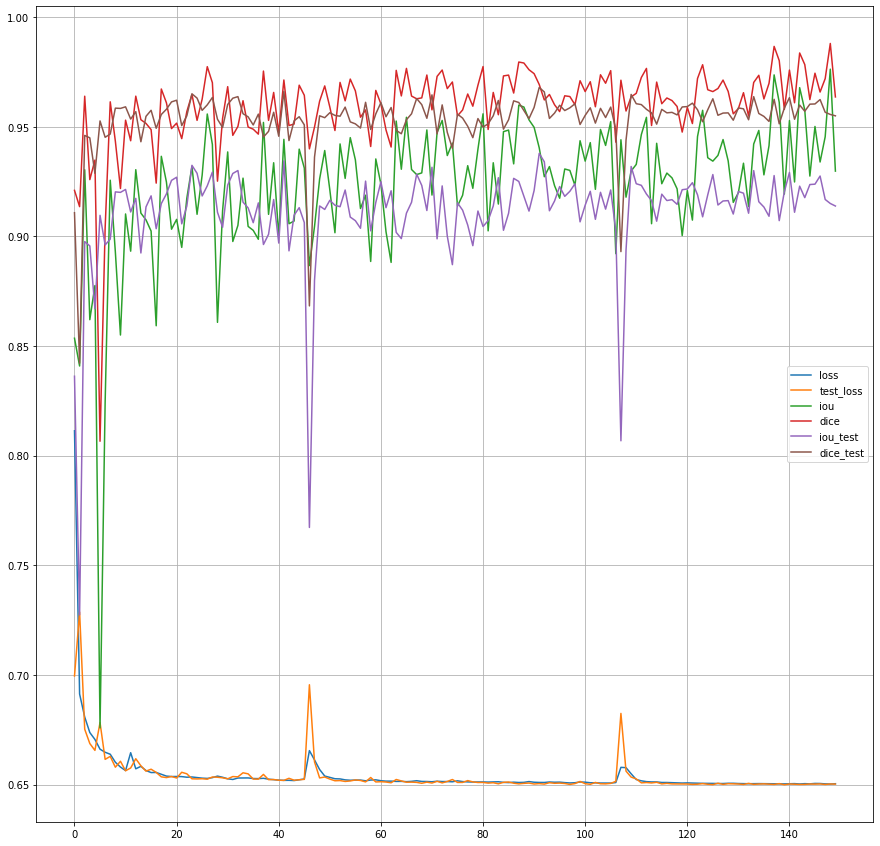

In [43]:
#150 epocas
df = pd.DataFrame(hist)
df.plot(grid=True, figsize=(15,15))
plt.show()

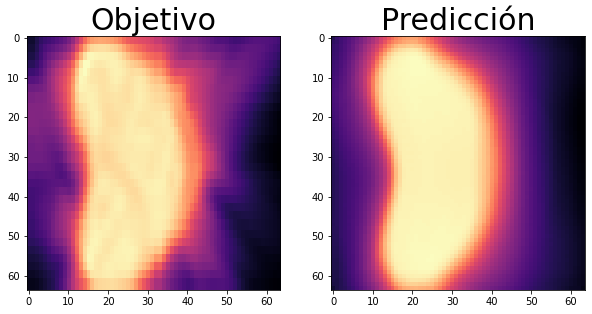

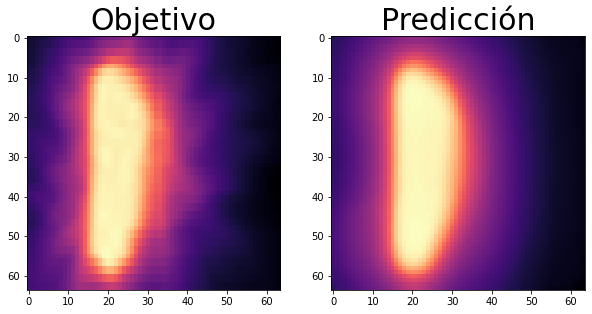

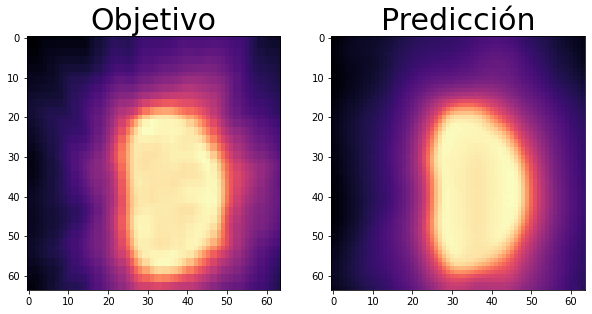

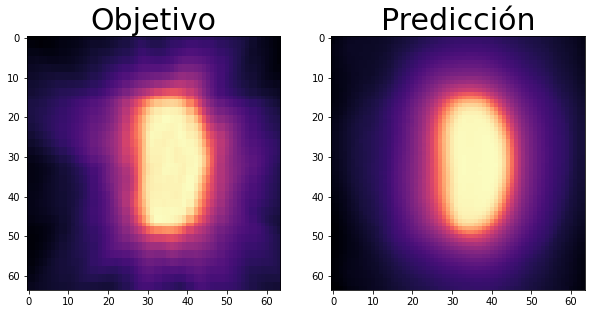

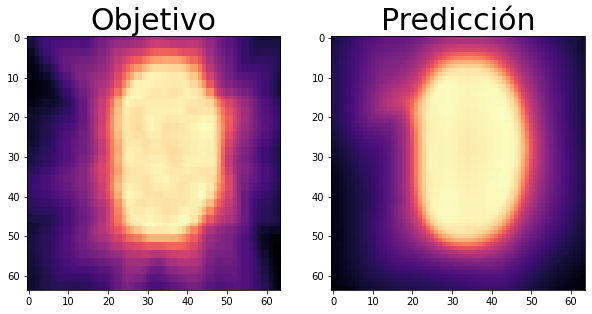

In [42]:
#150 epocas
for i in range(5):
    model.eval()
    with torch.no_grad():
        ix = random.randint(0, len(dataset['test'])-1)
        img, mask = dataset['test'][ix]
        output = model(img.unsqueeze(0).to(device, dtype=torch.float))[0]
        pred_mask = output

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        ax1.set_title('Objetivo', fontsize=30)
        ax1.imshow(mask[:,:,:,29].permute(1,2,0),cmap="magma")
        ax2.set_title('Predicción', fontsize=30)
        ax2.imshow(pred_mask.squeeze().cpu().numpy()[:,:,29],cmap="magma")
        plt.show()

## * Entrenamiento de 1000 épocas con torch.nn.MSELoss

In [ ]:
device = torch.device('cuda')
model = UNet()
hist = fit(model, dataloader, epochs=150)

In [ ]:
#1000 epocas
df = pd.DataFrame(hist)
df.plot(grid=True, figsize=(15,15))
plt.show()

In [ ]:
#1000 epocas
for i in range(5):
    model.eval()
    with torch.no_grad():
        ix = random.randint(0, len(dataset['test'])-1)
        img, mask = dataset['test'][ix]
        output = model(img.unsqueeze(0).to(device, dtype=torch.float))[0]
        pred_mask = output

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        ax1.set_title('Objetivo', fontsize=30)
        ax1.imshow(mask[:,:,:,29].permute(1,2,0),cmap="magma")
        ax2.set_title('Predicción', fontsize=30)
        ax2.imshow(pred_mask.squeeze().cpu().numpy()[:,:,29],cmap="magma")
        plt.show()